<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install tensorflow
!pip install tensorflow-gpu

In [2]:
pip install --upgrade tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in ./venv/lib/python3.6/site-packages (2.2.0)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from tensorflow.keras import optimizers


import pandas
import matplotlib.pyplot as plt
# from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'

In [3]:
# drive.mount(ROOT)
# HOME = join(ROOT,'My Drive')
# print('enter the environment directory')
# directory = input()
COLAB_DIR = '.'
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

In [4]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data['DATE'] = pandas.to_datetime(data['DATE'],format='%Y%m%d')

In [5]:
labels = pandas.DataFrame()
labels['CLASS'] = numpy.where(data['CLOSE'] > data['CLOSE'].shift(1), 1.0, 0.0)
labels['DATE'] = data['DATE'].copy()
labels['TICKER'] = data['TICKER'].copy()
labels.head(10)

,CLASS,DATE,TICKER
0,0.0,2019-11-20,مظنه
1,0.0,2019-11-23,مظنه
2,0.0,2019-11-24,مظنه
3,0.0,2019-11-25,مظنه
4,0.0,2019-11-26,مظنه
5,0.0,2019-11-27,مظنه
6,0.0,2019-11-30,مظنه
7,0.0,2019-12-01,مظنه
8,0.0,2019-12-02,مظنه
9,0.0,2019-12-03,مظنه


Let's assert if we are using GPU.

In [6]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [8]:
import matplotlib.dates as mdates

def draw_ochlv(data_related_to_stock, from_date, to_date):
    fig, axs = plt.subplots(3, 2, sharex=True, figsize=(10,10))
    fig.tight_layout()

    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    axs[0][0].xaxis.set_major_locator(years)
    axs[0][0].xaxis.set_major_formatter(years_fmt)
    axs[0][0].xaxis.set_minor_locator(months)

    mask = (data_related_to_stock['DATE'] >= from_date) & (data_related_to_stock['DATE'] <= to_date ) 
    period = data_related_to_stock.loc[mask]
    
    starting_date = str(from_date)
    ending_date = str(to_date)

    axs[0][0].plot(period['DATE'], period['CLOSE'])
    axs[0][0].set(ylabel='closing price (in tomans)')
    axs[0][0].set_title('closing price')
    
    axs[1][0].plot(period['DATE'], period['OPEN'])
    axs[1][0].set(ylabel='opening price (in tomans)')
    axs[1][0].set_title('opening price')
                     
    
    axs[0][1].plot(period['DATE'], period['VOL'])
    axs[0][1].set(ylabel='daily volume traded (in share)')
    axs[0][1].set_title('daily volume')
                     
    
    axs[1][1].plot(period['DATE'], period['HIGH'])
    axs[1][1].set(ylabel='high price (in tomans)')
    axs[1][1].set_title('high price')
                     
    axs[2][0].plot(period['DATE'], period['LOW'])
    axs[2][0].set(ylabel='low price (in tomans)')
    axs[2][0].set_title('low price')

    axs[0][0].grid(True)
    axs[0][1].grid(True)
    axs[1][0].grid(True)
    axs[1][1].grid(True)
    axs[2][0].grid(True)

    axs[0][0].format_xdata = mdates.DateFormatter('%Y-%m-%d')

    plt.show()

In [9]:
ten_stocks_with_max_trading_days = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[0]
ten_stocks_with_max_trading_days.head(10)

TICKER       DATE                            VOL
                   min        max count          mean
1616  وپترو 2001-03-25 2020-04-13  4366  2.323352e+06
1522  وساخت 2001-03-25 2020-04-13  4356  1.464725e+06
56    آريان 2010-10-06 2020-04-13  4347  2.723661e+06
624   خودرو 2001-03-25 2020-04-13  4340  1.123416e+07
1539   وسپه 2001-03-27 2020-04-13  4323  2.620691e+06
753   زنجان 2011-01-05 2020-04-13  4318  9.637195e+05
567   خبهمن 2001-04-07 2020-04-13  4315  6.061205e+06
1603  ونيكي 2001-04-07 2020-04-13  4302  1.712802e+06
900   شاراك 2001-03-27 2020-04-13  4298  2.342162e+06
1474  وبشهر 2001-03-25 2020-04-13  4291  2.265908e+06

## **Stateful LSTM**

In this section, we train our model on the stock with max trading days. first of all, let's visualize the train and test set of our models.

In [10]:

class MyNormalizer:
  def __init__(self):
    self.max = 0
    self.min = 0

  def fit(self, data):
    self.max = data.max()
    self.min = data.min()
  
  def transform(self, data):
    return (data - self.min) / (self.max - self.min)


def align_data(x, y, window_in_days, batch_size):
  rows_to_insert_to_x = pandas.DataFrame(numpy.zeros((window_in_days+(batch_size - len(x) % batch_size),\
                                                      len(x.columns))), columns=x.columns)
  rows_to_insert_to_y = pandas.DataFrame(numpy.zeros(\
                                                     (window_in_days+(batch_size - len(x) % batch_size), \
                                                      len(y.columns))), columns=y.columns)

  return pandas.concat([rows_to_insert_to_x, x], ignore_index=True), \
        pandas.concat([rows_to_insert_to_y, y], ignore_index=True)
  

def split_data_to_train_test(original_dataset, labels, stock, \
                             training_start, training_end, testing_start, testing_end, \
                             test_required=True, drop_date=True):
  data_related_to_stock = original_dataset[ original_dataset['TICKER'] == stock ].drop('TICKER', axis=1)
  labels_related_to_stock = labels[ labels['TICKER'] == stock ].drop('TICKER', axis=1)

 
  training_period_mask = (data_related_to_stock['DATE'] >= training_start) \
    & (data_related_to_stock['DATE'] <= training_end ) 
  training_period = data_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period = training_period.drop('DATE', axis=1)
  training_period_labels = labels_related_to_stock.loc[training_period_mask]
  if drop_date:
        training_period_labels = training_period_labels.drop('DATE', axis=1)

  testing_period = None
  testing_period_labels = None
  if test_required:
    testing_period_mask = (data_related_to_stock['DATE'] >= testing_start) \
        & (data_related_to_stock['DATE'] <= testing_end )
    testing_period = data_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period = testing_period.drop('DATE', axis=1)
    testing_period_labels = labels_related_to_stock.loc[testing_period_mask]
    if drop_date:
        testing_period_labels = testing_period_labels.drop('DATE', axis=1)

  return training_period, training_period_labels , testing_period, testing_period_labels


def normalize_dataframe_with_max_min(dataframe, train_max, train_min):
    normalized_df=(dataframe - train_min)/(train_max - train_min)
    return normalized_df



In [11]:
training_start = pandas.to_datetime('20080101', format='%Y%m%d', errors='ignore')
training_end = pandas.to_datetime('20170919', format='%Y%m%d', errors='ignore')
testing_start = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
testing_end = pandas.to_datetime('20180719', format='%Y%m%d', errors='ignore')

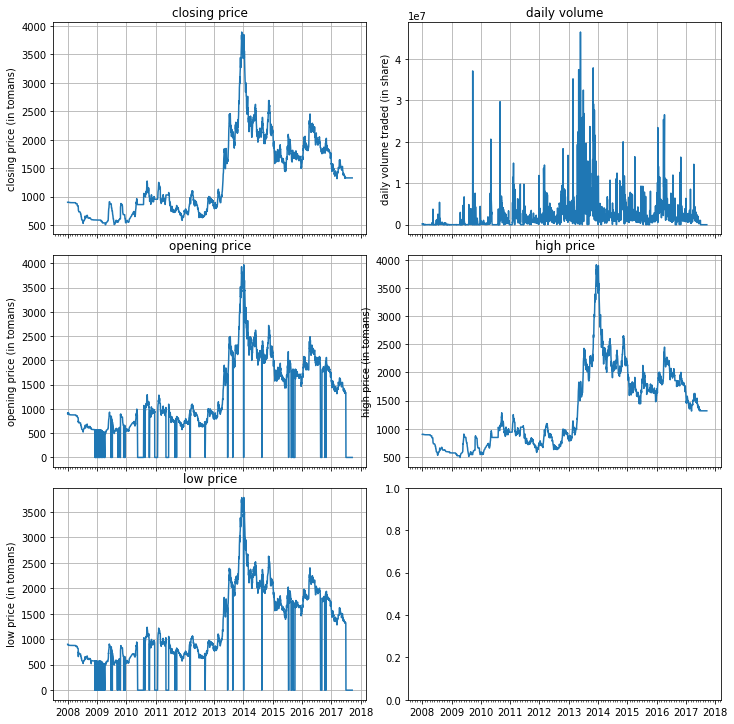

In [12]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]
draw_ochlv(data_related_to_max_stock, training_start, training_end)

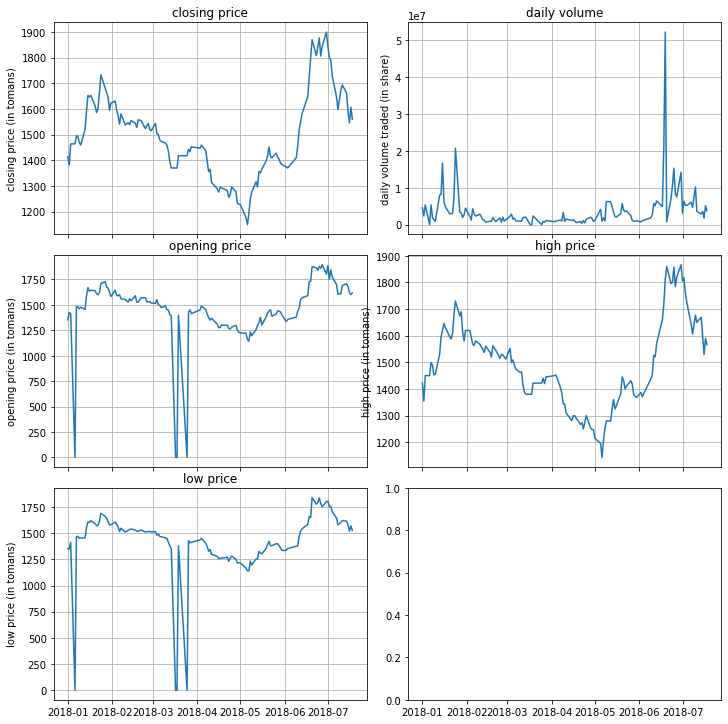

In [13]:
data_related_to_max_stock = data[ data['TICKER'] == stock_with_max_trading_days ]
draw_ochlv(data_related_to_max_stock, testing_start, testing_end)

Now, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 10.

In [14]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 10, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 10, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

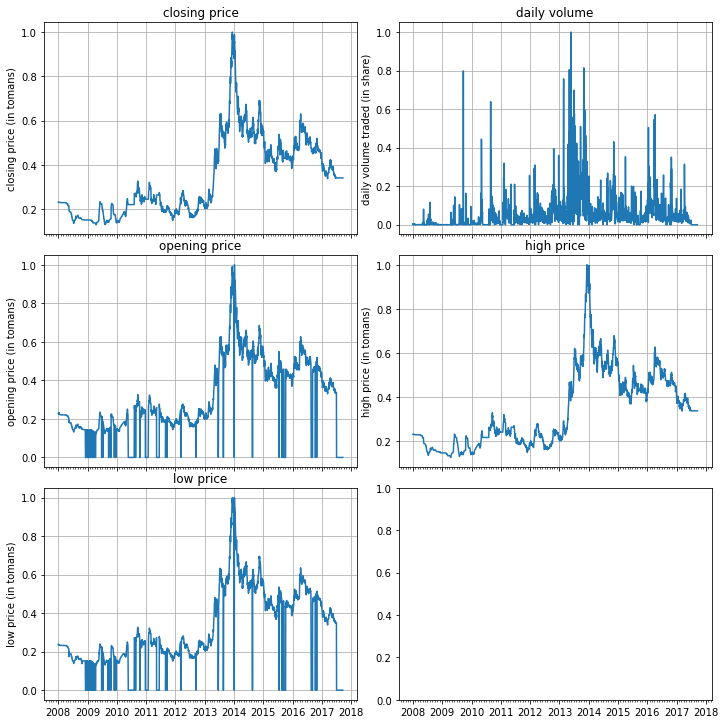

In [15]:
draw_ochlv(_training_period, training_start, training_end)

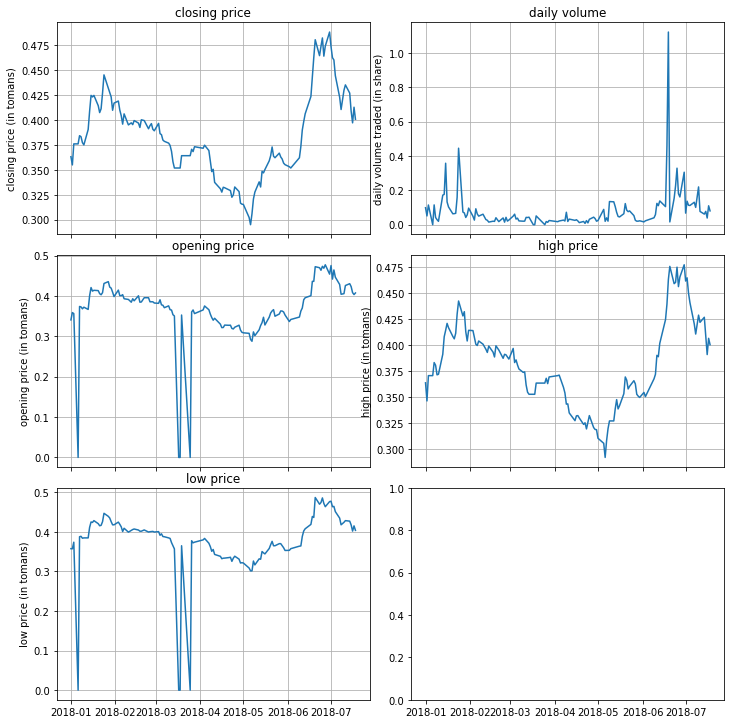

In [16]:
draw_ochlv(_testing_period, testing_start, testing_end)

Next, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 20.

In [17]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 20, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 20, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

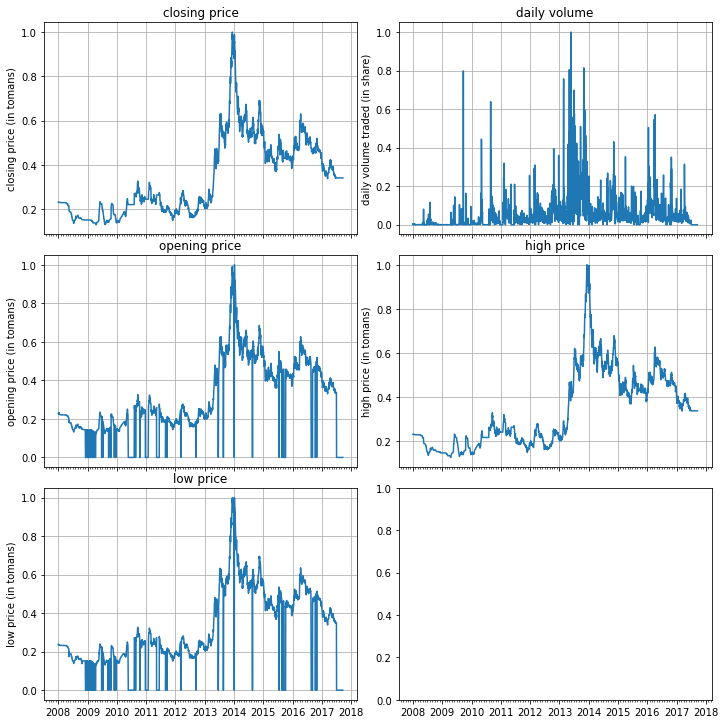

In [18]:
draw_ochlv(_training_period, training_start, training_end)

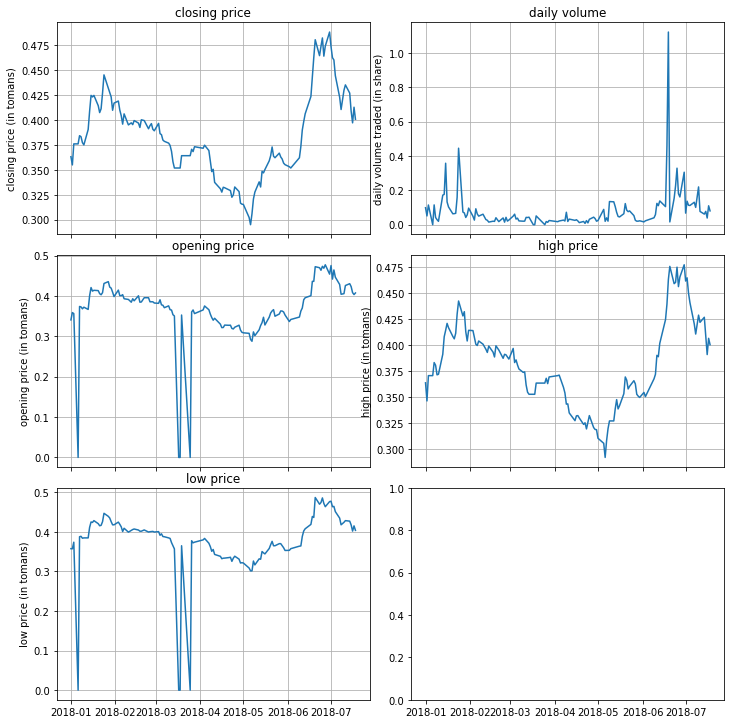

In [19]:
draw_ochlv(_testing_period, testing_start, testing_end)

Next, let's apply alignment and normalization on both sets and see the range of data. The batch size is 32 and window length is 30.

In [20]:
normalizer = MyNormalizer()

training_period, training_labels, testing_period, testing_labels \
    = split_data_to_train_test(data, labels, \
                               stock_with_max_trading_days, training_start, training_end \
                                , testing_start, testing_end, True, False)

training_period, _ = align_data(training_period, \
                                                       training_labels, 30, 32)

testing_period, _ = align_data(testing_period, \
                                                       testing_labels, 30, 32)
training_date = training_period['DATE']
testing_date = testing_period['DATE']

_training_period = training_period.drop('DATE', axis=1)
_testing_period = testing_period.drop('DATE', axis=1)

normalizer.fit(_training_period)
_training_period = normalizer.transform(_training_period)
_testing_period = normalizer.transform(_testing_period)
_training_period['DATE'] = training_date.reset_index(drop=True).replace(0, numpy.nan)
_testing_period['DATE'] = testing_date.reset_index(drop=True).replace(0, numpy.nan)

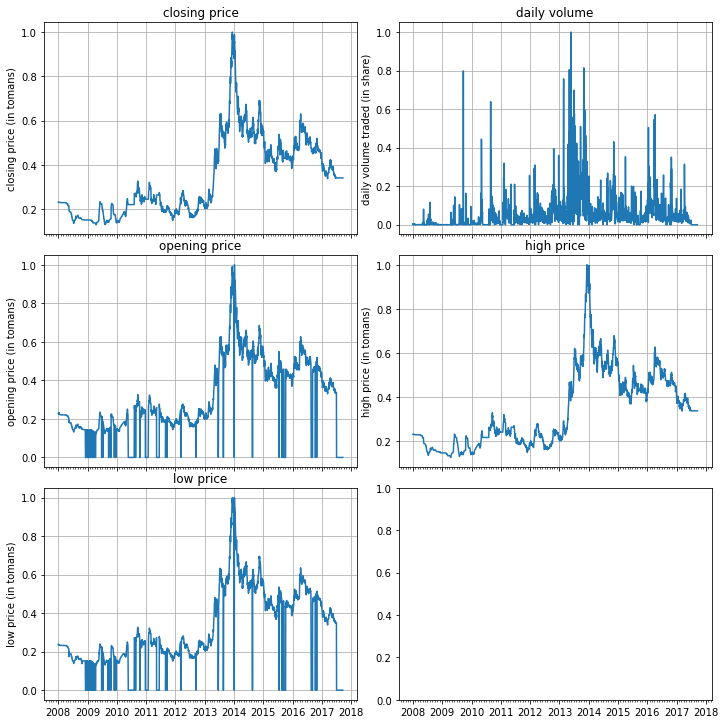

In [21]:
draw_ochlv(_training_period, training_start, training_end)

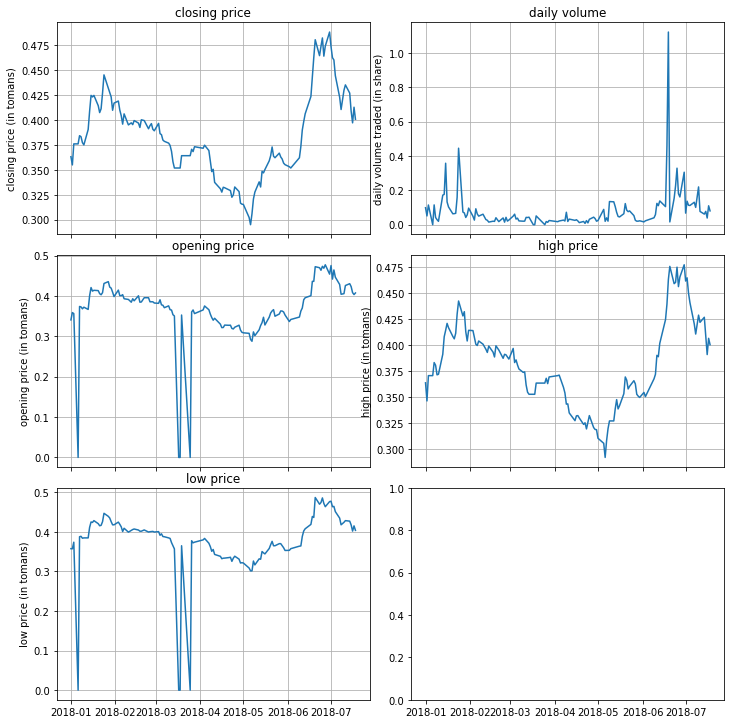

In [22]:
draw_ochlv(_testing_period, testing_start, testing_end)

So, the normalization is really suitable for this dataset.

**Now it is time to start training our model**

We use adam optimizer throughout this experiment and train the models for 5000 epochs.

In [18]:
epochs = 5000

In [19]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [11]:
from numpy.random import uniform

def generate_datasets_for_model(original_dataset, labels, stock, training_start, training_end, \
                                testing_start, testing_end, window_in_days=10, batch_size=32, test_required=True):
  normalizer = MyNormalizer()
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []

  training_period, training_period_labels, testing_period, testing_period_labels \
    = split_data_to_train_test(original_dataset, labels, stock, training_start, training_end \
                                , testing_start, testing_end, test_required, True)


  training_period, training_period_labels = align_data(training_period, \
                                                       training_period_labels, window_in_days, batch_size)

  if test_required:
    testing_period, testing_period_labels = align_data(testing_period, \
                                                       testing_period_labels, window_in_days, batch_size)                                                                                               

  normalizer.fit(training_period)
  training_period = normalizer.transform(training_period)

  for j in range(window_in_days, len(training_period)):
    training_data.append(numpy.array(training_period[ j - window_in_days : j ].copy()))
    training_labels.append(numpy.array(training_period_labels.iloc[j]))

  training_data = numpy.array(training_data)
  training_labels = numpy.array(training_labels)

  if test_required:
    testing_period = normalizer.transform(testing_period)
    for j in range(window_in_days, len(testing_period)):
      testing_data.append(numpy.array(testing_period[ j - window_in_days : j ].copy()))
      testing_labels.append(numpy.array(testing_period_labels.iloc[j]))

  testing_data = numpy.array(testing_data)
  testing_labels = numpy.array(testing_labels)

  train_generator = DataGenerator(training_data, training_labels, batch_size=batch_size)
  test_generator = DataGenerator(testing_data, testing_labels, batch_size=batch_size)

  return train_generator, test_generator



In [12]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels, batch_size=32):
        'Initialization'
        self.data = data
        self.dim = data.shape
        self.batch_size = batch_size
        self.labels = labels
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(numpy.floor(self.dim[0] / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        
        x = self.data[index * self.batch_size: (index + 1) * self.batch_size]

        y = self.labels[index * self.batch_size: (index + 1) * self.batch_size]
        
        return x, y

    def on_epoch_end(self):
        pass

In [13]:

def build_model(input_shape, optimizer='adam', layers=None, loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy')]):
  if layers is None:
    model = Sequential()
    model.add(LSTM(64, input_shape=(input_shape[1], input_shape[2])))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dense(4))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

  else:
    model = Sequential(layers)
  
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)


  return model


In [14]:
from tensorflow.keras.callbacks import ProgbarLogger
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class MyLogger(Callback):
    def __init__(self, verbose, count_mode='samples'):
        # Ignore the `verbose` argument specified in `fit()` and pass `count_mode` upstream
        self.verbose = verbose
        self.metrics = ['loss', 'accuracy']
        self.epoch_start = 0
        self.epoch_finish = 0

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        self.params['metrics'] = self.metrics
        self.epochs = self.params['epochs']
        if self.verbose:
            print('----------->> Epoch %d/%d' % (epoch + 1, self.epochs), end='   ')
        self.epoch_start = datetime.now()

    def on_batch_begin(self, batch, logs=None):
        pass

    def on_batch_end(self, batch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_finish = datetime.now()
        duration = (self.epoch_finish - self.epoch_start).total_seconds()
        print('%.3f seconds' % (duration), end=' , ')
        self.log_values = []
        logs = logs or {}
        for k in self.params['metrics']:
            if k in logs:
                self.log_values.append((k, logs[k]))
        if self.verbose:
            for metric, value in self.log_values:
              print('%s : %.3f' % ( metric, value), end='    ')
        print()
    
    def on_train_end(self, logs=None):
        pass


In [15]:
# results is in form of [loss, acc, true positives, false positives, true negatives, false negatives]
def calc_pos_neg_rate(results):
  new_results = {}
  new_results['loss'] = results[0] # loss
  new_results['acc'] = results[1] # accuracy
  new_results['true_positive_rate'] = (results[2]) / (results[2] + results[5]) # true positive rate
  new_results['false_positive_rate'] = (results[3]) / (results[3] + results[4]) # false positive rate
  new_results['positive_precision'] = (results[2]) / (results[2] + results[3]) # positive precision
  new_results['negative_precision'] = (results[4]) / (results[4] + results[5]) # negative precision
  return new_results

In [16]:
def tabular_test_train_results(train_generator, test_generator, train_results, test_results, batch_size=32):
    rows = ['train', 'test']
    columns = [metric for metric in test_results]
    columns.append('set_size')
    table_data = [ [str(train_results[metric]) for metric in train_results],\
            [str(test_results[metric]) for metric in test_results]]
    table_data[0].append(len(train_generator) * batch_size)
    table_data[1].append(len(test_generator) * batch_size)
    table = plt.table(cellText=table_data,
                      rowLabels=rows,
                      colLabels=columns,
                      cellLoc='center',
                      loc='center',
                      rowLoc='center',
                      )
    plt.axis('off')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(2, 8)
    plt.show()

In [17]:
def fit(model, epochs, train_generator):
  train_losses = []

  train_accs = []

  for i in range(epochs):
      print('epoch %d' % (i + 1))
      history = model.fit(x=train_generator,
                        epochs=1,
                        verbose=0,
                        callbacks=[MyLogger(1)]
                        )
      train_accs.append(history.history['accuracy'])
      train_losses.append(history.history['loss'])
      model.reset_states() 
  return train_accs, train_losses

Now, we want to train the model using different window sizes to see the effect on the performance of the model. Throughout the document, we also report true positive rate, false positive rate, positive precision and negative precision.

Let's start with window size of 10.

In [99]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, \
                                                              training_start, training_end, testing_start, \
                                                              testing_end)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
first_model = build_model(None, optimizer, layers, metrics=metrics)
first_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_40 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_10 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_41 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_10 (Batc (32, 16)                  64        
_________________________________________________________________
dense_42 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_43 (Dense)             (32, 1)                 

In [100]:
train_accs, train_losses = fit(first_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.738 seconds , loss : 0.705    accuracy : 0.528    
epoch 2
----------->> Epoch 1/1   0.265 seconds , loss : 0.675    accuracy : 0.576    
epoch 3
----------->> Epoch 1/1   0.229 seconds , loss : 0.664    accuracy : 0.604    
epoch 4
----------->> Epoch 1/1   0.234 seconds , loss : 0.659    accuracy : 0.604    
epoch 5
----------->> Epoch 1/1   0.233 seconds , loss : 0.656    accuracy : 0.619    
epoch 6
----------->> Epoch 1/1   0.257 seconds , loss : 0.655    accuracy : 0.618    
epoch 7
----------->> Epoch 1/1   0.239 seconds , loss : 0.649    accuracy : 0.635    
epoch 8
----------->> Epoch 1/1   0.296 seconds , loss : 0.649    accuracy : 0.607    
epoch 9
----------->> Epoch 1/1   0.308 seconds , loss : 0.650    accuracy : 0.619    
epoch 10
----------->> Epoch 1/1   0.244 seconds , loss : 0.647    accuracy : 0.617    
epoch 11
----------->> Epoch 1/1   0.248 seconds , loss : 0.648    accuracy : 0.619    
epoch 12
----------->> Epoch 1/1   0.244 

----------->> Epoch 1/1   0.253 seconds , loss : 0.522    accuracy : 0.761    
epoch 187
----------->> Epoch 1/1   0.360 seconds , loss : 0.519    accuracy : 0.761    
epoch 188
----------->> Epoch 1/1   0.295 seconds , loss : 0.517    accuracy : 0.762    
epoch 189
----------->> Epoch 1/1   0.258 seconds , loss : 0.515    accuracy : 0.751    
epoch 190
----------->> Epoch 1/1   0.268 seconds , loss : 0.524    accuracy : 0.756    
epoch 191
----------->> Epoch 1/1   0.266 seconds , loss : 0.517    accuracy : 0.763    
epoch 192
----------->> Epoch 1/1   0.271 seconds , loss : 0.511    accuracy : 0.763    
epoch 193
----------->> Epoch 1/1   0.273 seconds , loss : 0.518    accuracy : 0.762    
epoch 194
----------->> Epoch 1/1   0.264 seconds , loss : 0.518    accuracy : 0.762    
epoch 195
----------->> Epoch 1/1   0.289 seconds , loss : 0.511    accuracy : 0.762    
epoch 196
----------->> Epoch 1/1   0.255 seconds , loss : 0.515    accuracy : 0.757    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.241 seconds , loss : 0.460    accuracy : 0.791    
epoch 371
----------->> Epoch 1/1   0.292 seconds , loss : 0.458    accuracy : 0.797    
epoch 372
----------->> Epoch 1/1   0.251 seconds , loss : 0.457    accuracy : 0.796    
epoch 373
----------->> Epoch 1/1   0.300 seconds , loss : 0.458    accuracy : 0.786    
epoch 374
----------->> Epoch 1/1   0.246 seconds , loss : 0.457    accuracy : 0.796    
epoch 375
----------->> Epoch 1/1   0.243 seconds , loss : 0.458    accuracy : 0.785    
epoch 376
----------->> Epoch 1/1   0.240 seconds , loss : 0.463    accuracy : 0.792    
epoch 377
----------->> Epoch 1/1   0.285 seconds , loss : 0.459    accuracy : 0.785    
epoch 378
----------->> Epoch 1/1   0.284 seconds , loss : 0.459    accuracy : 0.797    
epoch 379
----------->> Epoch 1/1   0.270 seconds , loss : 0.466    accuracy : 0.782    
epoch 380
----------->> Epoch 1/1   0.287 seconds , loss : 0.454    accuracy : 0.799    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.296 seconds , loss : 0.373    accuracy : 0.848    
epoch 555
----------->> Epoch 1/1   0.274 seconds , loss : 0.384    accuracy : 0.842    
epoch 556
----------->> Epoch 1/1   0.270 seconds , loss : 0.386    accuracy : 0.842    
epoch 557
----------->> Epoch 1/1   0.256 seconds , loss : 0.378    accuracy : 0.838    
epoch 558
----------->> Epoch 1/1   0.287 seconds , loss : 0.380    accuracy : 0.841    
epoch 559
----------->> Epoch 1/1   0.292 seconds , loss : 0.373    accuracy : 0.841    
epoch 560
----------->> Epoch 1/1   0.285 seconds , loss : 0.389    accuracy : 0.842    
epoch 561
----------->> Epoch 1/1   0.297 seconds , loss : 0.391    accuracy : 0.836    
epoch 562
----------->> Epoch 1/1   0.307 seconds , loss : 0.384    accuracy : 0.834    
epoch 563
----------->> Epoch 1/1   0.328 seconds , loss : 0.383    accuracy : 0.839    
epoch 564
----------->> Epoch 1/1   0.269 seconds , loss : 0.378    accuracy : 0.842    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.291 seconds , loss : 0.302    accuracy : 0.872    
epoch 739
----------->> Epoch 1/1   0.249 seconds , loss : 0.312    accuracy : 0.878    
epoch 740
----------->> Epoch 1/1   0.238 seconds , loss : 0.320    accuracy : 0.872    
epoch 741
----------->> Epoch 1/1   0.237 seconds , loss : 0.322    accuracy : 0.881    
epoch 742
----------->> Epoch 1/1   0.239 seconds , loss : 0.309    accuracy : 0.876    
epoch 743
----------->> Epoch 1/1   0.237 seconds , loss : 0.302    accuracy : 0.877    
epoch 744
----------->> Epoch 1/1   0.237 seconds , loss : 0.310    accuracy : 0.874    
epoch 745
----------->> Epoch 1/1   0.236 seconds , loss : 0.295    accuracy : 0.881    
epoch 746
----------->> Epoch 1/1   0.238 seconds , loss : 0.302    accuracy : 0.876    
epoch 747
----------->> Epoch 1/1   0.238 seconds , loss : 0.309    accuracy : 0.873    
epoch 748
----------->> Epoch 1/1   0.235 seconds , loss : 0.303    accuracy : 0.884    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.309 seconds , loss : 0.258    accuracy : 0.902    
epoch 923
----------->> Epoch 1/1   0.295 seconds , loss : 0.241    accuracy : 0.911    
epoch 924
----------->> Epoch 1/1   0.277 seconds , loss : 0.235    accuracy : 0.908    
epoch 925
----------->> Epoch 1/1   0.251 seconds , loss : 0.240    accuracy : 0.910    
epoch 926
----------->> Epoch 1/1   0.257 seconds , loss : 0.238    accuracy : 0.909    
epoch 927
----------->> Epoch 1/1   0.273 seconds , loss : 0.235    accuracy : 0.909    
epoch 928
----------->> Epoch 1/1   0.275 seconds , loss : 0.244    accuracy : 0.904    
epoch 929
----------->> Epoch 1/1   0.293 seconds , loss : 0.243    accuracy : 0.909    
epoch 930
----------->> Epoch 1/1   0.258 seconds , loss : 0.256    accuracy : 0.904    
epoch 931
----------->> Epoch 1/1   0.280 seconds , loss : 0.236    accuracy : 0.909    
epoch 932
----------->> Epoch 1/1   0.281 seconds , loss : 0.232    accuracy : 0.916    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.264 seconds , loss : 0.217    accuracy : 0.920    
epoch 1015
----------->> Epoch 1/1   0.262 seconds , loss : 0.230    accuracy : 0.910    
epoch 1016
----------->> Epoch 1/1   0.265 seconds , loss : 0.227    accuracy : 0.913    
epoch 1017
----------->> Epoch 1/1   0.269 seconds , loss : 0.221    accuracy : 0.924    
epoch 1018
----------->> Epoch 1/1   0.258 seconds , loss : 0.205    accuracy : 0.927    
epoch 1019
----------->> Epoch 1/1   0.266 seconds , loss : 0.220    accuracy : 0.920    
epoch 1020
----------->> Epoch 1/1   0.265 seconds , loss : 0.198    accuracy : 0.926    
epoch 1021
----------->> Epoch 1/1   0.272 seconds , loss : 0.222    accuracy : 0.920    
epoch 1022
----------->> Epoch 1/1   0.263 seconds , loss : 0.213    accuracy : 0.925    
epoch 1023
----------->> Epoch 1/1   0.270 seconds , loss : 0.215    accuracy : 0.922    
epoch 1024
----------->> Epoch 1/1   0.264 seconds , loss : 0.208    accuracy : 0.921    
epoch 1025
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.218    accuracy : 0.922    
epoch 1197
----------->> Epoch 1/1   0.268 seconds , loss : 0.178    accuracy : 0.937    
epoch 1198
----------->> Epoch 1/1   0.265 seconds , loss : 0.176    accuracy : 0.939    
epoch 1199
----------->> Epoch 1/1   0.271 seconds , loss : 0.174    accuracy : 0.938    
epoch 1200
----------->> Epoch 1/1   0.268 seconds , loss : 0.166    accuracy : 0.943    
epoch 1201
----------->> Epoch 1/1   0.264 seconds , loss : 0.166    accuracy : 0.942    
epoch 1202
----------->> Epoch 1/1   0.271 seconds , loss : 0.176    accuracy : 0.941    
epoch 1203
----------->> Epoch 1/1   0.276 seconds , loss : 0.166    accuracy : 0.943    
epoch 1204
----------->> Epoch 1/1   0.280 seconds , loss : 0.176    accuracy : 0.940    
epoch 1205
----------->> Epoch 1/1   0.268 seconds , loss : 0.166    accuracy : 0.941    
epoch 1206
----------->> Epoch 1/1   0.261 seconds , loss : 0.192    accuracy : 0.931    
epoch 1207
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.150    accuracy : 0.946    
epoch 1379
----------->> Epoch 1/1   0.266 seconds , loss : 0.128    accuracy : 0.961    
epoch 1380
----------->> Epoch 1/1   0.245 seconds , loss : 0.138    accuracy : 0.952    
epoch 1381
----------->> Epoch 1/1   0.293 seconds , loss : 0.145    accuracy : 0.946    
epoch 1382
----------->> Epoch 1/1   0.252 seconds , loss : 0.147    accuracy : 0.954    
epoch 1383
----------->> Epoch 1/1   0.274 seconds , loss : 0.153    accuracy : 0.952    
epoch 1384
----------->> Epoch 1/1   0.282 seconds , loss : 0.143    accuracy : 0.956    
epoch 1385
----------->> Epoch 1/1   0.242 seconds , loss : 0.147    accuracy : 0.951    
epoch 1386
----------->> Epoch 1/1   0.259 seconds , loss : 0.134    accuracy : 0.955    
epoch 1387
----------->> Epoch 1/1   0.247 seconds , loss : 0.136    accuracy : 0.949    
epoch 1388
----------->> Epoch 1/1   0.251 seconds , loss : 0.140    accuracy : 0.952    
epoch 1389
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.102    accuracy : 0.971    
epoch 1561
----------->> Epoch 1/1   0.268 seconds , loss : 0.113    accuracy : 0.967    
epoch 1562
----------->> Epoch 1/1   0.268 seconds , loss : 0.131    accuracy : 0.955    
epoch 1563
----------->> Epoch 1/1   0.256 seconds , loss : 0.127    accuracy : 0.957    
epoch 1564
----------->> Epoch 1/1   0.276 seconds , loss : 0.128    accuracy : 0.953    
epoch 1565
----------->> Epoch 1/1   0.262 seconds , loss : 0.117    accuracy : 0.961    
epoch 1566
----------->> Epoch 1/1   0.265 seconds , loss : 0.126    accuracy : 0.959    
epoch 1567
----------->> Epoch 1/1   0.264 seconds , loss : 0.131    accuracy : 0.955    
epoch 1568
----------->> Epoch 1/1   0.263 seconds , loss : 0.122    accuracy : 0.960    
epoch 1569
----------->> Epoch 1/1   0.257 seconds , loss : 0.112    accuracy : 0.964    
epoch 1570
----------->> Epoch 1/1   0.266 seconds , loss : 0.109    accuracy : 0.964    
epoch 1571
----------

----------->> Epoch 1/1   0.304 seconds , loss : 0.093    accuracy : 0.970    
epoch 1743
----------->> Epoch 1/1   0.245 seconds , loss : 0.102    accuracy : 0.968    
epoch 1744
----------->> Epoch 1/1   0.239 seconds , loss : 0.104    accuracy : 0.969    
epoch 1745
----------->> Epoch 1/1   0.242 seconds , loss : 0.119    accuracy : 0.958    
epoch 1746
----------->> Epoch 1/1   0.303 seconds , loss : 0.116    accuracy : 0.960    
epoch 1747
----------->> Epoch 1/1   0.286 seconds , loss : 0.095    accuracy : 0.972    
epoch 1748
----------->> Epoch 1/1   0.265 seconds , loss : 0.118    accuracy : 0.967    
epoch 1749
----------->> Epoch 1/1   0.240 seconds , loss : 0.110    accuracy : 0.963    
epoch 1750
----------->> Epoch 1/1   0.250 seconds , loss : 0.088    accuracy : 0.972    
epoch 1751
----------->> Epoch 1/1   0.302 seconds , loss : 0.096    accuracy : 0.970    
epoch 1752
----------->> Epoch 1/1   0.245 seconds , loss : 0.081    accuracy : 0.975    
epoch 1753
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.072    accuracy : 0.982    
epoch 1925
----------->> Epoch 1/1   0.271 seconds , loss : 0.076    accuracy : 0.976    
epoch 1926
----------->> Epoch 1/1   0.245 seconds , loss : 0.080    accuracy : 0.977    
epoch 1927
----------->> Epoch 1/1   0.248 seconds , loss : 0.084    accuracy : 0.973    
epoch 1928
----------->> Epoch 1/1   0.237 seconds , loss : 0.073    accuracy : 0.975    
epoch 1929
----------->> Epoch 1/1   0.243 seconds , loss : 0.096    accuracy : 0.967    
epoch 1930
----------->> Epoch 1/1   0.242 seconds , loss : 0.113    accuracy : 0.962    
epoch 1931
----------->> Epoch 1/1   0.268 seconds , loss : 0.089    accuracy : 0.976    
epoch 1932
----------->> Epoch 1/1   0.255 seconds , loss : 0.090    accuracy : 0.971    
epoch 1933
----------->> Epoch 1/1   0.252 seconds , loss : 0.102    accuracy : 0.969    
epoch 1934
----------->> Epoch 1/1   0.296 seconds , loss : 0.115    accuracy : 0.963    
epoch 1935
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.067    accuracy : 0.978    
epoch 2107
----------->> Epoch 1/1   0.256 seconds , loss : 0.096    accuracy : 0.970    
epoch 2108
----------->> Epoch 1/1   0.253 seconds , loss : 0.083    accuracy : 0.972    
epoch 2109
----------->> Epoch 1/1   0.247 seconds , loss : 0.080    accuracy : 0.971    
epoch 2110
----------->> Epoch 1/1   0.266 seconds , loss : 0.083    accuracy : 0.973    
epoch 2111
----------->> Epoch 1/1   0.319 seconds , loss : 0.084    accuracy : 0.972    
epoch 2112
----------->> Epoch 1/1   0.274 seconds , loss : 0.075    accuracy : 0.979    
epoch 2113
----------->> Epoch 1/1   0.301 seconds , loss : 0.085    accuracy : 0.978    
epoch 2114
----------->> Epoch 1/1   0.297 seconds , loss : 0.082    accuracy : 0.974    
epoch 2115
----------->> Epoch 1/1   0.290 seconds , loss : 0.085    accuracy : 0.972    
epoch 2116
----------->> Epoch 1/1   0.251 seconds , loss : 0.102    accuracy : 0.967    
epoch 2117
----------

----------->> Epoch 1/1   0.278 seconds , loss : 0.079    accuracy : 0.975    
epoch 2289
----------->> Epoch 1/1   0.290 seconds , loss : 0.064    accuracy : 0.979    
epoch 2290
----------->> Epoch 1/1   0.308 seconds , loss : 0.061    accuracy : 0.982    
epoch 2291
----------->> Epoch 1/1   0.279 seconds , loss : 0.059    accuracy : 0.983    
epoch 2292
----------->> Epoch 1/1   0.245 seconds , loss : 0.071    accuracy : 0.976    
epoch 2293
----------->> Epoch 1/1   0.238 seconds , loss : 0.073    accuracy : 0.978    
epoch 2294
----------->> Epoch 1/1   0.240 seconds , loss : 0.063    accuracy : 0.980    
epoch 2295
----------->> Epoch 1/1   0.239 seconds , loss : 0.061    accuracy : 0.983    
epoch 2296
----------->> Epoch 1/1   0.235 seconds , loss : 0.077    accuracy : 0.979    
epoch 2297
----------->> Epoch 1/1   0.259 seconds , loss : 0.069    accuracy : 0.980    
epoch 2298
----------->> Epoch 1/1   0.235 seconds , loss : 0.063    accuracy : 0.979    
epoch 2299
----------

----------->> Epoch 1/1   0.273 seconds , loss : 0.064    accuracy : 0.984    
epoch 2471
----------->> Epoch 1/1   0.265 seconds , loss : 0.060    accuracy : 0.982    
epoch 2472
----------->> Epoch 1/1   0.266 seconds , loss : 0.064    accuracy : 0.981    
epoch 2473
----------->> Epoch 1/1   0.258 seconds , loss : 0.055    accuracy : 0.983    
epoch 2474
----------->> Epoch 1/1   0.257 seconds , loss : 0.076    accuracy : 0.981    
epoch 2475
----------->> Epoch 1/1   0.270 seconds , loss : 0.054    accuracy : 0.986    
epoch 2476
----------->> Epoch 1/1   0.280 seconds , loss : 0.055    accuracy : 0.986    
epoch 2477
----------->> Epoch 1/1   0.272 seconds , loss : 0.050    accuracy : 0.983    
epoch 2478
----------->> Epoch 1/1   0.260 seconds , loss : 0.049    accuracy : 0.984    
epoch 2479
----------->> Epoch 1/1   0.286 seconds , loss : 0.050    accuracy : 0.985    
epoch 2480
----------->> Epoch 1/1   0.275 seconds , loss : 0.062    accuracy : 0.979    
epoch 2481
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.060    accuracy : 0.981    
epoch 2653
----------->> Epoch 1/1   0.277 seconds , loss : 0.075    accuracy : 0.979    
epoch 2654
----------->> Epoch 1/1   0.285 seconds , loss : 0.067    accuracy : 0.976    
epoch 2655
----------->> Epoch 1/1   0.271 seconds , loss : 0.048    accuracy : 0.985    
epoch 2656
----------->> Epoch 1/1   0.273 seconds , loss : 0.048    accuracy : 0.985    
epoch 2657
----------->> Epoch 1/1   0.363 seconds , loss : 0.064    accuracy : 0.984    
epoch 2658
----------->> Epoch 1/1   0.274 seconds , loss : 0.049    accuracy : 0.983    
epoch 2659
----------->> Epoch 1/1   0.353 seconds , loss : 0.063    accuracy : 0.983    
epoch 2660
----------->> Epoch 1/1   0.301 seconds , loss : 0.066    accuracy : 0.979    
epoch 2661
----------->> Epoch 1/1   0.287 seconds , loss : 0.091    accuracy : 0.973    
epoch 2662
----------->> Epoch 1/1   0.282 seconds , loss : 0.057    accuracy : 0.983    
epoch 2663
----------

----------->> Epoch 1/1   0.350 seconds , loss : 0.046    accuracy : 0.985    
epoch 2835
----------->> Epoch 1/1   0.385 seconds , loss : 0.031    accuracy : 0.990    
epoch 2836
----------->> Epoch 1/1   0.338 seconds , loss : 0.032    accuracy : 0.993    
epoch 2837
----------->> Epoch 1/1   0.307 seconds , loss : 0.045    accuracy : 0.987    
epoch 2838
----------->> Epoch 1/1   0.291 seconds , loss : 0.037    accuracy : 0.989    
epoch 2839
----------->> Epoch 1/1   0.297 seconds , loss : 0.067    accuracy : 0.982    
epoch 2840
----------->> Epoch 1/1   0.293 seconds , loss : 0.035    accuracy : 0.991    
epoch 2841
----------->> Epoch 1/1   0.290 seconds , loss : 0.041    accuracy : 0.986    
epoch 2842
----------->> Epoch 1/1   0.289 seconds , loss : 0.047    accuracy : 0.987    
epoch 2843
----------->> Epoch 1/1   0.287 seconds , loss : 0.057    accuracy : 0.979    
epoch 2844
----------->> Epoch 1/1   0.294 seconds , loss : 0.062    accuracy : 0.983    
epoch 2845
----------

----------->> Epoch 1/1   0.268 seconds , loss : 0.058    accuracy : 0.987    
epoch 3017
----------->> Epoch 1/1   0.275 seconds , loss : 0.042    accuracy : 0.988    
epoch 3018
----------->> Epoch 1/1   0.286 seconds , loss : 0.030    accuracy : 0.991    
epoch 3019
----------->> Epoch 1/1   0.283 seconds , loss : 0.039    accuracy : 0.986    
epoch 3020
----------->> Epoch 1/1   0.262 seconds , loss : 0.051    accuracy : 0.987    
epoch 3021
----------->> Epoch 1/1   0.286 seconds , loss : 0.038    accuracy : 0.988    
epoch 3022
----------->> Epoch 1/1   0.268 seconds , loss : 0.030    accuracy : 0.991    
epoch 3023
----------->> Epoch 1/1   0.280 seconds , loss : 0.035    accuracy : 0.986    
epoch 3024
----------->> Epoch 1/1   0.275 seconds , loss : 0.073    accuracy : 0.978    
epoch 3025
----------->> Epoch 1/1   0.279 seconds , loss : 0.092    accuracy : 0.973    
epoch 3026
----------->> Epoch 1/1   0.247 seconds , loss : 0.039    accuracy : 0.988    
epoch 3027
----------

----------->> Epoch 1/1   0.247 seconds , loss : 0.037    accuracy : 0.988    
epoch 3199
----------->> Epoch 1/1   0.284 seconds , loss : 0.056    accuracy : 0.983    
epoch 3200
----------->> Epoch 1/1   0.239 seconds , loss : 0.060    accuracy : 0.984    
epoch 3201
----------->> Epoch 1/1   0.282 seconds , loss : 0.047    accuracy : 0.988    
epoch 3202
----------->> Epoch 1/1   0.273 seconds , loss : 0.038    accuracy : 0.990    
epoch 3203
----------->> Epoch 1/1   0.250 seconds , loss : 0.044    accuracy : 0.985    
epoch 3204
----------->> Epoch 1/1   0.293 seconds , loss : 0.039    accuracy : 0.986    
epoch 3205
----------->> Epoch 1/1   0.280 seconds , loss : 0.036    accuracy : 0.988    
epoch 3206
----------->> Epoch 1/1   0.266 seconds , loss : 0.042    accuracy : 0.987    
epoch 3207
----------->> Epoch 1/1   0.267 seconds , loss : 0.039    accuracy : 0.988    
epoch 3208
----------->> Epoch 1/1   0.265 seconds , loss : 0.030    accuracy : 0.992    
epoch 3209
----------

----------->> Epoch 1/1   0.326 seconds , loss : 0.051    accuracy : 0.987    
epoch 3381
----------->> Epoch 1/1   0.306 seconds , loss : 0.052    accuracy : 0.983    
epoch 3382
----------->> Epoch 1/1   0.270 seconds , loss : 0.042    accuracy : 0.986    
epoch 3383
----------->> Epoch 1/1   0.325 seconds , loss : 0.048    accuracy : 0.986    
epoch 3384
----------->> Epoch 1/1   0.271 seconds , loss : 0.049    accuracy : 0.981    
epoch 3385
----------->> Epoch 1/1   0.348 seconds , loss : 0.038    accuracy : 0.984    
epoch 3386
----------->> Epoch 1/1   0.362 seconds , loss : 0.030    accuracy : 0.990    
epoch 3387
----------->> Epoch 1/1   0.343 seconds , loss : 0.026    accuracy : 0.992    
epoch 3388
----------->> Epoch 1/1   0.303 seconds , loss : 0.027    accuracy : 0.992    
epoch 3389
----------->> Epoch 1/1   0.295 seconds , loss : 0.025    accuracy : 0.991    
epoch 3390
----------->> Epoch 1/1   0.315 seconds , loss : 0.035    accuracy : 0.991    
epoch 3391
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.029    accuracy : 0.992    
epoch 3563
----------->> Epoch 1/1   0.262 seconds , loss : 0.028    accuracy : 0.991    
epoch 3564
----------->> Epoch 1/1   0.268 seconds , loss : 0.020    accuracy : 0.994    
epoch 3565
----------->> Epoch 1/1   0.265 seconds , loss : 0.019    accuracy : 0.994    
epoch 3566
----------->> Epoch 1/1   0.275 seconds , loss : 0.018    accuracy : 0.996    
epoch 3567
----------->> Epoch 1/1   0.306 seconds , loss : 0.028    accuracy : 0.990    
epoch 3568
----------->> Epoch 1/1   0.272 seconds , loss : 0.027    accuracy : 0.993    
epoch 3569
----------->> Epoch 1/1   0.261 seconds , loss : 0.021    accuracy : 0.994    
epoch 3570
----------->> Epoch 1/1   0.257 seconds , loss : 0.036    accuracy : 0.988    
epoch 3571
----------->> Epoch 1/1   0.284 seconds , loss : 0.060    accuracy : 0.987    
epoch 3572
----------->> Epoch 1/1   0.298 seconds , loss : 0.043    accuracy : 0.985    
epoch 3573
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.020    accuracy : 0.993    
epoch 3745
----------->> Epoch 1/1   0.269 seconds , loss : 0.021    accuracy : 0.994    
epoch 3746
----------->> Epoch 1/1   0.258 seconds , loss : 0.029    accuracy : 0.989    
epoch 3747
----------->> Epoch 1/1   0.268 seconds , loss : 0.026    accuracy : 0.988    
epoch 3748
----------->> Epoch 1/1   0.270 seconds , loss : 0.031    accuracy : 0.989    
epoch 3749
----------->> Epoch 1/1   0.267 seconds , loss : 0.029    accuracy : 0.991    
epoch 3750
----------->> Epoch 1/1   0.258 seconds , loss : 0.027    accuracy : 0.991    
epoch 3751
----------->> Epoch 1/1   0.266 seconds , loss : 0.019    accuracy : 0.995    
epoch 3752
----------->> Epoch 1/1   0.264 seconds , loss : 0.032    accuracy : 0.990    
epoch 3753
----------->> Epoch 1/1   0.266 seconds , loss : 0.030    accuracy : 0.990    
epoch 3754
----------->> Epoch 1/1   0.264 seconds , loss : 0.031    accuracy : 0.989    
epoch 3755
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.017    accuracy : 0.993    
epoch 3927
----------->> Epoch 1/1   0.266 seconds , loss : 0.017    accuracy : 0.995    
epoch 3928
----------->> Epoch 1/1   0.268 seconds , loss : 0.035    accuracy : 0.991    
epoch 3929
----------->> Epoch 1/1   0.261 seconds , loss : 0.023    accuracy : 0.994    
epoch 3930
----------->> Epoch 1/1   0.260 seconds , loss : 0.025    accuracy : 0.991    
epoch 3931
----------->> Epoch 1/1   0.272 seconds , loss : 0.045    accuracy : 0.987    
epoch 3932
----------->> Epoch 1/1   0.276 seconds , loss : 0.030    accuracy : 0.993    
epoch 3933
----------->> Epoch 1/1   0.274 seconds , loss : 0.021    accuracy : 0.992    
epoch 3934
----------->> Epoch 1/1   0.266 seconds , loss : 0.020    accuracy : 0.994    
epoch 3935
----------->> Epoch 1/1   0.259 seconds , loss : 0.015    accuracy : 0.994    
epoch 3936
----------->> Epoch 1/1   0.266 seconds , loss : 0.018    accuracy : 0.993    
epoch 3937
----------

----------->> Epoch 1/1   0.265 seconds , loss : 0.031    accuracy : 0.992    
epoch 4109
----------->> Epoch 1/1   0.252 seconds , loss : 0.031    accuracy : 0.993    
epoch 4110
----------->> Epoch 1/1   0.265 seconds , loss : 0.024    accuracy : 0.991    
epoch 4111
----------->> Epoch 1/1   0.265 seconds , loss : 0.039    accuracy : 0.986    
epoch 4112
----------->> Epoch 1/1   0.271 seconds , loss : 0.031    accuracy : 0.992    
epoch 4113
----------->> Epoch 1/1   0.256 seconds , loss : 0.024    accuracy : 0.994    
epoch 4114
----------->> Epoch 1/1   0.267 seconds , loss : 0.027    accuracy : 0.993    
epoch 4115
----------->> Epoch 1/1   0.261 seconds , loss : 0.031    accuracy : 0.990    
epoch 4116
----------->> Epoch 1/1   0.263 seconds , loss : 0.026    accuracy : 0.992    
epoch 4117
----------->> Epoch 1/1   0.257 seconds , loss : 0.019    accuracy : 0.994    
epoch 4118
----------->> Epoch 1/1   0.277 seconds , loss : 0.028    accuracy : 0.991    
epoch 4119
----------

----------->> Epoch 1/1   0.298 seconds , loss : 0.020    accuracy : 0.993    
epoch 4291
----------->> Epoch 1/1   0.270 seconds , loss : 0.027    accuracy : 0.989    
epoch 4292
----------->> Epoch 1/1   0.266 seconds , loss : 0.022    accuracy : 0.993    
epoch 4293
----------->> Epoch 1/1   0.272 seconds , loss : 0.015    accuracy : 0.996    
epoch 4294
----------->> Epoch 1/1   0.272 seconds , loss : 0.017    accuracy : 0.996    
epoch 4295
----------->> Epoch 1/1   0.273 seconds , loss : 0.015    accuracy : 0.996    
epoch 4296
----------->> Epoch 1/1   0.265 seconds , loss : 0.017    accuracy : 0.995    
epoch 4297
----------->> Epoch 1/1   0.267 seconds , loss : 0.033    accuracy : 0.991    
epoch 4298
----------->> Epoch 1/1   0.261 seconds , loss : 0.048    accuracy : 0.983    
epoch 4299
----------->> Epoch 1/1   0.267 seconds , loss : 0.097    accuracy : 0.979    
epoch 4300
----------->> Epoch 1/1   0.264 seconds , loss : 0.022    accuracy : 0.993    
epoch 4301
----------

----------->> Epoch 1/1   0.250 seconds , loss : 0.014    accuracy : 0.995    
epoch 4473
----------->> Epoch 1/1   0.256 seconds , loss : 0.014    accuracy : 0.996    
epoch 4474
----------->> Epoch 1/1   0.244 seconds , loss : 0.017    accuracy : 0.997    
epoch 4475
----------->> Epoch 1/1   0.241 seconds , loss : 0.023    accuracy : 0.993    
epoch 4476
----------->> Epoch 1/1   0.246 seconds , loss : 0.019    accuracy : 0.992    
epoch 4477
----------->> Epoch 1/1   0.263 seconds , loss : 0.036    accuracy : 0.990    
epoch 4478
----------->> Epoch 1/1   0.273 seconds , loss : 0.033    accuracy : 0.990    
epoch 4479
----------->> Epoch 1/1   0.248 seconds , loss : 0.017    accuracy : 0.995    
epoch 4480
----------->> Epoch 1/1   0.240 seconds , loss : 0.022    accuracy : 0.993    
epoch 4481
----------->> Epoch 1/1   0.293 seconds , loss : 0.024    accuracy : 0.992    
epoch 4482
----------->> Epoch 1/1   0.293 seconds , loss : 0.030    accuracy : 0.993    
epoch 4483
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.012    accuracy : 0.997    
epoch 4655
----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.997    
epoch 4656
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.996    
epoch 4657
----------->> Epoch 1/1   0.265 seconds , loss : 0.013    accuracy : 0.995    
epoch 4658
----------->> Epoch 1/1   0.263 seconds , loss : 0.015    accuracy : 0.996    
epoch 4659
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.997    
epoch 4660
----------->> Epoch 1/1   0.264 seconds , loss : 0.028    accuracy : 0.991    
epoch 4661
----------->> Epoch 1/1   0.267 seconds , loss : 0.066    accuracy : 0.985    
epoch 4662
----------->> Epoch 1/1   0.276 seconds , loss : 0.030    accuracy : 0.991    
epoch 4663
----------->> Epoch 1/1   0.282 seconds , loss : 0.014    accuracy : 0.996    
epoch 4664
----------->> Epoch 1/1   0.307 seconds , loss : 0.021    accuracy : 0.994    
epoch 4665
----------

----------->> Epoch 1/1   0.316 seconds , loss : 0.035    accuracy : 0.989    
epoch 4837
----------->> Epoch 1/1   0.268 seconds , loss : 0.027    accuracy : 0.990    
epoch 4838
----------->> Epoch 1/1   0.285 seconds , loss : 0.020    accuracy : 0.993    
epoch 4839
----------->> Epoch 1/1   0.251 seconds , loss : 0.023    accuracy : 0.993    
epoch 4840
----------->> Epoch 1/1   0.274 seconds , loss : 0.014    accuracy : 0.996    
epoch 4841
----------->> Epoch 1/1   0.261 seconds , loss : 0.012    accuracy : 0.996    
epoch 4842
----------->> Epoch 1/1   0.242 seconds , loss : 0.016    accuracy : 0.995    
epoch 4843
----------->> Epoch 1/1   0.242 seconds , loss : 0.031    accuracy : 0.992    
epoch 4844
----------->> Epoch 1/1   0.241 seconds , loss : 0.030    accuracy : 0.991    
epoch 4845
----------->> Epoch 1/1   0.248 seconds , loss : 0.029    accuracy : 0.991    
epoch 4846
----------->> Epoch 1/1   0.274 seconds , loss : 0.019    accuracy : 0.995    
epoch 4847
----------

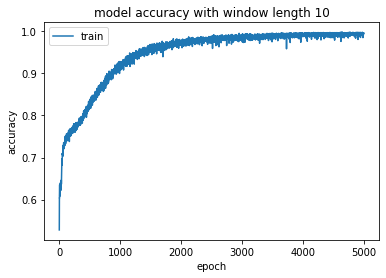

In [101]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

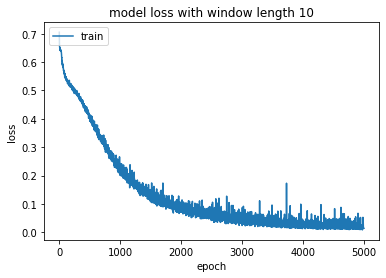

In [102]:
plt.plot(train_losses)
plt.title('model loss with window length 10')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [119]:
first_model.reset_states()
test_results = calc_pos_neg_rate(first_model.evaluate(x=test_generator, verbose=0))

In [120]:
first_model.reset_states()
train_results = calc_pos_neg_rate(first_model.evaluate(x=train_generator, verbose=0))

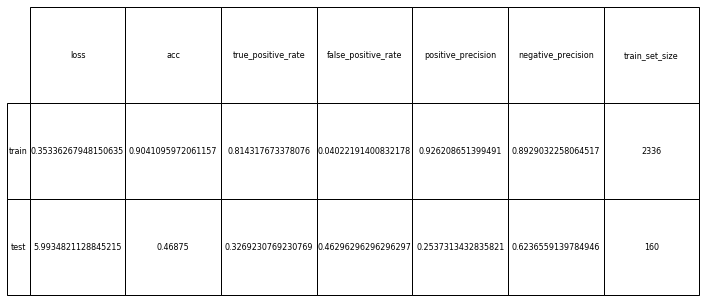

In [110]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [106]:
first_model.save(join(COLAB_DIR,'model_stateful.h5'))

Now, let's try window size of 20

In [125]:
train_generator, test_generator = generate_datasets_for_model(data, labels, \
                                                              stock_with_max_trading_days, \
                                                              training_start, training_end, \
                                                              testing_start, testing_end, window_in_days=20)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
second_model = build_model(None, optimizer, layers, metrics=metrics)
second_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (32, 64)                  17920     
_________________________________________________________________
dense_52 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_13 (Dropout)         (32, 32)                  0         
_________________________________________________________________
dense_53 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_13 (Batc (32, 16)                  64        
_________________________________________________________________
dense_54 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_55 (Dense)             (32, 1)                 

In [126]:
train_accs, train_losses = fit(second_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   2.048 seconds , loss : 0.697    accuracy : 0.577    
epoch 2
----------->> Epoch 1/1   0.612 seconds , loss : 0.660    accuracy : 0.615    
epoch 3
----------->> Epoch 1/1   0.555 seconds , loss : 0.661    accuracy : 0.602    
epoch 4
----------->> Epoch 1/1   0.446 seconds , loss : 0.655    accuracy : 0.610    
epoch 5
----------->> Epoch 1/1   0.495 seconds , loss : 0.655    accuracy : 0.609    
epoch 6
----------->> Epoch 1/1   0.338 seconds , loss : 0.648    accuracy : 0.616    
epoch 7
----------->> Epoch 1/1   0.340 seconds , loss : 0.646    accuracy : 0.625    
epoch 8
----------->> Epoch 1/1   0.383 seconds , loss : 0.644    accuracy : 0.637    
epoch 9
----------->> Epoch 1/1   0.400 seconds , loss : 0.645    accuracy : 0.627    
epoch 10
----------->> Epoch 1/1   0.552 seconds , loss : 0.645    accuracy : 0.626    
epoch 11
----------->> Epoch 1/1   0.608 seconds , loss : 0.644    accuracy : 0.633    
epoch 12
----------->> Epoch 1/1   0.491 

----------->> Epoch 1/1   0.236 seconds , loss : 0.491    accuracy : 0.773    
epoch 187
----------->> Epoch 1/1   0.277 seconds , loss : 0.490    accuracy : 0.775    
epoch 188
----------->> Epoch 1/1   0.247 seconds , loss : 0.486    accuracy : 0.783    
epoch 189
----------->> Epoch 1/1   0.441 seconds , loss : 0.490    accuracy : 0.777    
epoch 190
----------->> Epoch 1/1   0.268 seconds , loss : 0.494    accuracy : 0.771    
epoch 191
----------->> Epoch 1/1   0.500 seconds , loss : 0.480    accuracy : 0.775    
epoch 192
----------->> Epoch 1/1   0.327 seconds , loss : 0.488    accuracy : 0.774    
epoch 193
----------->> Epoch 1/1   0.376 seconds , loss : 0.486    accuracy : 0.780    
epoch 194
----------->> Epoch 1/1   0.425 seconds , loss : 0.484    accuracy : 0.777    
epoch 195
----------->> Epoch 1/1   0.304 seconds , loss : 0.483    accuracy : 0.781    
epoch 196
----------->> Epoch 1/1   0.287 seconds , loss : 0.495    accuracy : 0.770    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.324 seconds , loss : 0.385    accuracy : 0.826    
epoch 371
----------->> Epoch 1/1   0.321 seconds , loss : 0.381    accuracy : 0.837    
epoch 372
----------->> Epoch 1/1   0.604 seconds , loss : 0.364    accuracy : 0.848    
epoch 373
----------->> Epoch 1/1   0.533 seconds , loss : 0.377    accuracy : 0.848    
epoch 374
----------->> Epoch 1/1   0.326 seconds , loss : 0.381    accuracy : 0.834    
epoch 375
----------->> Epoch 1/1   0.323 seconds , loss : 0.386    accuracy : 0.838    
epoch 376
----------->> Epoch 1/1   0.224 seconds , loss : 0.371    accuracy : 0.845    
epoch 377
----------->> Epoch 1/1   0.241 seconds , loss : 0.372    accuracy : 0.842    
epoch 378
----------->> Epoch 1/1   0.461 seconds , loss : 0.361    accuracy : 0.850    
epoch 379
----------->> Epoch 1/1   0.269 seconds , loss : 0.376    accuracy : 0.850    
epoch 380
----------->> Epoch 1/1   0.234 seconds , loss : 0.365    accuracy : 0.850    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.449 seconds , loss : 0.262    accuracy : 0.898    
epoch 555
----------->> Epoch 1/1   0.450 seconds , loss : 0.265    accuracy : 0.896    
epoch 556
----------->> Epoch 1/1   0.339 seconds , loss : 0.267    accuracy : 0.893    
epoch 557
----------->> Epoch 1/1   0.325 seconds , loss : 0.260    accuracy : 0.900    
epoch 558
----------->> Epoch 1/1   0.283 seconds , loss : 0.254    accuracy : 0.897    
epoch 559
----------->> Epoch 1/1   0.388 seconds , loss : 0.257    accuracy : 0.898    
epoch 560
----------->> Epoch 1/1   0.293 seconds , loss : 0.264    accuracy : 0.901    
epoch 561
----------->> Epoch 1/1   0.356 seconds , loss : 0.269    accuracy : 0.896    
epoch 562
----------->> Epoch 1/1   0.523 seconds , loss : 0.257    accuracy : 0.899    
epoch 563
----------->> Epoch 1/1   0.273 seconds , loss : 0.272    accuracy : 0.890    
epoch 564
----------->> Epoch 1/1   0.422 seconds , loss : 0.266    accuracy : 0.898    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.369 seconds , loss : 0.186    accuracy : 0.932    
epoch 739
----------->> Epoch 1/1   0.367 seconds , loss : 0.186    accuracy : 0.931    
epoch 740
----------->> Epoch 1/1   0.312 seconds , loss : 0.187    accuracy : 0.934    
epoch 741
----------->> Epoch 1/1   0.461 seconds , loss : 0.211    accuracy : 0.920    
epoch 742
----------->> Epoch 1/1   0.454 seconds , loss : 0.200    accuracy : 0.929    
epoch 743
----------->> Epoch 1/1   0.354 seconds , loss : 0.173    accuracy : 0.942    
epoch 744
----------->> Epoch 1/1   0.251 seconds , loss : 0.181    accuracy : 0.939    
epoch 745
----------->> Epoch 1/1   0.365 seconds , loss : 0.176    accuracy : 0.932    
epoch 746
----------->> Epoch 1/1   0.388 seconds , loss : 0.181    accuracy : 0.933    
epoch 747
----------->> Epoch 1/1   0.242 seconds , loss : 0.180    accuracy : 0.937    
epoch 748
----------->> Epoch 1/1   0.239 seconds , loss : 0.180    accuracy : 0.933    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.693 seconds , loss : 0.137    accuracy : 0.953    
epoch 923
----------->> Epoch 1/1   0.472 seconds , loss : 0.134    accuracy : 0.957    
epoch 924
----------->> Epoch 1/1   0.385 seconds , loss : 0.157    accuracy : 0.949    
epoch 925
----------->> Epoch 1/1   0.341 seconds , loss : 0.147    accuracy : 0.949    
epoch 926
----------->> Epoch 1/1   0.423 seconds , loss : 0.145    accuracy : 0.952    
epoch 927
----------->> Epoch 1/1   0.362 seconds , loss : 0.130    accuracy : 0.958    
epoch 928
----------->> Epoch 1/1   0.403 seconds , loss : 0.127    accuracy : 0.955    
epoch 929
----------->> Epoch 1/1   0.531 seconds , loss : 0.136    accuracy : 0.950    
epoch 930
----------->> Epoch 1/1   0.327 seconds , loss : 0.151    accuracy : 0.952    
epoch 931
----------->> Epoch 1/1   0.409 seconds , loss : 0.123    accuracy : 0.958    
epoch 932
----------->> Epoch 1/1   0.433 seconds , loss : 0.143    accuracy : 0.954    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.469 seconds , loss : 0.101    accuracy : 0.961    
epoch 1015
----------->> Epoch 1/1   0.485 seconds , loss : 0.121    accuracy : 0.960    
epoch 1016
----------->> Epoch 1/1   0.480 seconds , loss : 0.110    accuracy : 0.964    
epoch 1017
----------->> Epoch 1/1   0.473 seconds , loss : 0.114    accuracy : 0.965    
epoch 1018
----------->> Epoch 1/1   0.471 seconds , loss : 0.129    accuracy : 0.954    
epoch 1019
----------->> Epoch 1/1   0.432 seconds , loss : 0.127    accuracy : 0.956    
epoch 1020
----------->> Epoch 1/1   0.478 seconds , loss : 0.107    accuracy : 0.961    
epoch 1021
----------->> Epoch 1/1   0.623 seconds , loss : 0.182    accuracy : 0.947    
epoch 1022
----------->> Epoch 1/1   0.491 seconds , loss : 0.165    accuracy : 0.947    
epoch 1023
----------->> Epoch 1/1   0.527 seconds , loss : 0.110    accuracy : 0.964    
epoch 1024
----------->> Epoch 1/1   0.498 seconds , loss : 0.105    accuracy : 0.970    
epoch 1025
----------

----------->> Epoch 1/1   0.454 seconds , loss : 0.072    accuracy : 0.982    
epoch 1197
----------->> Epoch 1/1   0.324 seconds , loss : 0.093    accuracy : 0.969    
epoch 1198
----------->> Epoch 1/1   0.467 seconds , loss : 0.133    accuracy : 0.959    
epoch 1199
----------->> Epoch 1/1   0.387 seconds , loss : 0.139    accuracy : 0.960    
epoch 1200
----------->> Epoch 1/1   0.544 seconds , loss : 0.106    accuracy : 0.966    
epoch 1201
----------->> Epoch 1/1   0.369 seconds , loss : 0.066    accuracy : 0.981    
epoch 1202
----------->> Epoch 1/1   0.335 seconds , loss : 0.083    accuracy : 0.970    
epoch 1203
----------->> Epoch 1/1   0.633 seconds , loss : 0.094    accuracy : 0.973    
epoch 1204
----------->> Epoch 1/1   0.603 seconds , loss : 0.107    accuracy : 0.965    
epoch 1205
----------->> Epoch 1/1   0.516 seconds , loss : 0.111    accuracy : 0.961    
epoch 1206
----------->> Epoch 1/1   0.329 seconds , loss : 0.119    accuracy : 0.960    
epoch 1207
----------

----------->> Epoch 1/1   0.684 seconds , loss : 0.096    accuracy : 0.969    
epoch 1379
----------->> Epoch 1/1   0.394 seconds , loss : 0.064    accuracy : 0.979    
epoch 1380
----------->> Epoch 1/1   0.529 seconds , loss : 0.063    accuracy : 0.979    
epoch 1381
----------->> Epoch 1/1   0.551 seconds , loss : 0.081    accuracy : 0.974    
epoch 1382
----------->> Epoch 1/1   0.588 seconds , loss : 0.076    accuracy : 0.976    
epoch 1383
----------->> Epoch 1/1   0.504 seconds , loss : 0.064    accuracy : 0.977    
epoch 1384
----------->> Epoch 1/1   0.567 seconds , loss : 0.057    accuracy : 0.982    
epoch 1385
----------->> Epoch 1/1   0.562 seconds , loss : 0.069    accuracy : 0.979    
epoch 1386
----------->> Epoch 1/1   0.559 seconds , loss : 0.077    accuracy : 0.977    
epoch 1387
----------->> Epoch 1/1   0.408 seconds , loss : 0.089    accuracy : 0.975    
epoch 1388
----------->> Epoch 1/1   0.548 seconds , loss : 0.086    accuracy : 0.974    
epoch 1389
----------

----------->> Epoch 1/1   0.411 seconds , loss : 0.051    accuracy : 0.984    
epoch 1561
----------->> Epoch 1/1   0.359 seconds , loss : 0.046    accuracy : 0.988    
epoch 1562
----------->> Epoch 1/1   0.398 seconds , loss : 0.044    accuracy : 0.987    
epoch 1563
----------->> Epoch 1/1   0.413 seconds , loss : 0.052    accuracy : 0.984    
epoch 1564
----------->> Epoch 1/1   0.607 seconds , loss : 0.036    accuracy : 0.986    
epoch 1565
----------->> Epoch 1/1   0.481 seconds , loss : 0.038    accuracy : 0.989    
epoch 1566
----------->> Epoch 1/1   0.379 seconds , loss : 0.040    accuracy : 0.988    
epoch 1567
----------->> Epoch 1/1   0.390 seconds , loss : 0.037    accuracy : 0.989    
epoch 1568
----------->> Epoch 1/1   0.356 seconds , loss : 0.032    accuracy : 0.988    
epoch 1569
----------->> Epoch 1/1   0.393 seconds , loss : 0.031    accuracy : 0.991    
epoch 1570
----------->> Epoch 1/1   0.395 seconds , loss : 0.048    accuracy : 0.982    
epoch 1571
----------

----------->> Epoch 1/1   0.631 seconds , loss : 0.039    accuracy : 0.989    
epoch 1743
----------->> Epoch 1/1   0.460 seconds , loss : 0.044    accuracy : 0.988    
epoch 1744
----------->> Epoch 1/1   0.562 seconds , loss : 0.036    accuracy : 0.988    
epoch 1745
----------->> Epoch 1/1   0.356 seconds , loss : 0.082    accuracy : 0.979    
epoch 1746
----------->> Epoch 1/1   0.340 seconds , loss : 0.052    accuracy : 0.982    
epoch 1747
----------->> Epoch 1/1   0.516 seconds , loss : 0.034    accuracy : 0.988    
epoch 1748
----------->> Epoch 1/1   0.475 seconds , loss : 0.039    accuracy : 0.985    
epoch 1749
----------->> Epoch 1/1   0.387 seconds , loss : 0.049    accuracy : 0.982    
epoch 1750
----------->> Epoch 1/1   0.675 seconds , loss : 0.047    accuracy : 0.984    
epoch 1751
----------->> Epoch 1/1   0.632 seconds , loss : 0.167    accuracy : 0.964    
epoch 1752
----------->> Epoch 1/1   0.499 seconds , loss : 0.052    accuracy : 0.982    
epoch 1753
----------

----------->> Epoch 1/1   0.313 seconds , loss : 0.012    accuracy : 0.997    
epoch 1925
----------->> Epoch 1/1   0.541 seconds , loss : 0.019    accuracy : 0.995    
epoch 1926
----------->> Epoch 1/1   0.609 seconds , loss : 0.034    accuracy : 0.989    
epoch 1927
----------->> Epoch 1/1   0.507 seconds , loss : 0.084    accuracy : 0.976    
epoch 1928
----------->> Epoch 1/1   0.671 seconds , loss : 0.032    accuracy : 0.988    
epoch 1929
----------->> Epoch 1/1   0.778 seconds , loss : 0.023    accuracy : 0.994    
epoch 1930
----------->> Epoch 1/1   0.573 seconds , loss : 0.020    accuracy : 0.993    
epoch 1931
----------->> Epoch 1/1   0.519 seconds , loss : 0.018    accuracy : 0.993    
epoch 1932
----------->> Epoch 1/1   0.527 seconds , loss : 0.017    accuracy : 0.994    
epoch 1933
----------->> Epoch 1/1   0.581 seconds , loss : 0.042    accuracy : 0.988    
epoch 1934
----------->> Epoch 1/1   0.481 seconds , loss : 0.052    accuracy : 0.982    
epoch 1935
----------

----------->> Epoch 1/1   0.555 seconds , loss : 0.018    accuracy : 0.994    
epoch 2107
----------->> Epoch 1/1   0.302 seconds , loss : 0.020    accuracy : 0.994    
epoch 2108
----------->> Epoch 1/1   0.528 seconds , loss : 0.064    accuracy : 0.981    
epoch 2109
----------->> Epoch 1/1   0.534 seconds , loss : 0.100    accuracy : 0.969    
epoch 2110
----------->> Epoch 1/1   0.355 seconds , loss : 0.113    accuracy : 0.968    
epoch 2111
----------->> Epoch 1/1   0.329 seconds , loss : 0.070    accuracy : 0.975    
epoch 2112
----------->> Epoch 1/1   0.275 seconds , loss : 0.036    accuracy : 0.988    
epoch 2113
----------->> Epoch 1/1   0.446 seconds , loss : 0.033    accuracy : 0.988    
epoch 2114
----------->> Epoch 1/1   0.369 seconds , loss : 0.019    accuracy : 0.994    
epoch 2115
----------->> Epoch 1/1   0.416 seconds , loss : 0.012    accuracy : 0.998    
epoch 2116
----------->> Epoch 1/1   0.346 seconds , loss : 0.014    accuracy : 0.997    
epoch 2117
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.009    accuracy : 0.999    
epoch 2289
----------->> Epoch 1/1   0.300 seconds , loss : 0.011    accuracy : 0.997    
epoch 2290
----------->> Epoch 1/1   0.306 seconds , loss : 0.012    accuracy : 0.996    
epoch 2291
----------->> Epoch 1/1   0.269 seconds , loss : 0.069    accuracy : 0.985    
epoch 2292
----------->> Epoch 1/1   0.530 seconds , loss : 0.086    accuracy : 0.976    
epoch 2293
----------->> Epoch 1/1   0.594 seconds , loss : 0.044    accuracy : 0.988    
epoch 2294
----------->> Epoch 1/1   0.327 seconds , loss : 0.022    accuracy : 0.993    
epoch 2295
----------->> Epoch 1/1   0.549 seconds , loss : 0.015    accuracy : 0.997    
epoch 2296
----------->> Epoch 1/1   0.586 seconds , loss : 0.012    accuracy : 0.997    
epoch 2297
----------->> Epoch 1/1   0.441 seconds , loss : 0.010    accuracy : 0.997    
epoch 2298
----------->> Epoch 1/1   0.339 seconds , loss : 0.011    accuracy : 0.996    
epoch 2299
----------

----------->> Epoch 1/1   0.356 seconds , loss : 0.008    accuracy : 0.998    
epoch 2471
----------->> Epoch 1/1   0.570 seconds , loss : 0.008    accuracy : 0.997    
epoch 2472
----------->> Epoch 1/1   0.392 seconds , loss : 0.009    accuracy : 0.997    
epoch 2473
----------->> Epoch 1/1   0.718 seconds , loss : 0.011    accuracy : 0.997    
epoch 2474
----------->> Epoch 1/1   1.011 seconds , loss : 0.009    accuracy : 0.998    
epoch 2475
----------->> Epoch 1/1   1.116 seconds , loss : 0.009    accuracy : 0.998    
epoch 2476
----------->> Epoch 1/1   1.030 seconds , loss : 0.009    accuracy : 0.999    
epoch 2477
----------->> Epoch 1/1   0.448 seconds , loss : 0.009    accuracy : 0.998    
epoch 2478
----------->> Epoch 1/1   0.371 seconds , loss : 0.009    accuracy : 0.997    
epoch 2479
----------->> Epoch 1/1   0.298 seconds , loss : 0.010    accuracy : 0.997    
epoch 2480
----------->> Epoch 1/1   0.563 seconds , loss : 0.013    accuracy : 0.996    
epoch 2481
----------

----------->> Epoch 1/1   0.992 seconds , loss : 0.021    accuracy : 0.994    
epoch 2653
----------->> Epoch 1/1   0.767 seconds , loss : 0.016    accuracy : 0.996    
epoch 2654
----------->> Epoch 1/1   0.770 seconds , loss : 0.010    accuracy : 0.997    
epoch 2655
----------->> Epoch 1/1   0.852 seconds , loss : 0.011    accuracy : 0.997    
epoch 2656
----------->> Epoch 1/1   0.843 seconds , loss : 0.009    accuracy : 0.997    
epoch 2657
----------->> Epoch 1/1   0.632 seconds , loss : 0.009    accuracy : 0.997    
epoch 2658
----------->> Epoch 1/1   0.640 seconds , loss : 0.009    accuracy : 0.997    
epoch 2659
----------->> Epoch 1/1   0.540 seconds , loss : 0.008    accuracy : 0.997    
epoch 2660
----------->> Epoch 1/1   0.322 seconds , loss : 0.007    accuracy : 0.998    
epoch 2661
----------->> Epoch 1/1   0.380 seconds , loss : 0.007    accuracy : 0.998    
epoch 2662
----------->> Epoch 1/1   0.596 seconds , loss : 0.007    accuracy : 0.997    
epoch 2663
----------

----------->> Epoch 1/1   0.287 seconds , loss : 0.008    accuracy : 0.998    
epoch 2835
----------->> Epoch 1/1   0.278 seconds , loss : 0.006    accuracy : 0.999    
epoch 2836
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.998    
epoch 2837
----------->> Epoch 1/1   0.312 seconds , loss : 0.007    accuracy : 0.999    
epoch 2838
----------->> Epoch 1/1   0.274 seconds , loss : 0.007    accuracy : 0.998    
epoch 2839
----------->> Epoch 1/1   0.278 seconds , loss : 0.010    accuracy : 0.997    
epoch 2840
----------->> Epoch 1/1   0.244 seconds , loss : 0.008    accuracy : 0.998    
epoch 2841
----------->> Epoch 1/1   0.284 seconds , loss : 0.007    accuracy : 0.997    
epoch 2842
----------->> Epoch 1/1   0.239 seconds , loss : 0.009    accuracy : 0.998    
epoch 2843
----------->> Epoch 1/1   0.251 seconds , loss : 0.038    accuracy : 0.991    
epoch 2844
----------->> Epoch 1/1   0.242 seconds , loss : 0.173    accuracy : 0.963    
epoch 2845
----------

----------->> Epoch 1/1   0.289 seconds , loss : 0.008    accuracy : 0.998    
epoch 3017
----------->> Epoch 1/1   0.272 seconds , loss : 0.008    accuracy : 0.997    
epoch 3018
----------->> Epoch 1/1   0.297 seconds , loss : 0.007    accuracy : 0.998    
epoch 3019
----------->> Epoch 1/1   0.281 seconds , loss : 0.009    accuracy : 0.998    
epoch 3020
----------->> Epoch 1/1   0.300 seconds , loss : 0.010    accuracy : 0.996    
epoch 3021
----------->> Epoch 1/1   0.354 seconds , loss : 0.009    accuracy : 0.998    
epoch 3022
----------->> Epoch 1/1   0.333 seconds , loss : 0.007    accuracy : 0.997    
epoch 3023
----------->> Epoch 1/1   0.275 seconds , loss : 0.008    accuracy : 0.998    
epoch 3024
----------->> Epoch 1/1   0.265 seconds , loss : 0.008    accuracy : 0.998    
epoch 3025
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.997    
epoch 3026
----------->> Epoch 1/1   0.271 seconds , loss : 0.008    accuracy : 0.997    
epoch 3027
----------

----------->> Epoch 1/1   0.252 seconds , loss : 0.012    accuracy : 0.997    
epoch 3199
----------->> Epoch 1/1   0.250 seconds , loss : 0.009    accuracy : 0.997    
epoch 3200
----------->> Epoch 1/1   0.254 seconds , loss : 0.008    accuracy : 0.998    
epoch 3201
----------->> Epoch 1/1   0.253 seconds , loss : 0.008    accuracy : 0.998    
epoch 3202
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.998    
epoch 3203
----------->> Epoch 1/1   0.252 seconds , loss : 0.008    accuracy : 0.998    
epoch 3204
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.998    
epoch 3205
----------->> Epoch 1/1   0.308 seconds , loss : 0.009    accuracy : 0.998    
epoch 3206
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.998    
epoch 3207
----------->> Epoch 1/1   0.301 seconds , loss : 0.008    accuracy : 0.997    
epoch 3208
----------->> Epoch 1/1   0.296 seconds , loss : 0.007    accuracy : 0.998    
epoch 3209
----------

----------->> Epoch 1/1   0.301 seconds , loss : 0.018    accuracy : 0.995    
epoch 3381
----------->> Epoch 1/1   0.300 seconds , loss : 0.014    accuracy : 0.995    
epoch 3382
----------->> Epoch 1/1   0.309 seconds , loss : 0.023    accuracy : 0.993    
epoch 3383
----------->> Epoch 1/1   0.307 seconds , loss : 0.058    accuracy : 0.988    
epoch 3384
----------->> Epoch 1/1   0.296 seconds , loss : 0.019    accuracy : 0.993    
epoch 3385
----------->> Epoch 1/1   0.304 seconds , loss : 0.032    accuracy : 0.990    
epoch 3386
----------->> Epoch 1/1   0.303 seconds , loss : 0.023    accuracy : 0.992    
epoch 3387
----------->> Epoch 1/1   0.293 seconds , loss : 0.016    accuracy : 0.994    
epoch 3388
----------->> Epoch 1/1   0.293 seconds , loss : 0.009    accuracy : 0.998    
epoch 3389
----------->> Epoch 1/1   0.294 seconds , loss : 0.015    accuracy : 0.995    
epoch 3390
----------->> Epoch 1/1   0.275 seconds , loss : 0.046    accuracy : 0.988    
epoch 3391
----------

----------->> Epoch 1/1   0.324 seconds , loss : 0.008    accuracy : 0.997    
epoch 3563
----------->> Epoch 1/1   0.316 seconds , loss : 0.008    accuracy : 0.998    
epoch 3564
----------->> Epoch 1/1   0.311 seconds , loss : 0.008    accuracy : 0.997    
epoch 3565
----------->> Epoch 1/1   0.317 seconds , loss : 0.008    accuracy : 0.998    
epoch 3566
----------->> Epoch 1/1   0.263 seconds , loss : 0.008    accuracy : 0.997    
epoch 3567
----------->> Epoch 1/1   0.254 seconds , loss : 0.027    accuracy : 0.993    
epoch 3568
----------->> Epoch 1/1   0.252 seconds , loss : 0.017    accuracy : 0.995    
epoch 3569
----------->> Epoch 1/1   0.252 seconds , loss : 0.019    accuracy : 0.994    
epoch 3570
----------->> Epoch 1/1   0.310 seconds , loss : 0.011    accuracy : 0.997    
epoch 3571
----------->> Epoch 1/1   0.255 seconds , loss : 0.012    accuracy : 0.996    
epoch 3572
----------->> Epoch 1/1   0.253 seconds , loss : 0.024    accuracy : 0.994    
epoch 3573
----------

----------->> Epoch 1/1   0.280 seconds , loss : 0.006    accuracy : 0.998    
epoch 3745
----------->> Epoch 1/1   0.285 seconds , loss : 0.006    accuracy : 0.998    
epoch 3746
----------->> Epoch 1/1   0.293 seconds , loss : 0.007    accuracy : 0.998    
epoch 3747
----------->> Epoch 1/1   0.282 seconds , loss : 0.006    accuracy : 0.997    
epoch 3748
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.996    
epoch 3749
----------->> Epoch 1/1   0.282 seconds , loss : 0.006    accuracy : 0.998    
epoch 3750
----------->> Epoch 1/1   0.281 seconds , loss : 0.007    accuracy : 0.998    
epoch 3751
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.997    
epoch 3752
----------->> Epoch 1/1   0.296 seconds , loss : 0.007    accuracy : 0.998    
epoch 3753
----------->> Epoch 1/1   0.285 seconds , loss : 0.007    accuracy : 0.998    
epoch 3754
----------->> Epoch 1/1   0.279 seconds , loss : 0.006    accuracy : 0.998    
epoch 3755
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.006    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.998    
epoch 3928
----------->> Epoch 1/1   0.241 seconds , loss : 0.007    accuracy : 0.998    
epoch 3929
----------->> Epoch 1/1   0.242 seconds , loss : 0.006    accuracy : 0.998    
epoch 3930
----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.997    
epoch 3931
----------->> Epoch 1/1   0.241 seconds , loss : 0.006    accuracy : 0.998    
epoch 3932
----------->> Epoch 1/1   0.242 seconds , loss : 0.007    accuracy : 0.997    
epoch 3933
----------->> Epoch 1/1   0.244 seconds , loss : 0.006    accuracy : 0.998    
epoch 3934
----------->> Epoch 1/1   0.242 seconds , loss : 0.006    accuracy : 0.998    
epoch 3935
----------->> Epoch 1/1   0.243 seconds , loss : 0.008    accuracy : 0.998    
epoch 3936
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 3937
----------

----------->> Epoch 1/1   0.308 seconds , loss : 0.009    accuracy : 0.997    
epoch 4109
----------->> Epoch 1/1   0.277 seconds , loss : 0.007    accuracy : 0.998    
epoch 4110
----------->> Epoch 1/1   0.283 seconds , loss : 0.007    accuracy : 0.998    
epoch 4111
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.998    
epoch 4112
----------->> Epoch 1/1   0.284 seconds , loss : 0.005    accuracy : 0.999    
epoch 4113
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.997    
epoch 4114
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.998    
epoch 4115
----------->> Epoch 1/1   0.294 seconds , loss : 0.009    accuracy : 0.998    
epoch 4116
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.998    
epoch 4117
----------->> Epoch 1/1   0.308 seconds , loss : 0.004    accuracy : 0.999    
epoch 4118
----------->> Epoch 1/1   0.234 seconds , loss : 0.005    accuracy : 0.998    
epoch 4119
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.014    accuracy : 0.996    
epoch 4291
----------->> Epoch 1/1   0.249 seconds , loss : 0.015    accuracy : 0.995    
epoch 4292
----------->> Epoch 1/1   0.301 seconds , loss : 0.010    accuracy : 0.998    
epoch 4293
----------->> Epoch 1/1   0.286 seconds , loss : 0.009    accuracy : 0.998    
epoch 4294
----------->> Epoch 1/1   0.295 seconds , loss : 0.008    accuracy : 0.997    
epoch 4295
----------->> Epoch 1/1   0.247 seconds , loss : 0.007    accuracy : 0.998    
epoch 4296
----------->> Epoch 1/1   0.293 seconds , loss : 0.007    accuracy : 0.998    
epoch 4297
----------->> Epoch 1/1   0.288 seconds , loss : 0.007    accuracy : 0.998    
epoch 4298
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.998    
epoch 4299
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.997    
epoch 4300
----------->> Epoch 1/1   0.297 seconds , loss : 0.007    accuracy : 0.998    
epoch 4301
----------

----------->> Epoch 1/1   0.303 seconds , loss : 0.005    accuracy : 0.998    
epoch 4473
----------->> Epoch 1/1   0.300 seconds , loss : 0.007    accuracy : 0.998    
epoch 4474
----------->> Epoch 1/1   0.289 seconds , loss : 0.007    accuracy : 0.998    
epoch 4475
----------->> Epoch 1/1   0.281 seconds , loss : 0.007    accuracy : 0.998    
epoch 4476
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.256 seconds , loss : 0.006    accuracy : 0.998    
epoch 4478
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.997    
epoch 4479
----------->> Epoch 1/1   0.250 seconds , loss : 0.008    accuracy : 0.997    
epoch 4480
----------->> Epoch 1/1   0.251 seconds , loss : 0.040    accuracy : 0.989    
epoch 4481
----------->> Epoch 1/1   0.285 seconds , loss : 0.046    accuracy : 0.987    
epoch 4482
----------->> Epoch 1/1   0.286 seconds , loss : 0.040    accuracy : 0.986    
epoch 4483
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.007    accuracy : 0.998    
epoch 4655
----------->> Epoch 1/1   0.247 seconds , loss : 0.006    accuracy : 0.997    
epoch 4656
----------->> Epoch 1/1   0.246 seconds , loss : 0.008    accuracy : 0.997    
epoch 4657
----------->> Epoch 1/1   0.246 seconds , loss : 0.007    accuracy : 0.998    
epoch 4658
----------->> Epoch 1/1   0.247 seconds , loss : 0.007    accuracy : 0.997    
epoch 4659
----------->> Epoch 1/1   0.247 seconds , loss : 0.013    accuracy : 0.997    
epoch 4660
----------->> Epoch 1/1   0.241 seconds , loss : 0.152    accuracy : 0.973    
epoch 4661
----------->> Epoch 1/1   0.247 seconds , loss : 0.045    accuracy : 0.986    
epoch 4662
----------->> Epoch 1/1   0.247 seconds , loss : 0.019    accuracy : 0.995    
epoch 4663
----------->> Epoch 1/1   0.242 seconds , loss : 0.015    accuracy : 0.995    
epoch 4664
----------->> Epoch 1/1   0.244 seconds , loss : 0.011    accuracy : 0.997    
epoch 4665
----------

----------->> Epoch 1/1   0.240 seconds , loss : 0.026    accuracy : 0.992    
epoch 4837
----------->> Epoch 1/1   0.243 seconds , loss : 0.035    accuracy : 0.990    
epoch 4838
----------->> Epoch 1/1   0.243 seconds , loss : 0.009    accuracy : 0.998    
epoch 4839
----------->> Epoch 1/1   0.245 seconds , loss : 0.007    accuracy : 0.997    
epoch 4840
----------->> Epoch 1/1   0.240 seconds , loss : 0.009    accuracy : 0.997    
epoch 4841
----------->> Epoch 1/1   0.244 seconds , loss : 0.006    accuracy : 0.998    
epoch 4842
----------->> Epoch 1/1   0.243 seconds , loss : 0.005    accuracy : 0.998    
epoch 4843
----------->> Epoch 1/1   0.244 seconds , loss : 0.007    accuracy : 0.998    
epoch 4844
----------->> Epoch 1/1   0.241 seconds , loss : 0.006    accuracy : 0.998    
epoch 4845
----------->> Epoch 1/1   0.243 seconds , loss : 0.006    accuracy : 0.998    
epoch 4846
----------->> Epoch 1/1   0.246 seconds , loss : 0.005    accuracy : 0.998    
epoch 4847
----------

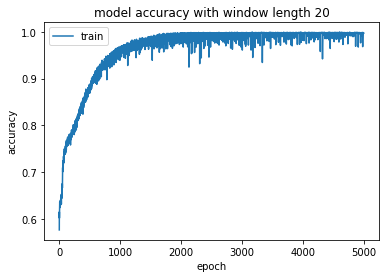

In [127]:
plt.plot(train_accs)
plt.title('model accuracy with window length 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

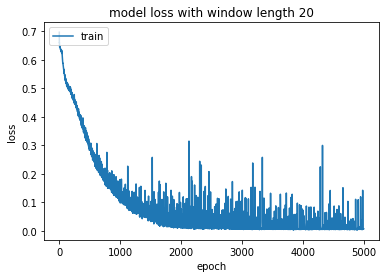

In [128]:
plt.plot(train_losses)
plt.title('model loss with window length 20')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [129]:
second_model.reset_states()
test_results = calc_pos_neg_rate(second_model.evaluate(x=test_generator, verbose=0))

In [130]:
second_model.reset_states()
train_results = calc_pos_neg_rate(second_model.evaluate(x=train_generator, verbose=0))

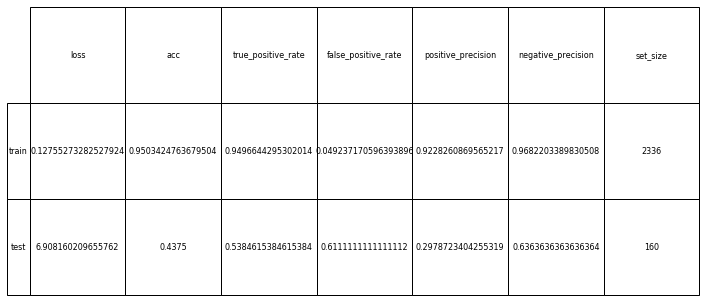

In [131]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [144]:
second_model.save(join(COLAB_DIR,'model_stateful_20.h5'))

Now, let's try window size of 30

In [41]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_max_trading_days, training_start, training_end, testing_start, testing_end, window_in_days=30)

layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
third_model = build_model(None, optimizer, layers, metrics=metrics)
third_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_8 (Dense)              (32, 32)                  2080      
_________________________________________________________________
dropout_2 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_9 (Dense)              (32, 16)                  528       
_________________________________________________________________
batch_normalization_2 (Batch (32, 16)                  64        
_________________________________________________________________
dense_10 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_11 (Dense)             (32, 1)                  

In [42]:
train_accs, train_losses = fit(third_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.664 seconds , loss : 0.707    accuracy : 0.574    
epoch 2
----------->> Epoch 1/1   0.264 seconds , loss : 0.670    accuracy : 0.610    
epoch 3
----------->> Epoch 1/1   0.254 seconds , loss : 0.662    accuracy : 0.607    
epoch 4
----------->> Epoch 1/1   0.256 seconds , loss : 0.656    accuracy : 0.617    
epoch 5
----------->> Epoch 1/1   0.255 seconds , loss : 0.661    accuracy : 0.617    
epoch 6
----------->> Epoch 1/1   0.268 seconds , loss : 0.654    accuracy : 0.615    
epoch 7
----------->> Epoch 1/1   0.254 seconds , loss : 0.651    accuracy : 0.618    
epoch 8
----------->> Epoch 1/1   0.250 seconds , loss : 0.646    accuracy : 0.616    
epoch 9
----------->> Epoch 1/1   0.251 seconds , loss : 0.650    accuracy : 0.622    
epoch 10
----------->> Epoch 1/1   0.253 seconds , loss : 0.646    accuracy : 0.626    
epoch 11
----------->> Epoch 1/1   0.248 seconds , loss : 0.646    accuracy : 0.632    
epoch 12
----------->> Epoch 1/1   0.257 

----------->> Epoch 1/1   0.260 seconds , loss : 0.474    accuracy : 0.787    
epoch 187
----------->> Epoch 1/1   0.251 seconds , loss : 0.469    accuracy : 0.789    
epoch 188
----------->> Epoch 1/1   0.243 seconds , loss : 0.479    accuracy : 0.782    
epoch 189
----------->> Epoch 1/1   0.251 seconds , loss : 0.472    accuracy : 0.791    
epoch 190
----------->> Epoch 1/1   0.253 seconds , loss : 0.475    accuracy : 0.787    
epoch 191
----------->> Epoch 1/1   0.257 seconds , loss : 0.471    accuracy : 0.788    
epoch 192
----------->> Epoch 1/1   0.251 seconds , loss : 0.469    accuracy : 0.787    
epoch 193
----------->> Epoch 1/1   0.251 seconds , loss : 0.461    accuracy : 0.789    
epoch 194
----------->> Epoch 1/1   0.256 seconds , loss : 0.463    accuracy : 0.792    
epoch 195
----------->> Epoch 1/1   0.251 seconds , loss : 0.455    accuracy : 0.794    
epoch 196
----------->> Epoch 1/1   0.244 seconds , loss : 0.471    accuracy : 0.790    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.257 seconds , loss : 0.329    accuracy : 0.865    
epoch 371
----------->> Epoch 1/1   0.257 seconds , loss : 0.350    accuracy : 0.858    
epoch 372
----------->> Epoch 1/1   0.263 seconds , loss : 0.341    accuracy : 0.856    
epoch 373
----------->> Epoch 1/1   0.255 seconds , loss : 0.344    accuracy : 0.857    
epoch 374
----------->> Epoch 1/1   0.257 seconds , loss : 0.347    accuracy : 0.857    
epoch 375
----------->> Epoch 1/1   0.261 seconds , loss : 0.338    accuracy : 0.865    
epoch 376
----------->> Epoch 1/1   0.255 seconds , loss : 0.335    accuracy : 0.864    
epoch 377
----------->> Epoch 1/1   0.259 seconds , loss : 0.355    accuracy : 0.853    
epoch 378
----------->> Epoch 1/1   0.261 seconds , loss : 0.343    accuracy : 0.859    
epoch 379
----------->> Epoch 1/1   0.256 seconds , loss : 0.336    accuracy : 0.865    
epoch 380
----------->> Epoch 1/1   0.255 seconds , loss : 0.341    accuracy : 0.858    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.255 seconds , loss : 0.219    accuracy : 0.920    
epoch 555
----------->> Epoch 1/1   0.258 seconds , loss : 0.215    accuracy : 0.920    
epoch 556
----------->> Epoch 1/1   0.260 seconds , loss : 0.229    accuracy : 0.916    
epoch 557
----------->> Epoch 1/1   0.257 seconds , loss : 0.248    accuracy : 0.899    
epoch 558
----------->> Epoch 1/1   0.259 seconds , loss : 0.231    accuracy : 0.916    
epoch 559
----------->> Epoch 1/1   0.257 seconds , loss : 0.213    accuracy : 0.922    
epoch 560
----------->> Epoch 1/1   0.261 seconds , loss : 0.223    accuracy : 0.916    
epoch 561
----------->> Epoch 1/1   0.256 seconds , loss : 0.243    accuracy : 0.910    
epoch 562
----------->> Epoch 1/1   0.262 seconds , loss : 0.227    accuracy : 0.909    
epoch 563
----------->> Epoch 1/1   0.256 seconds , loss : 0.244    accuracy : 0.912    
epoch 564
----------->> Epoch 1/1   0.257 seconds , loss : 0.254    accuracy : 0.903    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.259 seconds , loss : 0.148    accuracy : 0.947    
epoch 739
----------->> Epoch 1/1   0.260 seconds , loss : 0.166    accuracy : 0.940    
epoch 740
----------->> Epoch 1/1   0.262 seconds , loss : 0.134    accuracy : 0.952    
epoch 741
----------->> Epoch 1/1   0.261 seconds , loss : 0.142    accuracy : 0.949    
epoch 742
----------->> Epoch 1/1   0.258 seconds , loss : 0.151    accuracy : 0.949    
epoch 743
----------->> Epoch 1/1   0.257 seconds , loss : 0.141    accuracy : 0.954    
epoch 744
----------->> Epoch 1/1   0.257 seconds , loss : 0.145    accuracy : 0.951    
epoch 745
----------->> Epoch 1/1   0.258 seconds , loss : 0.132    accuracy : 0.958    
epoch 746
----------->> Epoch 1/1   0.262 seconds , loss : 0.127    accuracy : 0.958    
epoch 747
----------->> Epoch 1/1   0.256 seconds , loss : 0.162    accuracy : 0.944    
epoch 748
----------->> Epoch 1/1   0.258 seconds , loss : 0.138    accuracy : 0.953    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.258 seconds , loss : 0.108    accuracy : 0.961    
epoch 923
----------->> Epoch 1/1   0.257 seconds , loss : 0.095    accuracy : 0.970    
epoch 924
----------->> Epoch 1/1   0.257 seconds , loss : 0.113    accuracy : 0.964    
epoch 925
----------->> Epoch 1/1   0.256 seconds , loss : 0.133    accuracy : 0.955    
epoch 926
----------->> Epoch 1/1   0.261 seconds , loss : 0.125    accuracy : 0.956    
epoch 927
----------->> Epoch 1/1   0.257 seconds , loss : 0.244    accuracy : 0.932    
epoch 928
----------->> Epoch 1/1   0.257 seconds , loss : 0.214    accuracy : 0.926    
epoch 929
----------->> Epoch 1/1   0.256 seconds , loss : 0.112    accuracy : 0.963    
epoch 930
----------->> Epoch 1/1   0.257 seconds , loss : 0.087    accuracy : 0.973    
epoch 931
----------->> Epoch 1/1   0.258 seconds , loss : 0.085    accuracy : 0.976    
epoch 932
----------->> Epoch 1/1   0.255 seconds , loss : 0.091    accuracy : 0.972    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.258 seconds , loss : 0.094    accuracy : 0.970    
epoch 1015
----------->> Epoch 1/1   0.256 seconds , loss : 0.076    accuracy : 0.975    
epoch 1016
----------->> Epoch 1/1   0.260 seconds , loss : 0.074    accuracy : 0.981    
epoch 1017
----------->> Epoch 1/1   0.256 seconds , loss : 0.067    accuracy : 0.981    
epoch 1018
----------->> Epoch 1/1   0.257 seconds , loss : 0.080    accuracy : 0.975    
epoch 1019
----------->> Epoch 1/1   0.256 seconds , loss : 0.062    accuracy : 0.985    
epoch 1020
----------->> Epoch 1/1   0.262 seconds , loss : 0.058    accuracy : 0.982    
epoch 1021
----------->> Epoch 1/1   0.254 seconds , loss : 0.067    accuracy : 0.979    
epoch 1022
----------->> Epoch 1/1   0.258 seconds , loss : 0.109    accuracy : 0.966    
epoch 1023
----------->> Epoch 1/1   0.261 seconds , loss : 0.112    accuracy : 0.964    
epoch 1024
----------->> Epoch 1/1   0.256 seconds , loss : 0.097    accuracy : 0.970    
epoch 1025
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.063    accuracy : 0.985    
epoch 1197
----------->> Epoch 1/1   0.254 seconds , loss : 0.054    accuracy : 0.981    
epoch 1198
----------->> Epoch 1/1   0.255 seconds , loss : 0.054    accuracy : 0.983    
epoch 1199
----------->> Epoch 1/1   0.257 seconds , loss : 0.077    accuracy : 0.976    
epoch 1200
----------->> Epoch 1/1   0.263 seconds , loss : 0.094    accuracy : 0.973    
epoch 1201
----------->> Epoch 1/1   0.255 seconds , loss : 0.060    accuracy : 0.981    
epoch 1202
----------->> Epoch 1/1   0.257 seconds , loss : 0.054    accuracy : 0.983    
epoch 1203
----------->> Epoch 1/1   0.322 seconds , loss : 0.056    accuracy : 0.981    
epoch 1204
----------->> Epoch 1/1   0.271 seconds , loss : 0.032    accuracy : 0.988    
epoch 1205
----------->> Epoch 1/1   0.262 seconds , loss : 0.053    accuracy : 0.985    
epoch 1206
----------->> Epoch 1/1   0.256 seconds , loss : 0.074    accuracy : 0.977    
epoch 1207
----------

----------->> Epoch 1/1   0.262 seconds , loss : 0.033    accuracy : 0.991    
epoch 1379
----------->> Epoch 1/1   0.258 seconds , loss : 0.053    accuracy : 0.984    
epoch 1380
----------->> Epoch 1/1   0.261 seconds , loss : 0.039    accuracy : 0.988    
epoch 1381
----------->> Epoch 1/1   0.258 seconds , loss : 0.032    accuracy : 0.991    
epoch 1382
----------->> Epoch 1/1   0.258 seconds , loss : 0.030    accuracy : 0.991    
epoch 1383
----------->> Epoch 1/1   0.259 seconds , loss : 0.033    accuracy : 0.991    
epoch 1384
----------->> Epoch 1/1   0.259 seconds , loss : 0.035    accuracy : 0.989    
epoch 1385
----------->> Epoch 1/1   0.258 seconds , loss : 0.038    accuracy : 0.988    
epoch 1386
----------->> Epoch 1/1   0.257 seconds , loss : 0.077    accuracy : 0.976    
epoch 1387
----------->> Epoch 1/1   0.258 seconds , loss : 0.179    accuracy : 0.958    
epoch 1388
----------->> Epoch 1/1   0.260 seconds , loss : 0.092    accuracy : 0.970    
epoch 1389
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.035    accuracy : 0.989    
epoch 1561
----------->> Epoch 1/1   0.260 seconds , loss : 0.028    accuracy : 0.993    
epoch 1562
----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.996    
epoch 1563
----------->> Epoch 1/1   0.258 seconds , loss : 0.012    accuracy : 0.997    
epoch 1564
----------->> Epoch 1/1   0.257 seconds , loss : 0.017    accuracy : 0.996    
epoch 1565
----------->> Epoch 1/1   0.261 seconds , loss : 0.018    accuracy : 0.995    
epoch 1566
----------->> Epoch 1/1   0.257 seconds , loss : 0.024    accuracy : 0.993    
epoch 1567
----------->> Epoch 1/1   0.257 seconds , loss : 0.125    accuracy : 0.970    
epoch 1568
----------->> Epoch 1/1   0.258 seconds , loss : 0.105    accuracy : 0.969    
epoch 1569
----------->> Epoch 1/1   0.259 seconds , loss : 0.089    accuracy : 0.974    
epoch 1570
----------->> Epoch 1/1   0.261 seconds , loss : 0.077    accuracy : 0.982    
epoch 1571
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.030    accuracy : 0.989    
epoch 1743
----------->> Epoch 1/1   0.260 seconds , loss : 0.076    accuracy : 0.981    
epoch 1744
----------->> Epoch 1/1   0.260 seconds , loss : 0.048    accuracy : 0.987    
epoch 1745
----------->> Epoch 1/1   0.258 seconds , loss : 0.023    accuracy : 0.994    
epoch 1746
----------->> Epoch 1/1   0.257 seconds , loss : 0.015    accuracy : 0.996    
epoch 1747
----------->> Epoch 1/1   0.259 seconds , loss : 0.010    accuracy : 0.997    
epoch 1748
----------->> Epoch 1/1   0.258 seconds , loss : 0.009    accuracy : 0.997    
epoch 1749
----------->> Epoch 1/1   0.260 seconds , loss : 0.016    accuracy : 0.995    
epoch 1750
----------->> Epoch 1/1   0.257 seconds , loss : 0.022    accuracy : 0.992    
epoch 1751
----------->> Epoch 1/1   0.258 seconds , loss : 0.042    accuracy : 0.988    
epoch 1752
----------->> Epoch 1/1   0.263 seconds , loss : 0.024    accuracy : 0.990    
epoch 1753
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.015    accuracy : 0.997    
epoch 1925
----------->> Epoch 1/1   0.255 seconds , loss : 0.009    accuracy : 0.997    
epoch 1926
----------->> Epoch 1/1   0.261 seconds , loss : 0.007    accuracy : 0.999    
epoch 1927
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.999    
epoch 1928
----------->> Epoch 1/1   0.260 seconds , loss : 0.008    accuracy : 0.998    
epoch 1929
----------->> Epoch 1/1   0.254 seconds , loss : 0.006    accuracy : 0.999    
epoch 1930
----------->> Epoch 1/1   0.260 seconds , loss : 0.006    accuracy : 0.999    
epoch 1931
----------->> Epoch 1/1   0.258 seconds , loss : 0.010    accuracy : 0.998    
epoch 1932
----------->> Epoch 1/1   0.255 seconds , loss : 0.007    accuracy : 0.999    
epoch 1933
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.997    
epoch 1934
----------->> Epoch 1/1   0.258 seconds , loss : 0.005    accuracy : 1.000    
epoch 1935
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.998    
epoch 2107
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 2108
----------->> Epoch 1/1   0.263 seconds , loss : 0.006    accuracy : 0.999    
epoch 2109
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.998    
epoch 2110
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.999    
epoch 2111
----------->> Epoch 1/1   0.261 seconds , loss : 0.005    accuracy : 0.999    
epoch 2112
----------->> Epoch 1/1   0.262 seconds , loss : 0.007    accuracy : 0.998    
epoch 2113
----------->> Epoch 1/1   0.254 seconds , loss : 0.016    accuracy : 0.995    
epoch 2114
----------->> Epoch 1/1   0.257 seconds , loss : 0.054    accuracy : 0.985    
epoch 2115
----------->> Epoch 1/1   0.258 seconds , loss : 0.136    accuracy : 0.969    
epoch 2116
----------->> Epoch 1/1   0.258 seconds , loss : 0.064    accuracy : 0.979    
epoch 2117
----------

----------->> Epoch 1/1   0.243 seconds , loss : 0.026    accuracy : 0.994    
epoch 2289
----------->> Epoch 1/1   0.261 seconds , loss : 0.059    accuracy : 0.985    
epoch 2290
----------->> Epoch 1/1   0.251 seconds , loss : 0.040    accuracy : 0.988    
epoch 2291
----------->> Epoch 1/1   0.259 seconds , loss : 0.019    accuracy : 0.994    
epoch 2292
----------->> Epoch 1/1   0.255 seconds , loss : 0.019    accuracy : 0.997    
epoch 2293
----------->> Epoch 1/1   0.249 seconds , loss : 0.007    accuracy : 0.999    
epoch 2294
----------->> Epoch 1/1   0.244 seconds , loss : 0.009    accuracy : 0.997    
epoch 2295
----------->> Epoch 1/1   0.244 seconds , loss : 0.007    accuracy : 0.998    
epoch 2296
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.999    
epoch 2297
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.999    
epoch 2298
----------->> Epoch 1/1   0.248 seconds , loss : 0.006    accuracy : 0.998    
epoch 2299
----------

----------->> Epoch 1/1   0.279 seconds , loss : 0.008    accuracy : 0.998    
epoch 2471
----------->> Epoch 1/1   0.262 seconds , loss : 0.009    accuracy : 0.997    
epoch 2472
----------->> Epoch 1/1   0.261 seconds , loss : 0.011    accuracy : 0.997    
epoch 2473
----------->> Epoch 1/1   0.259 seconds , loss : 0.010    accuracy : 0.997    
epoch 2474
----------->> Epoch 1/1   0.262 seconds , loss : 0.007    accuracy : 0.998    
epoch 2475
----------->> Epoch 1/1   0.255 seconds , loss : 0.012    accuracy : 0.997    
epoch 2476
----------->> Epoch 1/1   0.261 seconds , loss : 0.010    accuracy : 0.998    
epoch 2477
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.999    
epoch 2478
----------->> Epoch 1/1   0.262 seconds , loss : 0.006    accuracy : 0.998    
epoch 2479
----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 2480
----------->> Epoch 1/1   0.255 seconds , loss : 0.010    accuracy : 0.997    
epoch 2481
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 2653
----------->> Epoch 1/1   0.261 seconds , loss : 0.006    accuracy : 0.999    
epoch 2654
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 2655
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 2656
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.999    
epoch 2657
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.998    
epoch 2658
----------->> Epoch 1/1   0.261 seconds , loss : 0.005    accuracy : 0.999    
epoch 2659
----------->> Epoch 1/1   0.258 seconds , loss : 0.028    accuracy : 0.994    
epoch 2660
----------->> Epoch 1/1   0.259 seconds , loss : 0.025    accuracy : 0.991    
epoch 2661
----------->> Epoch 1/1   0.255 seconds , loss : 0.027    accuracy : 0.991    
epoch 2662
----------->> Epoch 1/1   0.256 seconds , loss : 0.014    accuracy : 0.996    
epoch 2663
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 2835
----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 2836
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.998    
epoch 2837
----------->> Epoch 1/1   0.257 seconds , loss : 0.041    accuracy : 0.991    
epoch 2838
----------->> Epoch 1/1   0.257 seconds , loss : 0.111    accuracy : 0.972    
epoch 2839
----------->> Epoch 1/1   0.256 seconds , loss : 0.081    accuracy : 0.973    
epoch 2840
----------->> Epoch 1/1   0.261 seconds , loss : 0.026    accuracy : 0.993    
epoch 2841
----------->> Epoch 1/1   0.256 seconds , loss : 0.010    accuracy : 0.998    
epoch 2842
----------->> Epoch 1/1   0.258 seconds , loss : 0.008    accuracy : 0.999    
epoch 2843
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 2844
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 2845
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.050    accuracy : 0.986    
epoch 3017
----------->> Epoch 1/1   0.260 seconds , loss : 0.082    accuracy : 0.977    
epoch 3018
----------->> Epoch 1/1   0.259 seconds , loss : 0.059    accuracy : 0.984    
epoch 3019
----------->> Epoch 1/1   0.256 seconds , loss : 0.024    accuracy : 0.994    
epoch 3020
----------->> Epoch 1/1   0.259 seconds , loss : 0.018    accuracy : 0.995    
epoch 3021
----------->> Epoch 1/1   0.256 seconds , loss : 0.008    accuracy : 0.998    
epoch 3022
----------->> Epoch 1/1   0.259 seconds , loss : 0.007    accuracy : 0.998    
epoch 3023
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.998    
epoch 3024
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 3025
----------->> Epoch 1/1   0.258 seconds , loss : 0.005    accuracy : 0.999    
epoch 3026
----------->> Epoch 1/1   0.259 seconds , loss : 0.006    accuracy : 0.999    
epoch 3027
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.067    accuracy : 0.984    
epoch 3199
----------->> Epoch 1/1   0.257 seconds , loss : 0.021    accuracy : 0.993    
epoch 3200
----------->> Epoch 1/1   0.259 seconds , loss : 0.009    accuracy : 0.998    
epoch 3201
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 3202
----------->> Epoch 1/1   0.260 seconds , loss : 0.007    accuracy : 0.999    
epoch 3203
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 3204
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.999    
epoch 3205
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 3206
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3207
----------->> Epoch 1/1   0.265 seconds , loss : 0.004    accuracy : 0.999    
epoch 3208
----------->> Epoch 1/1   0.251 seconds , loss : 0.005    accuracy : 0.999    
epoch 3209
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 3381
----------->> Epoch 1/1   0.258 seconds , loss : 0.005    accuracy : 0.999    
epoch 3382
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.998    
epoch 3383
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3384
----------->> Epoch 1/1   0.254 seconds , loss : 0.004    accuracy : 0.999    
epoch 3385
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 3386
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 3387
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.998    
epoch 3388
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 3389
----------->> Epoch 1/1   0.255 seconds , loss : 0.011    accuracy : 0.997    
epoch 3390
----------->> Epoch 1/1   0.261 seconds , loss : 0.017    accuracy : 0.994    
epoch 3391
----------

----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 1.000    
epoch 3563
----------->> Epoch 1/1   0.260 seconds , loss : 0.003    accuracy : 0.999    
epoch 3564
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 3565
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 3566
----------->> Epoch 1/1   0.258 seconds , loss : 0.020    accuracy : 0.997    
epoch 3567
----------->> Epoch 1/1   0.258 seconds , loss : 0.022    accuracy : 0.993    
epoch 3568
----------->> Epoch 1/1   0.255 seconds , loss : 0.077    accuracy : 0.981    
epoch 3569
----------->> Epoch 1/1   0.258 seconds , loss : 0.021    accuracy : 0.992    
epoch 3570
----------->> Epoch 1/1   0.264 seconds , loss : 0.012    accuracy : 0.995    
epoch 3571
----------->> Epoch 1/1   0.256 seconds , loss : 0.009    accuracy : 0.999    
epoch 3572
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3573
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.998    
epoch 3745
----------->> Epoch 1/1   0.257 seconds , loss : 0.008    accuracy : 0.997    
epoch 3746
----------->> Epoch 1/1   0.257 seconds , loss : 0.029    accuracy : 0.993    
epoch 3747
----------->> Epoch 1/1   0.256 seconds , loss : 0.028    accuracy : 0.993    
epoch 3748
----------->> Epoch 1/1   0.256 seconds , loss : 0.013    accuracy : 0.997    
epoch 3749
----------->> Epoch 1/1   0.257 seconds , loss : 0.007    accuracy : 0.998    
epoch 3750
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 3751
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.998    
epoch 3752
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 3753
----------->> Epoch 1/1   0.256 seconds , loss : 0.003    accuracy : 1.000    
epoch 3754
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 3755
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.003    accuracy : 0.999    
epoch 3927
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 3928
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 3929
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 3930
----------->> Epoch 1/1   0.262 seconds , loss : 0.005    accuracy : 0.999    
epoch 3931
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 3932
----------->> Epoch 1/1   0.255 seconds , loss : 0.006    accuracy : 0.997    
epoch 3933
----------->> Epoch 1/1   0.258 seconds , loss : 0.007    accuracy : 0.998    
epoch 3934
----------->> Epoch 1/1   0.258 seconds , loss : 0.006    accuracy : 0.999    
epoch 3935
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.998    
epoch 3936
----------->> Epoch 1/1   0.258 seconds , loss : 0.013    accuracy : 0.995    
epoch 3937
----------

----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.999    
epoch 4109
----------->> Epoch 1/1   0.262 seconds , loss : 0.003    accuracy : 0.999    
epoch 4110
----------->> Epoch 1/1   0.255 seconds , loss : 0.004    accuracy : 0.999    
epoch 4111
----------->> Epoch 1/1   0.254 seconds , loss : 0.003    accuracy : 0.999    
epoch 4112
----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.999    
epoch 4113
----------->> Epoch 1/1   0.253 seconds , loss : 0.004    accuracy : 0.998    
epoch 4114
----------->> Epoch 1/1   0.246 seconds , loss : 0.003    accuracy : 0.999    
epoch 4115
----------->> Epoch 1/1   0.249 seconds , loss : 0.004    accuracy : 0.999    
epoch 4116
----------->> Epoch 1/1   0.246 seconds , loss : 0.004    accuracy : 0.999    
epoch 4117
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4118
----------->> Epoch 1/1   0.242 seconds , loss : 0.003    accuracy : 0.999    
epoch 4119
----------

----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 4291
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.999    
epoch 4292
----------->> Epoch 1/1   0.254 seconds , loss : 0.005    accuracy : 0.998    
epoch 4293
----------->> Epoch 1/1   0.255 seconds , loss : 0.005    accuracy : 0.998    
epoch 4294
----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.994    
epoch 4295
----------->> Epoch 1/1   0.259 seconds , loss : 0.010    accuracy : 0.997    
epoch 4296
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 4297
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 4298
----------->> Epoch 1/1   0.257 seconds , loss : 0.011    accuracy : 0.997    
epoch 4299
----------->> Epoch 1/1   0.260 seconds , loss : 0.011    accuracy : 0.997    
epoch 4300
----------->> Epoch 1/1   0.257 seconds , loss : 0.010    accuracy : 0.996    
epoch 4301
----------

----------->> Epoch 1/1   0.261 seconds , loss : 0.004    accuracy : 0.999    
epoch 4473
----------->> Epoch 1/1   0.256 seconds , loss : 0.005    accuracy : 0.999    
epoch 4474
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 1.000    
epoch 4475
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4476
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 0.998    
epoch 4477
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 0.999    
epoch 4478
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4479
----------->> Epoch 1/1   0.256 seconds , loss : 0.004    accuracy : 0.998    
epoch 4480
----------->> Epoch 1/1   0.260 seconds , loss : 0.005    accuracy : 0.999    
epoch 4481
----------->> Epoch 1/1   0.257 seconds , loss : 0.003    accuracy : 0.999    
epoch 4482
----------->> Epoch 1/1   0.259 seconds , loss : 0.005    accuracy : 0.999    
epoch 4483
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.015    accuracy : 0.997    
epoch 4655
----------->> Epoch 1/1   0.257 seconds , loss : 0.005    accuracy : 1.000    
epoch 4656
----------->> Epoch 1/1   0.257 seconds , loss : 0.006    accuracy : 0.999    
epoch 4657
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 4658
----------->> Epoch 1/1   0.262 seconds , loss : 0.004    accuracy : 0.999    
epoch 4659
----------->> Epoch 1/1   0.254 seconds , loss : 0.004    accuracy : 0.999    
epoch 4660
----------->> Epoch 1/1   0.260 seconds , loss : 0.003    accuracy : 0.999    
epoch 4661
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 4662
----------->> Epoch 1/1   0.255 seconds , loss : 0.003    accuracy : 0.999    
epoch 4663
----------->> Epoch 1/1   0.264 seconds , loss : 0.004    accuracy : 0.999    
epoch 4664
----------->> Epoch 1/1   0.254 seconds , loss : 0.029    accuracy : 0.994    
epoch 4665
----------

----------->> Epoch 1/1   0.264 seconds , loss : 0.006    accuracy : 0.998    
epoch 4837
----------->> Epoch 1/1   0.256 seconds , loss : 0.007    accuracy : 0.999    
epoch 4838
----------->> Epoch 1/1   0.258 seconds , loss : 0.004    accuracy : 0.999    
epoch 4839
----------->> Epoch 1/1   0.260 seconds , loss : 0.004    accuracy : 0.999    
epoch 4840
----------->> Epoch 1/1   0.257 seconds , loss : 0.004    accuracy : 0.999    
epoch 4841
----------->> Epoch 1/1   0.261 seconds , loss : 0.005    accuracy : 0.999    
epoch 4842
----------->> Epoch 1/1   0.257 seconds , loss : 0.003    accuracy : 0.999    
epoch 4843
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 4844
----------->> Epoch 1/1   0.258 seconds , loss : 0.003    accuracy : 0.999    
epoch 4845
----------->> Epoch 1/1   0.259 seconds , loss : 0.004    accuracy : 0.999    
epoch 4846
----------->> Epoch 1/1   0.259 seconds , loss : 0.003    accuracy : 0.999    
epoch 4847
----------

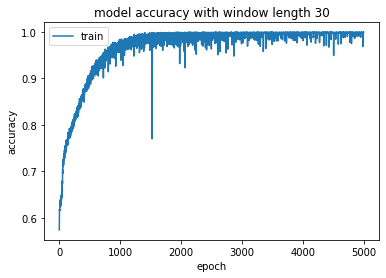

In [43]:
plt.plot(train_accs)
plt.title('model accuracy with window length 30')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

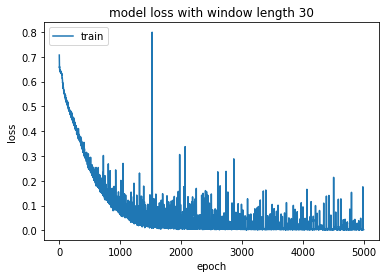

In [44]:
plt.plot(train_losses)
plt.title('model loss with window length 30')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [45]:
third_model.reset_states()
test_results = calc_pos_neg_rate(third_model.evaluate(x=test_generator, verbose=0))

In [46]:
third_model.reset_states()
train_results = calc_pos_neg_rate(third_model.evaluate(x=train_generator, verbose=0))

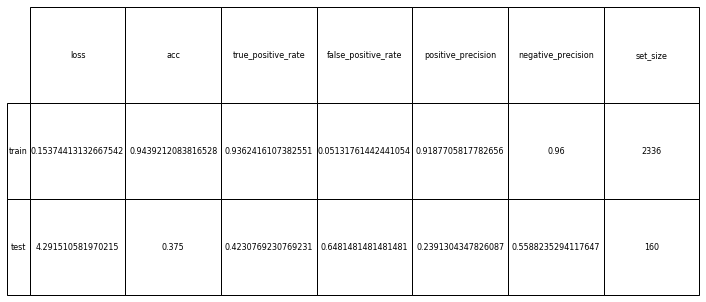

In [47]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Let's save this model for further use.

In [48]:
third_model.save(join(COLAB_DIR,'model_stateful_30.h5'))

## **Transfer Learning**

In this section, we load the pre-trained model and then do partial tuning with training it on the stock with second max trading days. Then, we test it to get accuracy of the model. We set the window length to 10.

In [25]:
stock_with_second_max_trading_days = ten_stocks_with_max_trading_days['TICKER'].iloc[1]
data_related_to_second = data[data['TICKER'] == stock_with_second_max_trading_days]

We first split the dataset into train and test sets.

In [27]:
train_start = pandas.to_datetime('20100101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')

Now, let's do some visualization. We draw the changes of features for both datasets.

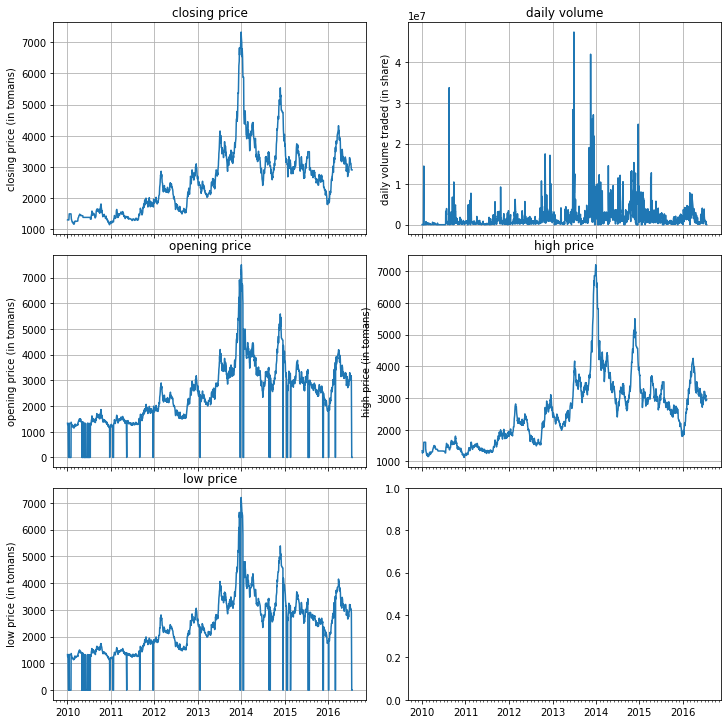

In [29]:
draw_ochlv(data_related_to_second, train_start, train_end)

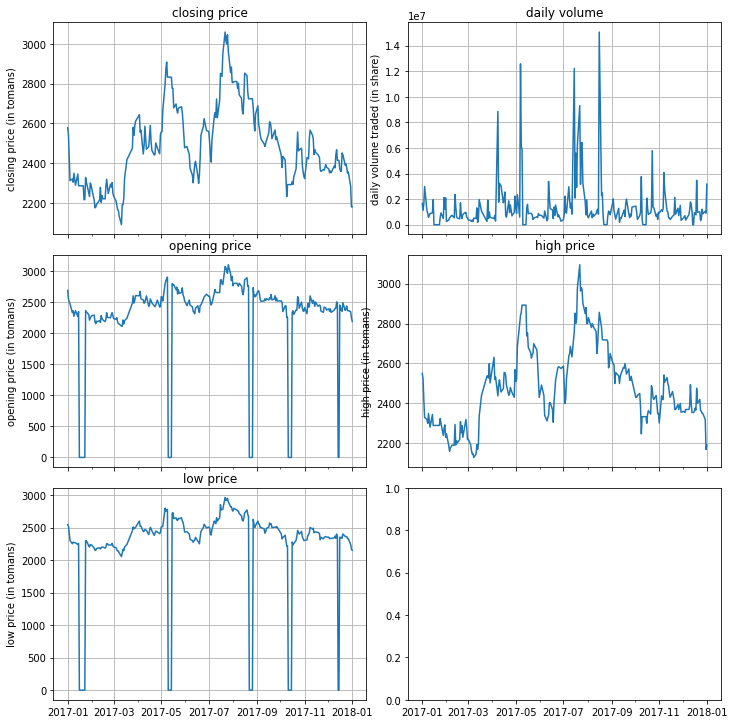

In [30]:
draw_ochlv(data_related_to_second, test_start, test_end)

Next, we load the pretrained model

In [52]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [69]:
from tensorflow.keras.models import load_model


layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
base_model = build_model(train_generator.dim, optimizer, layers=layers, metrics=metrics)
base_model.load_weights(join(COLAB_DIR,'model_stateful.h5'))
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_16 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_4 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_17 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_4 (Batch (32, 16)                  64        
_________________________________________________________________
dense_18 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_19 (Dense)             (32, 1)                  

In [45]:
epochs = 1000

In [70]:
train_accs, train_losses = fit(base_model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.606 seconds , loss : 1.696    accuracy : 0.517    
epoch 2
----------->> Epoch 1/1   0.196 seconds , loss : 0.814    accuracy : 0.523    
epoch 3
----------->> Epoch 1/1   0.162 seconds , loss : 0.726    accuracy : 0.544    
epoch 4
----------->> Epoch 1/1   0.152 seconds , loss : 0.701    accuracy : 0.557    
epoch 5
----------->> Epoch 1/1   0.176 seconds , loss : 0.693    accuracy : 0.553    
epoch 6
----------->> Epoch 1/1   0.147 seconds , loss : 0.684    accuracy : 0.580    
epoch 7
----------->> Epoch 1/1   0.167 seconds , loss : 0.674    accuracy : 0.582    
epoch 8
----------->> Epoch 1/1   0.170 seconds , loss : 0.675    accuracy : 0.583    
epoch 9
----------->> Epoch 1/1   0.153 seconds , loss : 0.666    accuracy : 0.585    
epoch 10
----------->> Epoch 1/1   0.171 seconds , loss : 0.659    accuracy : 0.592    
epoch 11
----------->> Epoch 1/1   0.154 seconds , loss : 0.661    accuracy : 0.615    
epoch 12
----------->> Epoch 1/1   0.166 

----------->> Epoch 1/1   0.157 seconds , loss : 0.246    accuracy : 0.896    
epoch 96
----------->> Epoch 1/1   0.146 seconds , loss : 0.253    accuracy : 0.882    
epoch 97
----------->> Epoch 1/1   0.158 seconds , loss : 0.243    accuracy : 0.898    
epoch 98
----------->> Epoch 1/1   0.156 seconds , loss : 0.268    accuracy : 0.879    
epoch 99
----------->> Epoch 1/1   0.198 seconds , loss : 0.260    accuracy : 0.893    
epoch 100
----------->> Epoch 1/1   0.149 seconds , loss : 0.272    accuracy : 0.880    
epoch 101
----------->> Epoch 1/1   0.162 seconds , loss : 0.243    accuracy : 0.897    
epoch 102
----------->> Epoch 1/1   0.152 seconds , loss : 0.242    accuracy : 0.896    
epoch 103
----------->> Epoch 1/1   0.163 seconds , loss : 0.243    accuracy : 0.896    
epoch 104
----------->> Epoch 1/1   0.178 seconds , loss : 0.241    accuracy : 0.896    
epoch 105
----------->> Epoch 1/1   0.199 seconds , loss : 0.227    accuracy : 0.902    
epoch 106
----------->> Epoch 1/1  

----------->> Epoch 1/1   0.204 seconds , loss : 0.155    accuracy : 0.938    
epoch 188
----------->> Epoch 1/1   0.170 seconds , loss : 0.149    accuracy : 0.942    
epoch 189
----------->> Epoch 1/1   0.193 seconds , loss : 0.168    accuracy : 0.931    
epoch 190
----------->> Epoch 1/1   0.188 seconds , loss : 0.175    accuracy : 0.929    
epoch 191
----------->> Epoch 1/1   0.163 seconds , loss : 0.162    accuracy : 0.931    
epoch 192
----------->> Epoch 1/1   0.228 seconds , loss : 0.143    accuracy : 0.942    
epoch 193
----------->> Epoch 1/1   0.201 seconds , loss : 0.157    accuracy : 0.936    
epoch 194
----------->> Epoch 1/1   0.204 seconds , loss : 0.161    accuracy : 0.934    
epoch 195
----------->> Epoch 1/1   0.201 seconds , loss : 0.151    accuracy : 0.942    
epoch 196
----------->> Epoch 1/1   0.172 seconds , loss : 0.145    accuracy : 0.944    
epoch 197
----------->> Epoch 1/1   0.192 seconds , loss : 0.141    accuracy : 0.944    
epoch 198
----------->> Epoch 1

----------->> Epoch 1/1   0.229 seconds , loss : 0.128    accuracy : 0.957    
epoch 280
----------->> Epoch 1/1   0.206 seconds , loss : 0.107    accuracy : 0.959    
epoch 281
----------->> Epoch 1/1   0.230 seconds , loss : 0.105    accuracy : 0.963    
epoch 282
----------->> Epoch 1/1   0.245 seconds , loss : 0.102    accuracy : 0.963    
epoch 283
----------->> Epoch 1/1   0.218 seconds , loss : 0.118    accuracy : 0.958    
epoch 284
----------->> Epoch 1/1   0.202 seconds , loss : 0.135    accuracy : 0.951    
epoch 285
----------->> Epoch 1/1   0.205 seconds , loss : 0.118    accuracy : 0.949    
epoch 286
----------->> Epoch 1/1   0.201 seconds , loss : 0.100    accuracy : 0.957    
epoch 287
----------->> Epoch 1/1   0.198 seconds , loss : 0.108    accuracy : 0.962    
epoch 288
----------->> Epoch 1/1   0.186 seconds , loss : 0.111    accuracy : 0.954    
epoch 289
----------->> Epoch 1/1   0.180 seconds , loss : 0.110    accuracy : 0.952    
epoch 290
----------->> Epoch 1

----------->> Epoch 1/1   0.204 seconds , loss : 0.089    accuracy : 0.961    
epoch 372
----------->> Epoch 1/1   0.201 seconds , loss : 0.090    accuracy : 0.969    
epoch 373
----------->> Epoch 1/1   0.182 seconds , loss : 0.072    accuracy : 0.976    
epoch 374
----------->> Epoch 1/1   0.195 seconds , loss : 0.096    accuracy : 0.960    
epoch 375
----------->> Epoch 1/1   0.187 seconds , loss : 0.079    accuracy : 0.968    
epoch 376
----------->> Epoch 1/1   0.183 seconds , loss : 0.118    accuracy : 0.957    
epoch 377
----------->> Epoch 1/1   0.183 seconds , loss : 0.081    accuracy : 0.967    
epoch 378
----------->> Epoch 1/1   0.202 seconds , loss : 0.071    accuracy : 0.973    
epoch 379
----------->> Epoch 1/1   0.189 seconds , loss : 0.068    accuracy : 0.969    
epoch 380
----------->> Epoch 1/1   0.213 seconds , loss : 0.066    accuracy : 0.979    
epoch 381
----------->> Epoch 1/1   0.221 seconds , loss : 0.063    accuracy : 0.973    
epoch 382
----------->> Epoch 1

----------->> Epoch 1/1   0.191 seconds , loss : 0.048    accuracy : 0.985    
epoch 465
----------->> Epoch 1/1   0.166 seconds , loss : 0.047    accuracy : 0.985    
epoch 466
----------->> Epoch 1/1   0.168 seconds , loss : 0.066    accuracy : 0.978    
epoch 467
----------->> Epoch 1/1   0.169 seconds , loss : 0.056    accuracy : 0.981    
epoch 468
----------->> Epoch 1/1   0.185 seconds , loss : 0.045    accuracy : 0.985    
epoch 469
----------->> Epoch 1/1   0.178 seconds , loss : 0.055    accuracy : 0.976    
epoch 470
----------->> Epoch 1/1   0.176 seconds , loss : 0.051    accuracy : 0.979    
epoch 471
----------->> Epoch 1/1   0.180 seconds , loss : 0.050    accuracy : 0.982    
epoch 472
----------->> Epoch 1/1   0.180 seconds , loss : 0.059    accuracy : 0.978    
epoch 473
----------->> Epoch 1/1   0.186 seconds , loss : 0.068    accuracy : 0.983    
epoch 474
----------->> Epoch 1/1   0.189 seconds , loss : 0.059    accuracy : 0.980    
epoch 475
----------->> Epoch 1

----------->> Epoch 1/1   0.179 seconds , loss : 0.070    accuracy : 0.976    
epoch 557
----------->> Epoch 1/1   0.205 seconds , loss : 0.084    accuracy : 0.973    
epoch 558
----------->> Epoch 1/1   0.162 seconds , loss : 0.047    accuracy : 0.984    
epoch 559
----------->> Epoch 1/1   0.166 seconds , loss : 0.044    accuracy : 0.984    
epoch 560
----------->> Epoch 1/1   0.169 seconds , loss : 0.034    accuracy : 0.985    
epoch 561
----------->> Epoch 1/1   0.202 seconds , loss : 0.051    accuracy : 0.981    
epoch 562
----------->> Epoch 1/1   0.170 seconds , loss : 0.031    accuracy : 0.990    
epoch 563
----------->> Epoch 1/1   0.165 seconds , loss : 0.032    accuracy : 0.991    
epoch 564
----------->> Epoch 1/1   0.169 seconds , loss : 0.037    accuracy : 0.989    
epoch 565
----------->> Epoch 1/1   0.166 seconds , loss : 0.033    accuracy : 0.989    
epoch 566
----------->> Epoch 1/1   0.156 seconds , loss : 0.035    accuracy : 0.984    
epoch 567
----------->> Epoch 1

----------->> Epoch 1/1   0.200 seconds , loss : 0.030    accuracy : 0.986    
epoch 649
----------->> Epoch 1/1   0.161 seconds , loss : 0.031    accuracy : 0.990    
epoch 650
----------->> Epoch 1/1   0.165 seconds , loss : 0.028    accuracy : 0.990    
epoch 651
----------->> Epoch 1/1   0.170 seconds , loss : 0.032    accuracy : 0.987    
epoch 652
----------->> Epoch 1/1   0.160 seconds , loss : 0.040    accuracy : 0.984    
epoch 653
----------->> Epoch 1/1   0.162 seconds , loss : 0.051    accuracy : 0.987    
epoch 654
----------->> Epoch 1/1   0.166 seconds , loss : 0.052    accuracy : 0.982    
epoch 655
----------->> Epoch 1/1   0.158 seconds , loss : 0.046    accuracy : 0.988    
epoch 656
----------->> Epoch 1/1   0.164 seconds , loss : 0.030    accuracy : 0.987    
epoch 657
----------->> Epoch 1/1   0.170 seconds , loss : 0.039    accuracy : 0.989    
epoch 658
----------->> Epoch 1/1   0.155 seconds , loss : 0.032    accuracy : 0.988    
epoch 659
----------->> Epoch 1

----------->> Epoch 1/1   0.202 seconds , loss : 0.037    accuracy : 0.987    
epoch 741
----------->> Epoch 1/1   0.176 seconds , loss : 0.042    accuracy : 0.983    
epoch 742
----------->> Epoch 1/1   0.163 seconds , loss : 0.030    accuracy : 0.989    
epoch 743
----------->> Epoch 1/1   0.164 seconds , loss : 0.028    accuracy : 0.992    
epoch 744
----------->> Epoch 1/1   0.204 seconds , loss : 0.019    accuracy : 0.992    
epoch 745
----------->> Epoch 1/1   0.186 seconds , loss : 0.020    accuracy : 0.994    
epoch 746
----------->> Epoch 1/1   0.165 seconds , loss : 0.027    accuracy : 0.991    
epoch 747
----------->> Epoch 1/1   0.163 seconds , loss : 0.047    accuracy : 0.981    
epoch 748
----------->> Epoch 1/1   0.172 seconds , loss : 0.037    accuracy : 0.986    
epoch 749
----------->> Epoch 1/1   0.169 seconds , loss : 0.050    accuracy : 0.981    
epoch 750
----------->> Epoch 1/1   0.168 seconds , loss : 0.028    accuracy : 0.991    
epoch 751
----------->> Epoch 1

----------->> Epoch 1/1   0.198 seconds , loss : 0.018    accuracy : 0.995    
epoch 833
----------->> Epoch 1/1   0.179 seconds , loss : 0.021    accuracy : 0.993    
epoch 834
----------->> Epoch 1/1   0.186 seconds , loss : 0.019    accuracy : 0.995    
epoch 835
----------->> Epoch 1/1   0.177 seconds , loss : 0.016    accuracy : 0.996    
epoch 836
----------->> Epoch 1/1   0.184 seconds , loss : 0.044    accuracy : 0.985    
epoch 837
----------->> Epoch 1/1   0.229 seconds , loss : 0.030    accuracy : 0.990    
epoch 838
----------->> Epoch 1/1   0.202 seconds , loss : 0.011    accuracy : 0.998    
epoch 839
----------->> Epoch 1/1   0.175 seconds , loss : 0.024    accuracy : 0.993    
epoch 840
----------->> Epoch 1/1   0.183 seconds , loss : 0.024    accuracy : 0.993    
epoch 841
----------->> Epoch 1/1   0.198 seconds , loss : 0.020    accuracy : 0.994    
epoch 842
----------->> Epoch 1/1   0.190 seconds , loss : 0.020    accuracy : 0.996    
epoch 843
----------->> Epoch 1

----------->> Epoch 1/1   0.186 seconds , loss : 0.012    accuracy : 0.997    
epoch 925
----------->> Epoch 1/1   0.204 seconds , loss : 0.016    accuracy : 0.995    
epoch 926
----------->> Epoch 1/1   0.161 seconds , loss : 0.017    accuracy : 0.996    
epoch 927
----------->> Epoch 1/1   0.165 seconds , loss : 0.037    accuracy : 0.986    
epoch 928
----------->> Epoch 1/1   0.165 seconds , loss : 0.048    accuracy : 0.983    
epoch 929
----------->> Epoch 1/1   0.161 seconds , loss : 0.044    accuracy : 0.987    
epoch 930
----------->> Epoch 1/1   0.164 seconds , loss : 0.040    accuracy : 0.989    
epoch 931
----------->> Epoch 1/1   0.169 seconds , loss : 0.020    accuracy : 0.991    
epoch 932
----------->> Epoch 1/1   0.156 seconds , loss : 0.028    accuracy : 0.991    
epoch 933
----------->> Epoch 1/1   0.165 seconds , loss : 0.025    accuracy : 0.993    
epoch 934
----------->> Epoch 1/1   0.165 seconds , loss : 0.029    accuracy : 0.993    
epoch 935
----------->> Epoch 1

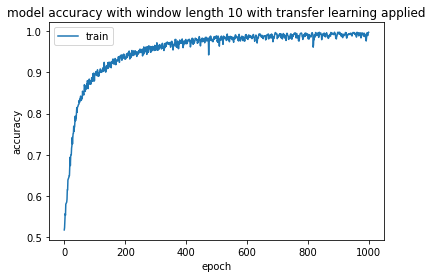

In [71]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 with transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

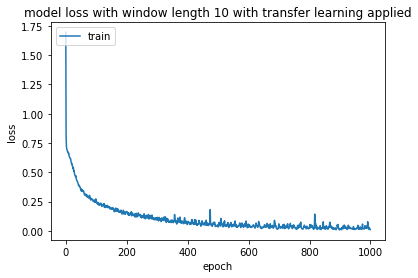

In [72]:
plt.plot(train_losses)
plt.title('model loss with window length 10 with transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [73]:
base_model.reset_states()
test_results = calc_pos_neg_rate(base_model.evaluate(x=test_generator, verbose=0))

In [74]:
base_model.reset_states()
train_results = calc_pos_neg_rate(base_model.evaluate(x=train_generator, verbose=0))

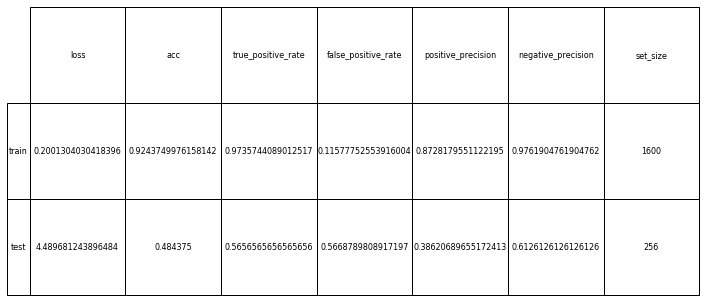

In [75]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)

Now, let's compare this model with the model trained from scratch.

In [83]:
train_start = pandas.to_datetime('20070101', format='%Y%m%d', errors='ignore')
train_end = pandas.to_datetime('20160719', format='%Y%m%d', errors='ignore')
test_start = pandas.to_datetime('20170101', format='%Y%m%d', errors='ignore')
test_end = pandas.to_datetime('20180101', format='%Y%m%d', errors='ignore')
epochs = 5000

First of all, let's visualize the new training set again.

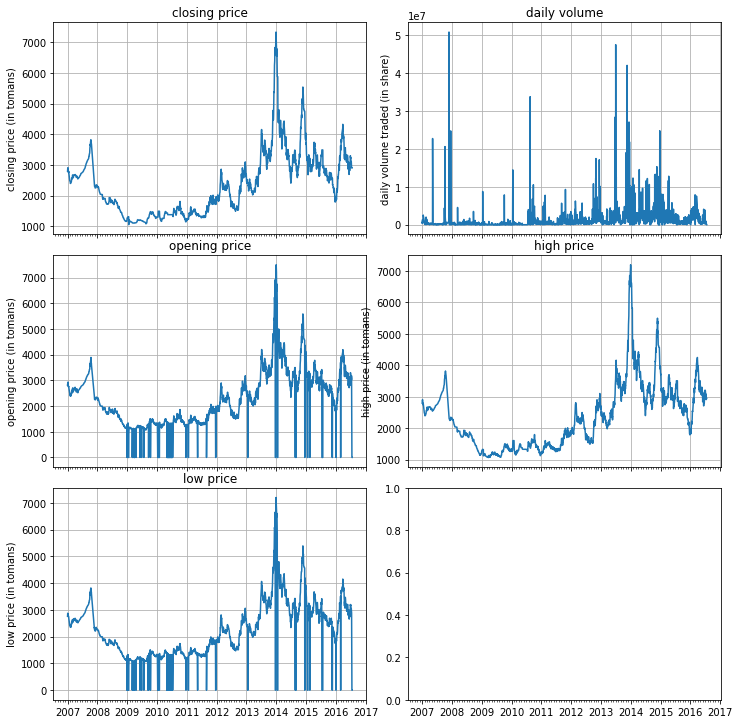

In [79]:
draw_ochlv(data_related_to_second, train_start, train_end)

In [80]:
train_generator, test_generator = generate_datasets_for_model(data, labels, stock_with_second_max_trading_days, train_start, train_end, test_start, test_end)

In [97]:
layers = [
          # input_shape : batch_size, time_step, #features
          LSTM(64, batch_input_shape=(32,train_generator.dim[1], train_generator.dim[2]), stateful=True),
          Dense(32),
          Dropout(0.2),
          Dense(16),
          BatchNormalization(),
          Dense(4),
          Dense(1),
          Activation('sigmoid')
         ]

metrics = [BinaryAccuracy(name='accuracy'), TruePositives(name='true_positives'), FalsePositives(name='false_positives'), TrueNegatives(name='true_negatives'), FalseNegatives(name='false_negatives')]
model = build_model(None, optimizer, layers, metrics=metrics)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (32, 64)                  17920     
_________________________________________________________________
dense_32 (Dense)             (32, 32)                  2080      
_________________________________________________________________
dropout_8 (Dropout)          (32, 32)                  0         
_________________________________________________________________
dense_33 (Dense)             (32, 16)                  528       
_________________________________________________________________
batch_normalization_8 (Batch (32, 16)                  64        
_________________________________________________________________
dense_34 (Dense)             (32, 4)                   68        
_________________________________________________________________
dense_35 (Dense)             (32, 1)                  

In [98]:
train_accs, train_losses = fit(model, epochs, train_generator)

epoch 1
----------->> Epoch 1/1   1.662 seconds , loss : 0.702    accuracy : 0.537    
epoch 2
----------->> Epoch 1/1   0.249 seconds , loss : 0.687    accuracy : 0.550    
epoch 3
----------->> Epoch 1/1   0.237 seconds , loss : 0.686    accuracy : 0.551    
epoch 4
----------->> Epoch 1/1   0.247 seconds , loss : 0.680    accuracy : 0.560    
epoch 5
----------->> Epoch 1/1   0.246 seconds , loss : 0.682    accuracy : 0.556    
epoch 6
----------->> Epoch 1/1   0.220 seconds , loss : 0.680    accuracy : 0.577    
epoch 7
----------->> Epoch 1/1   0.224 seconds , loss : 0.672    accuracy : 0.604    
epoch 8
----------->> Epoch 1/1   0.225 seconds , loss : 0.669    accuracy : 0.594    
epoch 9
----------->> Epoch 1/1   0.213 seconds , loss : 0.674    accuracy : 0.578    
epoch 10
----------->> Epoch 1/1   0.225 seconds , loss : 0.683    accuracy : 0.564    
epoch 11
----------->> Epoch 1/1   0.269 seconds , loss : 0.669    accuracy : 0.588    
epoch 12
----------->> Epoch 1/1   0.235 

----------->> Epoch 1/1   0.217 seconds , loss : 0.568    accuracy : 0.720    
epoch 95
----------->> Epoch 1/1   0.232 seconds , loss : 0.563    accuracy : 0.706    
epoch 96
----------->> Epoch 1/1   0.221 seconds , loss : 0.567    accuracy : 0.713    
epoch 97
----------->> Epoch 1/1   0.230 seconds , loss : 0.565    accuracy : 0.713    
epoch 98
----------->> Epoch 1/1   0.217 seconds , loss : 0.563    accuracy : 0.717    
epoch 99
----------->> Epoch 1/1   0.224 seconds , loss : 0.567    accuracy : 0.715    
epoch 100
----------->> Epoch 1/1   0.304 seconds , loss : 0.561    accuracy : 0.716    
epoch 101
----------->> Epoch 1/1   0.322 seconds , loss : 0.558    accuracy : 0.710    
epoch 102
----------->> Epoch 1/1   0.309 seconds , loss : 0.566    accuracy : 0.713    
epoch 103
----------->> Epoch 1/1   0.289 seconds , loss : 0.570    accuracy : 0.709    
epoch 104
----------->> Epoch 1/1   0.282 seconds , loss : 0.560    accuracy : 0.721    
epoch 105
----------->> Epoch 1/1   

----------->> Epoch 1/1   0.297 seconds , loss : 0.546    accuracy : 0.730    
epoch 187
----------->> Epoch 1/1   0.316 seconds , loss : 0.541    accuracy : 0.735    
epoch 188
----------->> Epoch 1/1   0.317 seconds , loss : 0.544    accuracy : 0.738    
epoch 189
----------->> Epoch 1/1   0.336 seconds , loss : 0.545    accuracy : 0.726    
epoch 190
----------->> Epoch 1/1   0.322 seconds , loss : 0.546    accuracy : 0.718    
epoch 191
----------->> Epoch 1/1   0.292 seconds , loss : 0.544    accuracy : 0.733    
epoch 192
----------->> Epoch 1/1   0.233 seconds , loss : 0.541    accuracy : 0.728    
epoch 193
----------->> Epoch 1/1   0.222 seconds , loss : 0.542    accuracy : 0.725    
epoch 194
----------->> Epoch 1/1   0.225 seconds , loss : 0.538    accuracy : 0.733    
epoch 195
----------->> Epoch 1/1   0.244 seconds , loss : 0.549    accuracy : 0.720    
epoch 196
----------->> Epoch 1/1   0.273 seconds , loss : 0.540    accuracy : 0.725    
epoch 197
----------->> Epoch 1

----------->> Epoch 1/1   0.229 seconds , loss : 0.525    accuracy : 0.735    
epoch 279
----------->> Epoch 1/1   0.227 seconds , loss : 0.523    accuracy : 0.743    
epoch 280
----------->> Epoch 1/1   0.229 seconds , loss : 0.519    accuracy : 0.747    
epoch 281
----------->> Epoch 1/1   0.225 seconds , loss : 0.520    accuracy : 0.744    
epoch 282
----------->> Epoch 1/1   0.223 seconds , loss : 0.517    accuracy : 0.744    
epoch 283
----------->> Epoch 1/1   0.226 seconds , loss : 0.518    accuracy : 0.734    
epoch 284
----------->> Epoch 1/1   0.319 seconds , loss : 0.519    accuracy : 0.754    
epoch 285
----------->> Epoch 1/1   0.229 seconds , loss : 0.518    accuracy : 0.742    
epoch 286
----------->> Epoch 1/1   0.228 seconds , loss : 0.518    accuracy : 0.746    
epoch 287
----------->> Epoch 1/1   0.229 seconds , loss : 0.521    accuracy : 0.746    
epoch 288
----------->> Epoch 1/1   0.229 seconds , loss : 0.518    accuracy : 0.734    
epoch 289
----------->> Epoch 1

----------->> Epoch 1/1   0.340 seconds , loss : 0.505    accuracy : 0.754    
epoch 371
----------->> Epoch 1/1   0.351 seconds , loss : 0.497    accuracy : 0.753    
epoch 372
----------->> Epoch 1/1   0.347 seconds , loss : 0.505    accuracy : 0.747    
epoch 373
----------->> Epoch 1/1   0.353 seconds , loss : 0.498    accuracy : 0.759    
epoch 374
----------->> Epoch 1/1   0.328 seconds , loss : 0.501    accuracy : 0.754    
epoch 375
----------->> Epoch 1/1   0.307 seconds , loss : 0.501    accuracy : 0.753    
epoch 376
----------->> Epoch 1/1   0.373 seconds , loss : 0.496    accuracy : 0.746    
epoch 377
----------->> Epoch 1/1   0.301 seconds , loss : 0.494    accuracy : 0.750    
epoch 378
----------->> Epoch 1/1   0.299 seconds , loss : 0.493    accuracy : 0.759    
epoch 379
----------->> Epoch 1/1   0.300 seconds , loss : 0.499    accuracy : 0.743    
epoch 380
----------->> Epoch 1/1   0.240 seconds , loss : 0.503    accuracy : 0.754    
epoch 381
----------->> Epoch 1

----------->> Epoch 1/1   0.227 seconds , loss : 0.482    accuracy : 0.766    
epoch 463
----------->> Epoch 1/1   0.224 seconds , loss : 0.483    accuracy : 0.767    
epoch 464
----------->> Epoch 1/1   0.222 seconds , loss : 0.480    accuracy : 0.768    
epoch 465
----------->> Epoch 1/1   0.228 seconds , loss : 0.475    accuracy : 0.776    
epoch 466
----------->> Epoch 1/1   0.222 seconds , loss : 0.482    accuracy : 0.771    
epoch 467
----------->> Epoch 1/1   0.233 seconds , loss : 0.476    accuracy : 0.761    
epoch 468
----------->> Epoch 1/1   0.226 seconds , loss : 0.479    accuracy : 0.761    
epoch 469
----------->> Epoch 1/1   0.224 seconds , loss : 0.471    accuracy : 0.771    
epoch 470
----------->> Epoch 1/1   0.222 seconds , loss : 0.472    accuracy : 0.774    
epoch 471
----------->> Epoch 1/1   0.227 seconds , loss : 0.475    accuracy : 0.766    
epoch 472
----------->> Epoch 1/1   0.224 seconds , loss : 0.478    accuracy : 0.771    
epoch 473
----------->> Epoch 1

----------->> Epoch 1/1   0.302 seconds , loss : 0.447    accuracy : 0.783    
epoch 555
----------->> Epoch 1/1   0.298 seconds , loss : 0.447    accuracy : 0.792    
epoch 556
----------->> Epoch 1/1   0.259 seconds , loss : 0.462    accuracy : 0.776    
epoch 557
----------->> Epoch 1/1   0.397 seconds , loss : 0.460    accuracy : 0.776    
epoch 558
----------->> Epoch 1/1   0.389 seconds , loss : 0.455    accuracy : 0.776    
epoch 559
----------->> Epoch 1/1   0.358 seconds , loss : 0.455    accuracy : 0.777    
epoch 560
----------->> Epoch 1/1   0.290 seconds , loss : 0.456    accuracy : 0.774    
epoch 561
----------->> Epoch 1/1   0.300 seconds , loss : 0.453    accuracy : 0.781    
epoch 562
----------->> Epoch 1/1   0.309 seconds , loss : 0.448    accuracy : 0.783    
epoch 563
----------->> Epoch 1/1   0.306 seconds , loss : 0.448    accuracy : 0.780    
epoch 564
----------->> Epoch 1/1   0.333 seconds , loss : 0.453    accuracy : 0.780    
epoch 565
----------->> Epoch 1

----------->> Epoch 1/1   0.307 seconds , loss : 0.434    accuracy : 0.792    
epoch 647
----------->> Epoch 1/1   0.252 seconds , loss : 0.426    accuracy : 0.795    
epoch 648
----------->> Epoch 1/1   0.251 seconds , loss : 0.432    accuracy : 0.791    
epoch 649
----------->> Epoch 1/1   0.225 seconds , loss : 0.440    accuracy : 0.782    
epoch 650
----------->> Epoch 1/1   0.284 seconds , loss : 0.428    accuracy : 0.796    
epoch 651
----------->> Epoch 1/1   0.288 seconds , loss : 0.438    accuracy : 0.782    
epoch 652
----------->> Epoch 1/1   0.251 seconds , loss : 0.429    accuracy : 0.796    
epoch 653
----------->> Epoch 1/1   0.277 seconds , loss : 0.416    accuracy : 0.793    
epoch 654
----------->> Epoch 1/1   0.294 seconds , loss : 0.428    accuracy : 0.794    
epoch 655
----------->> Epoch 1/1   0.258 seconds , loss : 0.428    accuracy : 0.804    
epoch 656
----------->> Epoch 1/1   0.258 seconds , loss : 0.424    accuracy : 0.798    
epoch 657
----------->> Epoch 1

----------->> Epoch 1/1   0.263 seconds , loss : 0.399    accuracy : 0.809    
epoch 739
----------->> Epoch 1/1   0.288 seconds , loss : 0.404    accuracy : 0.806    
epoch 740
----------->> Epoch 1/1   0.253 seconds , loss : 0.402    accuracy : 0.801    
epoch 741
----------->> Epoch 1/1   0.248 seconds , loss : 0.392    accuracy : 0.801    
epoch 742
----------->> Epoch 1/1   0.269 seconds , loss : 0.418    accuracy : 0.804    
epoch 743
----------->> Epoch 1/1   0.281 seconds , loss : 0.411    accuracy : 0.800    
epoch 744
----------->> Epoch 1/1   0.259 seconds , loss : 0.400    accuracy : 0.803    
epoch 745
----------->> Epoch 1/1   0.252 seconds , loss : 0.414    accuracy : 0.798    
epoch 746
----------->> Epoch 1/1   0.240 seconds , loss : 0.400    accuracy : 0.805    
epoch 747
----------->> Epoch 1/1   0.246 seconds , loss : 0.396    accuracy : 0.803    
epoch 748
----------->> Epoch 1/1   0.263 seconds , loss : 0.399    accuracy : 0.799    
epoch 749
----------->> Epoch 1

----------->> Epoch 1/1   0.232 seconds , loss : 0.371    accuracy : 0.815    
epoch 831
----------->> Epoch 1/1   0.243 seconds , loss : 0.368    accuracy : 0.824    
epoch 832
----------->> Epoch 1/1   0.252 seconds , loss : 0.384    accuracy : 0.817    
epoch 833
----------->> Epoch 1/1   0.246 seconds , loss : 0.391    accuracy : 0.807    
epoch 834
----------->> Epoch 1/1   0.229 seconds , loss : 0.379    accuracy : 0.812    
epoch 835
----------->> Epoch 1/1   0.233 seconds , loss : 0.379    accuracy : 0.816    
epoch 836
----------->> Epoch 1/1   0.234 seconds , loss : 0.376    accuracy : 0.819    
epoch 837
----------->> Epoch 1/1   0.263 seconds , loss : 0.375    accuracy : 0.819    
epoch 838
----------->> Epoch 1/1   0.295 seconds , loss : 0.370    accuracy : 0.825    
epoch 839
----------->> Epoch 1/1   0.269 seconds , loss : 0.368    accuracy : 0.824    
epoch 840
----------->> Epoch 1/1   0.240 seconds , loss : 0.354    accuracy : 0.828    
epoch 841
----------->> Epoch 1

----------->> Epoch 1/1   0.239 seconds , loss : 0.362    accuracy : 0.830    
epoch 923
----------->> Epoch 1/1   0.243 seconds , loss : 0.343    accuracy : 0.835    
epoch 924
----------->> Epoch 1/1   0.234 seconds , loss : 0.328    accuracy : 0.848    
epoch 925
----------->> Epoch 1/1   0.320 seconds , loss : 0.356    accuracy : 0.833    
epoch 926
----------->> Epoch 1/1   0.250 seconds , loss : 0.341    accuracy : 0.837    
epoch 927
----------->> Epoch 1/1   0.244 seconds , loss : 0.341    accuracy : 0.837    
epoch 928
----------->> Epoch 1/1   0.341 seconds , loss : 0.349    accuracy : 0.848    
epoch 929
----------->> Epoch 1/1   0.306 seconds , loss : 0.359    accuracy : 0.824    
epoch 930
----------->> Epoch 1/1   0.284 seconds , loss : 0.352    accuracy : 0.836    
epoch 931
----------->> Epoch 1/1   0.272 seconds , loss : 0.342    accuracy : 0.832    
epoch 932
----------->> Epoch 1/1   0.297 seconds , loss : 0.331    accuracy : 0.849    
epoch 933
----------->> Epoch 1

----------->> Epoch 1/1   0.246 seconds , loss : 0.326    accuracy : 0.846    
epoch 1015
----------->> Epoch 1/1   0.268 seconds , loss : 0.342    accuracy : 0.841    
epoch 1016
----------->> Epoch 1/1   0.263 seconds , loss : 0.322    accuracy : 0.849    
epoch 1017
----------->> Epoch 1/1   0.300 seconds , loss : 0.312    accuracy : 0.855    
epoch 1018
----------->> Epoch 1/1   0.250 seconds , loss : 0.326    accuracy : 0.846    
epoch 1019
----------->> Epoch 1/1   0.259 seconds , loss : 0.324    accuracy : 0.853    
epoch 1020
----------->> Epoch 1/1   0.314 seconds , loss : 0.317    accuracy : 0.853    
epoch 1021
----------->> Epoch 1/1   0.269 seconds , loss : 0.332    accuracy : 0.843    
epoch 1022
----------->> Epoch 1/1   0.256 seconds , loss : 0.325    accuracy : 0.845    
epoch 1023
----------->> Epoch 1/1   0.254 seconds , loss : 0.338    accuracy : 0.841    
epoch 1024
----------->> Epoch 1/1   0.241 seconds , loss : 0.317    accuracy : 0.851    
epoch 1025
----------

----------->> Epoch 1/1   0.228 seconds , loss : 0.303    accuracy : 0.857    
epoch 1106
----------->> Epoch 1/1   0.260 seconds , loss : 0.300    accuracy : 0.856    
epoch 1107
----------->> Epoch 1/1   0.265 seconds , loss : 0.297    accuracy : 0.856    
epoch 1108
----------->> Epoch 1/1   0.248 seconds , loss : 0.299    accuracy : 0.859    
epoch 1109
----------->> Epoch 1/1   0.255 seconds , loss : 0.302    accuracy : 0.850    
epoch 1110
----------->> Epoch 1/1   0.276 seconds , loss : 0.304    accuracy : 0.855    
epoch 1111
----------->> Epoch 1/1   0.250 seconds , loss : 0.307    accuracy : 0.858    
epoch 1112
----------->> Epoch 1/1   0.249 seconds , loss : 0.303    accuracy : 0.857    
epoch 1113
----------->> Epoch 1/1   0.236 seconds , loss : 0.301    accuracy : 0.860    
epoch 1114
----------->> Epoch 1/1   0.268 seconds , loss : 0.299    accuracy : 0.860    
epoch 1115
----------->> Epoch 1/1   0.252 seconds , loss : 0.297    accuracy : 0.861    
epoch 1116
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.284    accuracy : 0.864    
epoch 1197
----------->> Epoch 1/1   0.241 seconds , loss : 0.291    accuracy : 0.868    
epoch 1198
----------->> Epoch 1/1   0.323 seconds , loss : 0.278    accuracy : 0.878    
epoch 1199
----------->> Epoch 1/1   0.312 seconds , loss : 0.287    accuracy : 0.868    
epoch 1200
----------->> Epoch 1/1   0.243 seconds , loss : 0.296    accuracy : 0.871    
epoch 1201
----------->> Epoch 1/1   0.315 seconds , loss : 0.283    accuracy : 0.868    
epoch 1202
----------->> Epoch 1/1   0.236 seconds , loss : 0.294    accuracy : 0.863    
epoch 1203
----------->> Epoch 1/1   0.228 seconds , loss : 0.291    accuracy : 0.862    
epoch 1204
----------->> Epoch 1/1   0.228 seconds , loss : 0.289    accuracy : 0.864    
epoch 1205
----------->> Epoch 1/1   0.309 seconds , loss : 0.272    accuracy : 0.871    
epoch 1206
----------->> Epoch 1/1   0.251 seconds , loss : 0.290    accuracy : 0.868    
epoch 1207
----------

----------->> Epoch 1/1   0.309 seconds , loss : 0.290    accuracy : 0.858    
epoch 1288
----------->> Epoch 1/1   0.296 seconds , loss : 0.274    accuracy : 0.871    
epoch 1289
----------->> Epoch 1/1   0.269 seconds , loss : 0.257    accuracy : 0.882    
epoch 1290
----------->> Epoch 1/1   0.244 seconds , loss : 0.263    accuracy : 0.880    
epoch 1291
----------->> Epoch 1/1   0.232 seconds , loss : 0.266    accuracy : 0.869    
epoch 1292
----------->> Epoch 1/1   0.268 seconds , loss : 0.270    accuracy : 0.880    
epoch 1293
----------->> Epoch 1/1   0.322 seconds , loss : 0.263    accuracy : 0.886    
epoch 1294
----------->> Epoch 1/1   0.317 seconds , loss : 0.262    accuracy : 0.882    
epoch 1295
----------->> Epoch 1/1   0.278 seconds , loss : 0.286    accuracy : 0.875    
epoch 1296
----------->> Epoch 1/1   0.342 seconds , loss : 0.269    accuracy : 0.880    
epoch 1297
----------->> Epoch 1/1   0.309 seconds , loss : 0.266    accuracy : 0.883    
epoch 1298
----------

----------->> Epoch 1/1   0.225 seconds , loss : 0.247    accuracy : 0.887    
epoch 1379
----------->> Epoch 1/1   0.280 seconds , loss : 0.253    accuracy : 0.885    
epoch 1380
----------->> Epoch 1/1   0.244 seconds , loss : 0.237    accuracy : 0.893    
epoch 1381
----------->> Epoch 1/1   0.234 seconds , loss : 0.239    accuracy : 0.890    
epoch 1382
----------->> Epoch 1/1   0.281 seconds , loss : 0.249    accuracy : 0.888    
epoch 1383
----------->> Epoch 1/1   0.281 seconds , loss : 0.239    accuracy : 0.892    
epoch 1384
----------->> Epoch 1/1   0.235 seconds , loss : 0.243    accuracy : 0.893    
epoch 1385
----------->> Epoch 1/1   0.232 seconds , loss : 0.259    accuracy : 0.886    
epoch 1386
----------->> Epoch 1/1   0.265 seconds , loss : 0.261    accuracy : 0.889    
epoch 1387
----------->> Epoch 1/1   0.249 seconds , loss : 0.253    accuracy : 0.878    
epoch 1388
----------->> Epoch 1/1   0.229 seconds , loss : 0.252    accuracy : 0.883    
epoch 1389
----------

----------->> Epoch 1/1   0.337 seconds , loss : 0.257    accuracy : 0.890    
epoch 1470
----------->> Epoch 1/1   0.328 seconds , loss : 0.227    accuracy : 0.897    
epoch 1471
----------->> Epoch 1/1   0.259 seconds , loss : 0.226    accuracy : 0.898    
epoch 1472
----------->> Epoch 1/1   0.323 seconds , loss : 0.227    accuracy : 0.896    
epoch 1473
----------->> Epoch 1/1   0.338 seconds , loss : 0.230    accuracy : 0.888    
epoch 1474
----------->> Epoch 1/1   0.296 seconds , loss : 0.221    accuracy : 0.902    
epoch 1475
----------->> Epoch 1/1   0.254 seconds , loss : 0.235    accuracy : 0.897    
epoch 1476
----------->> Epoch 1/1   0.357 seconds , loss : 0.227    accuracy : 0.902    
epoch 1477
----------->> Epoch 1/1   0.295 seconds , loss : 0.241    accuracy : 0.893    
epoch 1478
----------->> Epoch 1/1   0.335 seconds , loss : 0.227    accuracy : 0.897    
epoch 1479
----------->> Epoch 1/1   0.236 seconds , loss : 0.234    accuracy : 0.895    
epoch 1480
----------

----------->> Epoch 1/1   0.294 seconds , loss : 0.216    accuracy : 0.907    
epoch 1561
----------->> Epoch 1/1   0.298 seconds , loss : 0.220    accuracy : 0.895    
epoch 1562
----------->> Epoch 1/1   0.274 seconds , loss : 0.219    accuracy : 0.901    
epoch 1563
----------->> Epoch 1/1   0.290 seconds , loss : 0.208    accuracy : 0.909    
epoch 1564
----------->> Epoch 1/1   0.263 seconds , loss : 0.227    accuracy : 0.891    
epoch 1565
----------->> Epoch 1/1   0.274 seconds , loss : 0.228    accuracy : 0.904    
epoch 1566
----------->> Epoch 1/1   0.310 seconds , loss : 0.218    accuracy : 0.907    
epoch 1567
----------->> Epoch 1/1   0.271 seconds , loss : 0.227    accuracy : 0.901    
epoch 1568
----------->> Epoch 1/1   0.315 seconds , loss : 0.209    accuracy : 0.904    
epoch 1569
----------->> Epoch 1/1   0.305 seconds , loss : 0.203    accuracy : 0.909    
epoch 1570
----------->> Epoch 1/1   0.269 seconds , loss : 0.211    accuracy : 0.909    
epoch 1571
----------

----------->> Epoch 1/1   0.319 seconds , loss : 0.224    accuracy : 0.896    
epoch 1652
----------->> Epoch 1/1   0.246 seconds , loss : 0.225    accuracy : 0.900    
epoch 1653
----------->> Epoch 1/1   0.325 seconds , loss : 0.204    accuracy : 0.908    
epoch 1654
----------->> Epoch 1/1   0.248 seconds , loss : 0.200    accuracy : 0.911    
epoch 1655
----------->> Epoch 1/1   0.231 seconds , loss : 0.198    accuracy : 0.913    
epoch 1656
----------->> Epoch 1/1   0.238 seconds , loss : 0.189    accuracy : 0.915    
epoch 1657
----------->> Epoch 1/1   0.341 seconds , loss : 0.219    accuracy : 0.908    
epoch 1658
----------->> Epoch 1/1   0.241 seconds , loss : 0.214    accuracy : 0.911    
epoch 1659
----------->> Epoch 1/1   0.232 seconds , loss : 0.215    accuracy : 0.907    
epoch 1660
----------->> Epoch 1/1   0.229 seconds , loss : 0.193    accuracy : 0.914    
epoch 1661
----------->> Epoch 1/1   0.274 seconds , loss : 0.193    accuracy : 0.915    
epoch 1662
----------

----------->> Epoch 1/1   0.247 seconds , loss : 0.194    accuracy : 0.915    
epoch 1743
----------->> Epoch 1/1   0.233 seconds , loss : 0.187    accuracy : 0.916    
epoch 1744
----------->> Epoch 1/1   0.228 seconds , loss : 0.193    accuracy : 0.911    
epoch 1745
----------->> Epoch 1/1   0.250 seconds , loss : 0.185    accuracy : 0.928    
epoch 1746
----------->> Epoch 1/1   0.259 seconds , loss : 0.201    accuracy : 0.914    
epoch 1747
----------->> Epoch 1/1   0.279 seconds , loss : 0.202    accuracy : 0.907    
epoch 1748
----------->> Epoch 1/1   0.271 seconds , loss : 0.187    accuracy : 0.915    
epoch 1749
----------->> Epoch 1/1   0.230 seconds , loss : 0.182    accuracy : 0.917    
epoch 1750
----------->> Epoch 1/1   0.233 seconds , loss : 0.176    accuracy : 0.920    
epoch 1751
----------->> Epoch 1/1   0.228 seconds , loss : 0.190    accuracy : 0.920    
epoch 1752
----------->> Epoch 1/1   0.320 seconds , loss : 0.195    accuracy : 0.916    
epoch 1753
----------

----------->> Epoch 1/1   0.231 seconds , loss : 0.166    accuracy : 0.927    
epoch 1834
----------->> Epoch 1/1   0.234 seconds , loss : 0.179    accuracy : 0.919    
epoch 1835
----------->> Epoch 1/1   0.252 seconds , loss : 0.179    accuracy : 0.921    
epoch 1836
----------->> Epoch 1/1   0.258 seconds , loss : 0.171    accuracy : 0.926    
epoch 1837
----------->> Epoch 1/1   0.278 seconds , loss : 0.160    accuracy : 0.934    
epoch 1838
----------->> Epoch 1/1   0.281 seconds , loss : 0.188    accuracy : 0.922    
epoch 1839
----------->> Epoch 1/1   0.286 seconds , loss : 0.182    accuracy : 0.918    
epoch 1840
----------->> Epoch 1/1   0.276 seconds , loss : 0.164    accuracy : 0.930    
epoch 1841
----------->> Epoch 1/1   0.298 seconds , loss : 0.169    accuracy : 0.920    
epoch 1842
----------->> Epoch 1/1   0.284 seconds , loss : 0.190    accuracy : 0.918    
epoch 1843
----------->> Epoch 1/1   0.294 seconds , loss : 0.167    accuracy : 0.926    
epoch 1844
----------

----------->> Epoch 1/1   0.266 seconds , loss : 0.180    accuracy : 0.919    
epoch 1925
----------->> Epoch 1/1   0.324 seconds , loss : 0.186    accuracy : 0.922    
epoch 1926
----------->> Epoch 1/1   0.316 seconds , loss : 0.199    accuracy : 0.914    
epoch 1927
----------->> Epoch 1/1   0.291 seconds , loss : 0.175    accuracy : 0.926    
epoch 1928
----------->> Epoch 1/1   0.306 seconds , loss : 0.164    accuracy : 0.927    
epoch 1929
----------->> Epoch 1/1   0.291 seconds , loss : 0.170    accuracy : 0.925    
epoch 1930
----------->> Epoch 1/1   0.303 seconds , loss : 0.175    accuracy : 0.919    
epoch 1931
----------->> Epoch 1/1   0.291 seconds , loss : 0.162    accuracy : 0.926    
epoch 1932
----------->> Epoch 1/1   0.279 seconds , loss : 0.169    accuracy : 0.927    
epoch 1933
----------->> Epoch 1/1   0.289 seconds , loss : 0.164    accuracy : 0.928    
epoch 1934
----------->> Epoch 1/1   0.358 seconds , loss : 0.189    accuracy : 0.915    
epoch 1935
----------

----------->> Epoch 1/1   0.263 seconds , loss : 0.164    accuracy : 0.927    
epoch 2016
----------->> Epoch 1/1   0.263 seconds , loss : 0.189    accuracy : 0.915    
epoch 2017
----------->> Epoch 1/1   0.243 seconds , loss : 0.173    accuracy : 0.920    
epoch 2018
----------->> Epoch 1/1   0.239 seconds , loss : 0.171    accuracy : 0.924    
epoch 2019
----------->> Epoch 1/1   0.311 seconds , loss : 0.163    accuracy : 0.928    
epoch 2020
----------->> Epoch 1/1   0.240 seconds , loss : 0.143    accuracy : 0.940    
epoch 2021
----------->> Epoch 1/1   0.253 seconds , loss : 0.157    accuracy : 0.927    
epoch 2022
----------->> Epoch 1/1   0.237 seconds , loss : 0.148    accuracy : 0.934    
epoch 2023
----------->> Epoch 1/1   0.232 seconds , loss : 0.178    accuracy : 0.925    
epoch 2024
----------->> Epoch 1/1   0.230 seconds , loss : 0.168    accuracy : 0.927    
epoch 2025
----------->> Epoch 1/1   0.227 seconds , loss : 0.162    accuracy : 0.933    
epoch 2026
----------

----------->> Epoch 1/1   0.226 seconds , loss : 0.139    accuracy : 0.938    
epoch 2107
----------->> Epoch 1/1   0.230 seconds , loss : 0.151    accuracy : 0.934    
epoch 2108
----------->> Epoch 1/1   0.226 seconds , loss : 0.152    accuracy : 0.929    
epoch 2109
----------->> Epoch 1/1   0.285 seconds , loss : 0.148    accuracy : 0.930    
epoch 2110
----------->> Epoch 1/1   0.228 seconds , loss : 0.156    accuracy : 0.928    
epoch 2111
----------->> Epoch 1/1   0.272 seconds , loss : 0.146    accuracy : 0.931    
epoch 2112
----------->> Epoch 1/1   0.247 seconds , loss : 0.147    accuracy : 0.938    
epoch 2113
----------->> Epoch 1/1   0.230 seconds , loss : 0.163    accuracy : 0.926    
epoch 2114
----------->> Epoch 1/1   0.226 seconds , loss : 0.162    accuracy : 0.931    
epoch 2115
----------->> Epoch 1/1   0.229 seconds , loss : 0.159    accuracy : 0.929    
epoch 2116
----------->> Epoch 1/1   0.237 seconds , loss : 0.157    accuracy : 0.923    
epoch 2117
----------

----------->> Epoch 1/1   0.342 seconds , loss : 0.153    accuracy : 0.934    
epoch 2198
----------->> Epoch 1/1   0.356 seconds , loss : 0.133    accuracy : 0.942    
epoch 2199
----------->> Epoch 1/1   0.310 seconds , loss : 0.140    accuracy : 0.936    
epoch 2200
----------->> Epoch 1/1   0.263 seconds , loss : 0.133    accuracy : 0.936    
epoch 2201
----------->> Epoch 1/1   0.274 seconds , loss : 0.161    accuracy : 0.929    
epoch 2202
----------->> Epoch 1/1   0.273 seconds , loss : 0.143    accuracy : 0.941    
epoch 2203
----------->> Epoch 1/1   0.282 seconds , loss : 0.143    accuracy : 0.938    
epoch 2204
----------->> Epoch 1/1   0.287 seconds , loss : 0.146    accuracy : 0.934    
epoch 2205
----------->> Epoch 1/1   0.351 seconds , loss : 0.145    accuracy : 0.938    
epoch 2206
----------->> Epoch 1/1   0.370 seconds , loss : 0.162    accuracy : 0.924    
epoch 2207
----------->> Epoch 1/1   0.354 seconds , loss : 0.146    accuracy : 0.931    
epoch 2208
----------

----------->> Epoch 1/1   0.340 seconds , loss : 0.152    accuracy : 0.926    
epoch 2289
----------->> Epoch 1/1   0.319 seconds , loss : 0.129    accuracy : 0.942    
epoch 2290
----------->> Epoch 1/1   0.302 seconds , loss : 0.146    accuracy : 0.933    
epoch 2291
----------->> Epoch 1/1   0.318 seconds , loss : 0.131    accuracy : 0.939    
epoch 2292
----------->> Epoch 1/1   0.363 seconds , loss : 0.135    accuracy : 0.938    
epoch 2293
----------->> Epoch 1/1   0.341 seconds , loss : 0.133    accuracy : 0.944    
epoch 2294
----------->> Epoch 1/1   0.321 seconds , loss : 0.144    accuracy : 0.937    
epoch 2295
----------->> Epoch 1/1   0.337 seconds , loss : 0.138    accuracy : 0.937    
epoch 2296
----------->> Epoch 1/1   0.329 seconds , loss : 0.139    accuracy : 0.938    
epoch 2297
----------->> Epoch 1/1   0.329 seconds , loss : 0.149    accuracy : 0.935    
epoch 2298
----------->> Epoch 1/1   0.361 seconds , loss : 0.147    accuracy : 0.934    
epoch 2299
----------

----------->> Epoch 1/1   0.280 seconds , loss : 0.158    accuracy : 0.930    
epoch 2380
----------->> Epoch 1/1   0.333 seconds , loss : 0.157    accuracy : 0.933    
epoch 2381
----------->> Epoch 1/1   0.310 seconds , loss : 0.141    accuracy : 0.938    
epoch 2382
----------->> Epoch 1/1   0.294 seconds , loss : 0.148    accuracy : 0.930    
epoch 2383
----------->> Epoch 1/1   0.268 seconds , loss : 0.121    accuracy : 0.942    
epoch 2384
----------->> Epoch 1/1   0.255 seconds , loss : 0.123    accuracy : 0.945    
epoch 2385
----------->> Epoch 1/1   0.261 seconds , loss : 0.124    accuracy : 0.945    
epoch 2386
----------->> Epoch 1/1   0.284 seconds , loss : 0.139    accuracy : 0.936    
epoch 2387
----------->> Epoch 1/1   0.267 seconds , loss : 0.129    accuracy : 0.946    
epoch 2388
----------->> Epoch 1/1   0.244 seconds , loss : 0.136    accuracy : 0.939    
epoch 2389
----------->> Epoch 1/1   0.257 seconds , loss : 0.138    accuracy : 0.938    
epoch 2390
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.130    accuracy : 0.942    
epoch 2471
----------->> Epoch 1/1   0.263 seconds , loss : 0.125    accuracy : 0.941    
epoch 2472
----------->> Epoch 1/1   0.229 seconds , loss : 0.137    accuracy : 0.936    
epoch 2473
----------->> Epoch 1/1   0.233 seconds , loss : 0.150    accuracy : 0.938    
epoch 2474
----------->> Epoch 1/1   0.226 seconds , loss : 0.121    accuracy : 0.945    
epoch 2475
----------->> Epoch 1/1   0.228 seconds , loss : 0.119    accuracy : 0.942    
epoch 2476
----------->> Epoch 1/1   0.225 seconds , loss : 0.123    accuracy : 0.937    
epoch 2477
----------->> Epoch 1/1   0.227 seconds , loss : 0.118    accuracy : 0.946    
epoch 2478
----------->> Epoch 1/1   0.226 seconds , loss : 0.135    accuracy : 0.936    
epoch 2479
----------->> Epoch 1/1   0.231 seconds , loss : 0.117    accuracy : 0.945    
epoch 2480
----------->> Epoch 1/1   0.225 seconds , loss : 0.131    accuracy : 0.945    
epoch 2481
----------

----------->> Epoch 1/1   0.269 seconds , loss : 0.120    accuracy : 0.949    
epoch 2562
----------->> Epoch 1/1   0.270 seconds , loss : 0.138    accuracy : 0.943    
epoch 2563
----------->> Epoch 1/1   0.237 seconds , loss : 0.142    accuracy : 0.934    
epoch 2564
----------->> Epoch 1/1   0.231 seconds , loss : 0.128    accuracy : 0.941    
epoch 2565
----------->> Epoch 1/1   0.315 seconds , loss : 0.133    accuracy : 0.937    
epoch 2566
----------->> Epoch 1/1   0.282 seconds , loss : 0.113    accuracy : 0.946    
epoch 2567
----------->> Epoch 1/1   0.300 seconds , loss : 0.113    accuracy : 0.947    
epoch 2568
----------->> Epoch 1/1   0.269 seconds , loss : 0.116    accuracy : 0.943    
epoch 2569
----------->> Epoch 1/1   0.285 seconds , loss : 0.121    accuracy : 0.945    
epoch 2570
----------->> Epoch 1/1   0.234 seconds , loss : 0.138    accuracy : 0.934    
epoch 2571
----------->> Epoch 1/1   0.234 seconds , loss : 0.119    accuracy : 0.944    
epoch 2572
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.130    accuracy : 0.943    
epoch 2653
----------->> Epoch 1/1   0.272 seconds , loss : 0.108    accuracy : 0.948    
epoch 2654
----------->> Epoch 1/1   0.268 seconds , loss : 0.113    accuracy : 0.949    
epoch 2655
----------->> Epoch 1/1   0.262 seconds , loss : 0.115    accuracy : 0.945    
epoch 2656
----------->> Epoch 1/1   0.265 seconds , loss : 0.112    accuracy : 0.945    
epoch 2657
----------->> Epoch 1/1   0.262 seconds , loss : 0.099    accuracy : 0.955    
epoch 2658
----------->> Epoch 1/1   0.256 seconds , loss : 0.115    accuracy : 0.944    
epoch 2659
----------->> Epoch 1/1   0.275 seconds , loss : 0.127    accuracy : 0.943    
epoch 2660
----------->> Epoch 1/1   0.272 seconds , loss : 0.155    accuracy : 0.929    
epoch 2661
----------->> Epoch 1/1   0.261 seconds , loss : 0.113    accuracy : 0.949    
epoch 2662
----------->> Epoch 1/1   0.265 seconds , loss : 0.104    accuracy : 0.956    
epoch 2663
----------

----------->> Epoch 1/1   0.229 seconds , loss : 0.121    accuracy : 0.947    
epoch 2744
----------->> Epoch 1/1   0.234 seconds , loss : 0.116    accuracy : 0.945    
epoch 2745
----------->> Epoch 1/1   0.224 seconds , loss : 0.128    accuracy : 0.934    
epoch 2746
----------->> Epoch 1/1   0.236 seconds , loss : 0.132    accuracy : 0.939    
epoch 2747
----------->> Epoch 1/1   0.225 seconds , loss : 0.113    accuracy : 0.945    
epoch 2748
----------->> Epoch 1/1   0.235 seconds , loss : 0.101    accuracy : 0.955    
epoch 2749
----------->> Epoch 1/1   0.226 seconds , loss : 0.118    accuracy : 0.947    
epoch 2750
----------->> Epoch 1/1   0.233 seconds , loss : 0.107    accuracy : 0.949    
epoch 2751
----------->> Epoch 1/1   0.230 seconds , loss : 0.116    accuracy : 0.946    
epoch 2752
----------->> Epoch 1/1   0.232 seconds , loss : 0.114    accuracy : 0.946    
epoch 2753
----------->> Epoch 1/1   0.225 seconds , loss : 0.102    accuracy : 0.953    
epoch 2754
----------

----------->> Epoch 1/1   0.227 seconds , loss : 0.124    accuracy : 0.944    
epoch 2835
----------->> Epoch 1/1   0.234 seconds , loss : 0.119    accuracy : 0.945    
epoch 2836
----------->> Epoch 1/1   0.229 seconds , loss : 0.107    accuracy : 0.946    
epoch 2837
----------->> Epoch 1/1   0.233 seconds , loss : 0.103    accuracy : 0.950    
epoch 2838
----------->> Epoch 1/1   0.222 seconds , loss : 0.117    accuracy : 0.942    
epoch 2839
----------->> Epoch 1/1   0.230 seconds , loss : 0.102    accuracy : 0.952    
epoch 2840
----------->> Epoch 1/1   0.231 seconds , loss : 0.107    accuracy : 0.952    
epoch 2841
----------->> Epoch 1/1   0.233 seconds , loss : 0.111    accuracy : 0.946    
epoch 2842
----------->> Epoch 1/1   0.237 seconds , loss : 0.099    accuracy : 0.949    
epoch 2843
----------->> Epoch 1/1   0.232 seconds , loss : 0.153    accuracy : 0.939    
epoch 2844
----------->> Epoch 1/1   0.238 seconds , loss : 0.114    accuracy : 0.946    
epoch 2845
----------

----------->> Epoch 1/1   0.295 seconds , loss : 0.102    accuracy : 0.953    
epoch 2926
----------->> Epoch 1/1   0.298 seconds , loss : 0.109    accuracy : 0.947    
epoch 2927
----------->> Epoch 1/1   0.306 seconds , loss : 0.099    accuracy : 0.955    
epoch 2928
----------->> Epoch 1/1   0.276 seconds , loss : 0.097    accuracy : 0.955    
epoch 2929
----------->> Epoch 1/1   0.235 seconds , loss : 0.125    accuracy : 0.950    
epoch 2930
----------->> Epoch 1/1   0.317 seconds , loss : 0.112    accuracy : 0.947    
epoch 2931
----------->> Epoch 1/1   0.259 seconds , loss : 0.103    accuracy : 0.954    
epoch 2932
----------->> Epoch 1/1   0.238 seconds , loss : 0.111    accuracy : 0.946    
epoch 2933
----------->> Epoch 1/1   0.229 seconds , loss : 0.105    accuracy : 0.947    
epoch 2934
----------->> Epoch 1/1   0.256 seconds , loss : 0.103    accuracy : 0.953    
epoch 2935
----------->> Epoch 1/1   0.223 seconds , loss : 0.109    accuracy : 0.946    
epoch 2936
----------

----------->> Epoch 1/1   0.257 seconds , loss : 0.102    accuracy : 0.952    
epoch 3017
----------->> Epoch 1/1   0.268 seconds , loss : 0.085    accuracy : 0.957    
epoch 3018
----------->> Epoch 1/1   0.236 seconds , loss : 0.084    accuracy : 0.959    
epoch 3019
----------->> Epoch 1/1   0.264 seconds , loss : 0.098    accuracy : 0.953    
epoch 3020
----------->> Epoch 1/1   0.230 seconds , loss : 0.099    accuracy : 0.952    
epoch 3021
----------->> Epoch 1/1   0.233 seconds , loss : 0.105    accuracy : 0.955    
epoch 3022
----------->> Epoch 1/1   0.232 seconds , loss : 0.105    accuracy : 0.949    
epoch 3023
----------->> Epoch 1/1   0.227 seconds , loss : 0.092    accuracy : 0.959    
epoch 3024
----------->> Epoch 1/1   0.233 seconds , loss : 0.103    accuracy : 0.952    
epoch 3025
----------->> Epoch 1/1   0.233 seconds , loss : 0.145    accuracy : 0.938    
epoch 3026
----------->> Epoch 1/1   0.232 seconds , loss : 0.130    accuracy : 0.943    
epoch 3027
----------

----------->> Epoch 1/1   0.246 seconds , loss : 0.104    accuracy : 0.951    
epoch 3108
----------->> Epoch 1/1   0.236 seconds , loss : 0.095    accuracy : 0.952    
epoch 3109
----------->> Epoch 1/1   0.266 seconds , loss : 0.122    accuracy : 0.944    
epoch 3110
----------->> Epoch 1/1   0.235 seconds , loss : 0.106    accuracy : 0.952    
epoch 3111
----------->> Epoch 1/1   0.234 seconds , loss : 0.101    accuracy : 0.953    
epoch 3112
----------->> Epoch 1/1   0.227 seconds , loss : 0.092    accuracy : 0.956    
epoch 3113
----------->> Epoch 1/1   0.231 seconds , loss : 0.084    accuracy : 0.959    
epoch 3114
----------->> Epoch 1/1   0.228 seconds , loss : 0.095    accuracy : 0.956    
epoch 3115
----------->> Epoch 1/1   0.234 seconds , loss : 0.097    accuracy : 0.948    
epoch 3116
----------->> Epoch 1/1   0.237 seconds , loss : 0.088    accuracy : 0.955    
epoch 3117
----------->> Epoch 1/1   0.230 seconds , loss : 0.102    accuracy : 0.949    
epoch 3118
----------

----------->> Epoch 1/1   0.224 seconds , loss : 0.092    accuracy : 0.958    
epoch 3199
----------->> Epoch 1/1   0.232 seconds , loss : 0.092    accuracy : 0.951    
epoch 3200
----------->> Epoch 1/1   0.228 seconds , loss : 0.105    accuracy : 0.950    
epoch 3201
----------->> Epoch 1/1   0.228 seconds , loss : 0.099    accuracy : 0.947    
epoch 3202
----------->> Epoch 1/1   0.231 seconds , loss : 0.086    accuracy : 0.956    
epoch 3203
----------->> Epoch 1/1   0.227 seconds , loss : 0.086    accuracy : 0.956    
epoch 3204
----------->> Epoch 1/1   0.227 seconds , loss : 0.088    accuracy : 0.956    
epoch 3205
----------->> Epoch 1/1   0.227 seconds , loss : 0.094    accuracy : 0.953    
epoch 3206
----------->> Epoch 1/1   0.229 seconds , loss : 0.109    accuracy : 0.951    
epoch 3207
----------->> Epoch 1/1   0.228 seconds , loss : 0.113    accuracy : 0.945    
epoch 3208
----------->> Epoch 1/1   0.229 seconds , loss : 0.122    accuracy : 0.944    
epoch 3209
----------

----------->> Epoch 1/1   0.225 seconds , loss : 0.086    accuracy : 0.957    
epoch 3290
----------->> Epoch 1/1   0.228 seconds , loss : 0.087    accuracy : 0.957    
epoch 3291
----------->> Epoch 1/1   0.231 seconds , loss : 0.089    accuracy : 0.954    
epoch 3292
----------->> Epoch 1/1   0.227 seconds , loss : 0.099    accuracy : 0.953    
epoch 3293
----------->> Epoch 1/1   0.231 seconds , loss : 0.095    accuracy : 0.955    
epoch 3294
----------->> Epoch 1/1   0.224 seconds , loss : 0.087    accuracy : 0.956    
epoch 3295
----------->> Epoch 1/1   0.232 seconds , loss : 0.080    accuracy : 0.960    
epoch 3296
----------->> Epoch 1/1   0.224 seconds , loss : 0.072    accuracy : 0.959    
epoch 3297
----------->> Epoch 1/1   0.232 seconds , loss : 0.090    accuracy : 0.955    
epoch 3298
----------->> Epoch 1/1   0.227 seconds , loss : 0.092    accuracy : 0.954    
epoch 3299
----------->> Epoch 1/1   0.231 seconds , loss : 0.097    accuracy : 0.952    
epoch 3300
----------

----------->> Epoch 1/1   0.227 seconds , loss : 0.133    accuracy : 0.942    
epoch 3381
----------->> Epoch 1/1   0.230 seconds , loss : 0.089    accuracy : 0.962    
epoch 3382
----------->> Epoch 1/1   0.225 seconds , loss : 0.080    accuracy : 0.960    
epoch 3383
----------->> Epoch 1/1   0.230 seconds , loss : 0.093    accuracy : 0.959    
epoch 3384
----------->> Epoch 1/1   0.226 seconds , loss : 0.097    accuracy : 0.963    
epoch 3385
----------->> Epoch 1/1   0.231 seconds , loss : 0.082    accuracy : 0.960    
epoch 3386
----------->> Epoch 1/1   0.224 seconds , loss : 0.093    accuracy : 0.956    
epoch 3387
----------->> Epoch 1/1   0.228 seconds , loss : 0.089    accuracy : 0.955    
epoch 3388
----------->> Epoch 1/1   0.227 seconds , loss : 0.075    accuracy : 0.965    
epoch 3389
----------->> Epoch 1/1   0.232 seconds , loss : 0.087    accuracy : 0.959    
epoch 3390
----------->> Epoch 1/1   0.227 seconds , loss : 0.149    accuracy : 0.938    
epoch 3391
----------

----------->> Epoch 1/1   0.227 seconds , loss : 0.093    accuracy : 0.952    
epoch 3472
----------->> Epoch 1/1   0.232 seconds , loss : 0.078    accuracy : 0.964    
epoch 3473
----------->> Epoch 1/1   0.226 seconds , loss : 0.084    accuracy : 0.958    
epoch 3474
----------->> Epoch 1/1   0.231 seconds , loss : 0.072    accuracy : 0.966    
epoch 3475
----------->> Epoch 1/1   0.230 seconds , loss : 0.082    accuracy : 0.956    
epoch 3476
----------->> Epoch 1/1   0.224 seconds , loss : 0.086    accuracy : 0.960    
epoch 3477
----------->> Epoch 1/1   0.233 seconds , loss : 0.089    accuracy : 0.956    
epoch 3478
----------->> Epoch 1/1   0.225 seconds , loss : 0.073    accuracy : 0.967    
epoch 3479
----------->> Epoch 1/1   0.231 seconds , loss : 0.098    accuracy : 0.953    
epoch 3480
----------->> Epoch 1/1   0.227 seconds , loss : 0.084    accuracy : 0.962    
epoch 3481
----------->> Epoch 1/1   0.229 seconds , loss : 0.087    accuracy : 0.951    
epoch 3482
----------

----------->> Epoch 1/1   0.287 seconds , loss : 0.084    accuracy : 0.959    
epoch 3563
----------->> Epoch 1/1   0.264 seconds , loss : 0.079    accuracy : 0.963    
epoch 3564
----------->> Epoch 1/1   0.272 seconds , loss : 0.085    accuracy : 0.956    
epoch 3565
----------->> Epoch 1/1   0.279 seconds , loss : 0.085    accuracy : 0.955    
epoch 3566
----------->> Epoch 1/1   0.284 seconds , loss : 0.084    accuracy : 0.957    
epoch 3567
----------->> Epoch 1/1   0.278 seconds , loss : 0.091    accuracy : 0.952    
epoch 3568
----------->> Epoch 1/1   0.267 seconds , loss : 0.115    accuracy : 0.952    
epoch 3569
----------->> Epoch 1/1   0.269 seconds , loss : 0.106    accuracy : 0.951    
epoch 3570
----------->> Epoch 1/1   0.257 seconds , loss : 0.092    accuracy : 0.956    
epoch 3571
----------->> Epoch 1/1   0.230 seconds , loss : 0.084    accuracy : 0.952    
epoch 3572
----------->> Epoch 1/1   0.246 seconds , loss : 0.074    accuracy : 0.963    
epoch 3573
----------

----------->> Epoch 1/1   0.271 seconds , loss : 0.086    accuracy : 0.957    
epoch 3654
----------->> Epoch 1/1   0.240 seconds , loss : 0.089    accuracy : 0.960    
epoch 3655
----------->> Epoch 1/1   0.259 seconds , loss : 0.097    accuracy : 0.950    
epoch 3656
----------->> Epoch 1/1   0.241 seconds , loss : 0.074    accuracy : 0.959    
epoch 3657
----------->> Epoch 1/1   0.233 seconds , loss : 0.069    accuracy : 0.971    
epoch 3658
----------->> Epoch 1/1   0.230 seconds , loss : 0.065    accuracy : 0.969    
epoch 3659
----------->> Epoch 1/1   0.240 seconds , loss : 0.063    accuracy : 0.965    
epoch 3660
----------->> Epoch 1/1   0.263 seconds , loss : 0.058    accuracy : 0.971    
epoch 3661
----------->> Epoch 1/1   0.227 seconds , loss : 0.080    accuracy : 0.963    
epoch 3662
----------->> Epoch 1/1   0.227 seconds , loss : 0.087    accuracy : 0.961    
epoch 3663
----------->> Epoch 1/1   0.230 seconds , loss : 0.078    accuracy : 0.960    
epoch 3664
----------

----------->> Epoch 1/1   0.251 seconds , loss : 0.072    accuracy : 0.968    
epoch 3745
----------->> Epoch 1/1   0.315 seconds , loss : 0.069    accuracy : 0.966    
epoch 3746
----------->> Epoch 1/1   0.293 seconds , loss : 0.061    accuracy : 0.969    
epoch 3747
----------->> Epoch 1/1   0.281 seconds , loss : 0.070    accuracy : 0.966    
epoch 3748
----------->> Epoch 1/1   0.301 seconds , loss : 0.081    accuracy : 0.960    
epoch 3749
----------->> Epoch 1/1   0.279 seconds , loss : 0.096    accuracy : 0.955    
epoch 3750
----------->> Epoch 1/1   0.262 seconds , loss : 0.076    accuracy : 0.958    
epoch 3751
----------->> Epoch 1/1   0.252 seconds , loss : 0.073    accuracy : 0.967    
epoch 3752
----------->> Epoch 1/1   0.250 seconds , loss : 0.069    accuracy : 0.966    
epoch 3753
----------->> Epoch 1/1   0.265 seconds , loss : 0.069    accuracy : 0.964    
epoch 3754
----------->> Epoch 1/1   0.269 seconds , loss : 0.104    accuracy : 0.956    
epoch 3755
----------

----------->> Epoch 1/1   0.230 seconds , loss : 0.079    accuracy : 0.961    
epoch 3836
----------->> Epoch 1/1   0.233 seconds , loss : 0.078    accuracy : 0.960    
epoch 3837
----------->> Epoch 1/1   0.227 seconds , loss : 0.079    accuracy : 0.959    
epoch 3838
----------->> Epoch 1/1   0.233 seconds , loss : 0.069    accuracy : 0.962    
epoch 3839
----------->> Epoch 1/1   0.227 seconds , loss : 0.065    accuracy : 0.968    
epoch 3840
----------->> Epoch 1/1   0.229 seconds , loss : 0.072    accuracy : 0.957    
epoch 3841
----------->> Epoch 1/1   0.227 seconds , loss : 0.090    accuracy : 0.956    
epoch 3842
----------->> Epoch 1/1   0.231 seconds , loss : 0.092    accuracy : 0.959    
epoch 3843
----------->> Epoch 1/1   0.224 seconds , loss : 0.091    accuracy : 0.959    
epoch 3844
----------->> Epoch 1/1   0.231 seconds , loss : 0.062    accuracy : 0.966    
epoch 3845
----------->> Epoch 1/1   0.248 seconds , loss : 0.059    accuracy : 0.966    
epoch 3846
----------

----------->> Epoch 1/1   0.224 seconds , loss : 0.094    accuracy : 0.956    
epoch 3927
----------->> Epoch 1/1   0.230 seconds , loss : 0.099    accuracy : 0.960    
epoch 3928
----------->> Epoch 1/1   0.228 seconds , loss : 0.098    accuracy : 0.959    
epoch 3929
----------->> Epoch 1/1   0.313 seconds , loss : 0.082    accuracy : 0.961    
epoch 3930
----------->> Epoch 1/1   0.235 seconds , loss : 0.056    accuracy : 0.969    
epoch 3931
----------->> Epoch 1/1   0.227 seconds , loss : 0.062    accuracy : 0.965    
epoch 3932
----------->> Epoch 1/1   0.235 seconds , loss : 0.049    accuracy : 0.972    
epoch 3933
----------->> Epoch 1/1   0.225 seconds , loss : 0.079    accuracy : 0.957    
epoch 3934
----------->> Epoch 1/1   0.277 seconds , loss : 0.061    accuracy : 0.972    
epoch 3935
----------->> Epoch 1/1   0.241 seconds , loss : 0.062    accuracy : 0.967    
epoch 3936
----------->> Epoch 1/1   0.227 seconds , loss : 0.060    accuracy : 0.964    
epoch 3937
----------

----------->> Epoch 1/1   0.291 seconds , loss : 0.075    accuracy : 0.963    
epoch 4018
----------->> Epoch 1/1   0.243 seconds , loss : 0.077    accuracy : 0.963    
epoch 4019
----------->> Epoch 1/1   0.350 seconds , loss : 0.058    accuracy : 0.971    
epoch 4020
----------->> Epoch 1/1   0.300 seconds , loss : 0.091    accuracy : 0.960    
epoch 4021
----------->> Epoch 1/1   0.258 seconds , loss : 0.089    accuracy : 0.956    
epoch 4022
----------->> Epoch 1/1   0.279 seconds , loss : 0.067    accuracy : 0.967    
epoch 4023
----------->> Epoch 1/1   0.256 seconds , loss : 0.054    accuracy : 0.973    
epoch 4024
----------->> Epoch 1/1   0.233 seconds , loss : 0.056    accuracy : 0.970    
epoch 4025
----------->> Epoch 1/1   0.233 seconds , loss : 0.061    accuracy : 0.967    
epoch 4026
----------->> Epoch 1/1   0.282 seconds , loss : 0.070    accuracy : 0.965    
epoch 4027
----------->> Epoch 1/1   0.233 seconds , loss : 0.058    accuracy : 0.967    
epoch 4028
----------

----------->> Epoch 1/1   0.254 seconds , loss : 0.058    accuracy : 0.971    
epoch 4109
----------->> Epoch 1/1   0.258 seconds , loss : 0.071    accuracy : 0.967    
epoch 4110
----------->> Epoch 1/1   0.250 seconds , loss : 0.059    accuracy : 0.968    
epoch 4111
----------->> Epoch 1/1   0.280 seconds , loss : 0.066    accuracy : 0.969    
epoch 4112
----------->> Epoch 1/1   0.275 seconds , loss : 0.060    accuracy : 0.967    
epoch 4113
----------->> Epoch 1/1   0.292 seconds , loss : 0.062    accuracy : 0.969    
epoch 4114
----------->> Epoch 1/1   0.350 seconds , loss : 0.058    accuracy : 0.971    
epoch 4115
----------->> Epoch 1/1   0.298 seconds , loss : 0.119    accuracy : 0.957    
epoch 4116
----------->> Epoch 1/1   0.258 seconds , loss : 0.090    accuracy : 0.955    
epoch 4117
----------->> Epoch 1/1   0.262 seconds , loss : 0.074    accuracy : 0.964    
epoch 4118
----------->> Epoch 1/1   0.258 seconds , loss : 0.069    accuracy : 0.963    
epoch 4119
----------

----------->> Epoch 1/1   0.267 seconds , loss : 0.054    accuracy : 0.971    
epoch 4200
----------->> Epoch 1/1   0.295 seconds , loss : 0.051    accuracy : 0.974    
epoch 4201
----------->> Epoch 1/1   0.344 seconds , loss : 0.053    accuracy : 0.972    
epoch 4202
----------->> Epoch 1/1   0.374 seconds , loss : 0.072    accuracy : 0.971    
epoch 4203
----------->> Epoch 1/1   0.291 seconds , loss : 0.141    accuracy : 0.941    
epoch 4204
----------->> Epoch 1/1   0.260 seconds , loss : 0.084    accuracy : 0.961    
epoch 4205
----------->> Epoch 1/1   0.259 seconds , loss : 0.062    accuracy : 0.965    
epoch 4206
----------->> Epoch 1/1   0.284 seconds , loss : 0.071    accuracy : 0.960    
epoch 4207
----------->> Epoch 1/1   0.329 seconds , loss : 0.054    accuracy : 0.970    
epoch 4208
----------->> Epoch 1/1   0.358 seconds , loss : 0.059    accuracy : 0.965    
epoch 4209
----------->> Epoch 1/1   0.318 seconds , loss : 0.057    accuracy : 0.965    
epoch 4210
----------

----------->> Epoch 1/1   0.234 seconds , loss : 0.063    accuracy : 0.972    
epoch 4291
----------->> Epoch 1/1   0.235 seconds , loss : 0.060    accuracy : 0.971    
epoch 4292
----------->> Epoch 1/1   0.240 seconds , loss : 0.057    accuracy : 0.970    
epoch 4293
----------->> Epoch 1/1   0.241 seconds , loss : 0.058    accuracy : 0.968    
epoch 4294
----------->> Epoch 1/1   0.230 seconds , loss : 0.123    accuracy : 0.952    
epoch 4295
----------->> Epoch 1/1   0.238 seconds , loss : 0.082    accuracy : 0.961    
epoch 4296
----------->> Epoch 1/1   0.267 seconds , loss : 0.065    accuracy : 0.968    
epoch 4297
----------->> Epoch 1/1   0.252 seconds , loss : 0.063    accuracy : 0.968    
epoch 4298
----------->> Epoch 1/1   0.283 seconds , loss : 0.054    accuracy : 0.971    
epoch 4299
----------->> Epoch 1/1   0.262 seconds , loss : 0.052    accuracy : 0.973    
epoch 4300
----------->> Epoch 1/1   0.262 seconds , loss : 0.053    accuracy : 0.973    
epoch 4301
----------

----------->> Epoch 1/1   0.237 seconds , loss : 0.057    accuracy : 0.969    
epoch 4382
----------->> Epoch 1/1   0.229 seconds , loss : 0.068    accuracy : 0.962    
epoch 4383
----------->> Epoch 1/1   0.237 seconds , loss : 0.066    accuracy : 0.970    
epoch 4384
----------->> Epoch 1/1   0.239 seconds , loss : 0.059    accuracy : 0.971    
epoch 4385
----------->> Epoch 1/1   0.236 seconds , loss : 0.061    accuracy : 0.969    
epoch 4386
----------->> Epoch 1/1   0.240 seconds , loss : 0.053    accuracy : 0.967    
epoch 4387
----------->> Epoch 1/1   0.237 seconds , loss : 0.044    accuracy : 0.978    
epoch 4388
----------->> Epoch 1/1   0.233 seconds , loss : 0.054    accuracy : 0.971    
epoch 4389
----------->> Epoch 1/1   0.233 seconds , loss : 0.073    accuracy : 0.964    
epoch 4390
----------->> Epoch 1/1   0.246 seconds , loss : 0.060    accuracy : 0.974    
epoch 4391
----------->> Epoch 1/1   0.239 seconds , loss : 0.053    accuracy : 0.974    
epoch 4392
----------

----------->> Epoch 1/1   0.235 seconds , loss : 0.043    accuracy : 0.979    
epoch 4473
----------->> Epoch 1/1   0.228 seconds , loss : 0.045    accuracy : 0.976    
epoch 4474
----------->> Epoch 1/1   0.246 seconds , loss : 0.049    accuracy : 0.973    
epoch 4475
----------->> Epoch 1/1   0.241 seconds , loss : 0.056    accuracy : 0.971    
epoch 4476
----------->> Epoch 1/1   0.233 seconds , loss : 0.055    accuracy : 0.972    
epoch 4477
----------->> Epoch 1/1   0.224 seconds , loss : 0.053    accuracy : 0.974    
epoch 4478
----------->> Epoch 1/1   0.228 seconds , loss : 0.057    accuracy : 0.969    
epoch 4479
----------->> Epoch 1/1   0.228 seconds , loss : 0.078    accuracy : 0.967    
epoch 4480
----------->> Epoch 1/1   0.234 seconds , loss : 0.076    accuracy : 0.959    
epoch 4481
----------->> Epoch 1/1   0.231 seconds , loss : 0.064    accuracy : 0.970    
epoch 4482
----------->> Epoch 1/1   0.233 seconds , loss : 0.059    accuracy : 0.970    
epoch 4483
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.055    accuracy : 0.972    
epoch 4564
----------->> Epoch 1/1   0.239 seconds , loss : 0.055    accuracy : 0.974    
epoch 4565
----------->> Epoch 1/1   0.235 seconds , loss : 0.084    accuracy : 0.967    
epoch 4566
----------->> Epoch 1/1   0.229 seconds , loss : 0.097    accuracy : 0.958    
epoch 4567
----------->> Epoch 1/1   0.230 seconds , loss : 0.055    accuracy : 0.972    
epoch 4568
----------->> Epoch 1/1   0.240 seconds , loss : 0.049    accuracy : 0.973    
epoch 4569
----------->> Epoch 1/1   0.243 seconds , loss : 0.057    accuracy : 0.970    
epoch 4570
----------->> Epoch 1/1   0.235 seconds , loss : 0.071    accuracy : 0.965    
epoch 4571
----------->> Epoch 1/1   0.249 seconds , loss : 0.062    accuracy : 0.967    
epoch 4572
----------->> Epoch 1/1   0.244 seconds , loss : 0.056    accuracy : 0.968    
epoch 4573
----------->> Epoch 1/1   0.231 seconds , loss : 0.053    accuracy : 0.971    
epoch 4574
----------

----------->> Epoch 1/1   0.282 seconds , loss : 0.048    accuracy : 0.978    
epoch 4655
----------->> Epoch 1/1   0.234 seconds , loss : 0.055    accuracy : 0.974    
epoch 4656
----------->> Epoch 1/1   0.272 seconds , loss : 0.047    accuracy : 0.976    
epoch 4657
----------->> Epoch 1/1   0.234 seconds , loss : 0.046    accuracy : 0.972    
epoch 4658
----------->> Epoch 1/1   0.276 seconds , loss : 0.049    accuracy : 0.977    
epoch 4659
----------->> Epoch 1/1   0.231 seconds , loss : 0.047    accuracy : 0.975    
epoch 4660
----------->> Epoch 1/1   0.248 seconds , loss : 0.042    accuracy : 0.981    
epoch 4661
----------->> Epoch 1/1   0.260 seconds , loss : 0.047    accuracy : 0.977    
epoch 4662
----------->> Epoch 1/1   0.226 seconds , loss : 0.048    accuracy : 0.977    
epoch 4663
----------->> Epoch 1/1   0.229 seconds , loss : 0.055    accuracy : 0.974    
epoch 4664
----------->> Epoch 1/1   0.235 seconds , loss : 0.052    accuracy : 0.971    
epoch 4665
----------

----------->> Epoch 1/1   0.232 seconds , loss : 0.045    accuracy : 0.974    
epoch 4746
----------->> Epoch 1/1   0.226 seconds , loss : 0.041    accuracy : 0.979    
epoch 4747
----------->> Epoch 1/1   0.231 seconds , loss : 0.049    accuracy : 0.976    
epoch 4748
----------->> Epoch 1/1   0.234 seconds , loss : 0.050    accuracy : 0.973    
epoch 4749
----------->> Epoch 1/1   0.228 seconds , loss : 0.042    accuracy : 0.973    
epoch 4750
----------->> Epoch 1/1   0.235 seconds , loss : 0.046    accuracy : 0.979    
epoch 4751
----------->> Epoch 1/1   0.230 seconds , loss : 0.048    accuracy : 0.974    
epoch 4752
----------->> Epoch 1/1   0.234 seconds , loss : 0.057    accuracy : 0.974    
epoch 4753
----------->> Epoch 1/1   0.234 seconds , loss : 0.113    accuracy : 0.961    
epoch 4754
----------->> Epoch 1/1   0.234 seconds , loss : 0.081    accuracy : 0.963    
epoch 4755
----------->> Epoch 1/1   0.238 seconds , loss : 0.070    accuracy : 0.970    
epoch 4756
----------

----------->> Epoch 1/1   0.242 seconds , loss : 0.050    accuracy : 0.970    
epoch 4837
----------->> Epoch 1/1   0.229 seconds , loss : 0.053    accuracy : 0.969    
epoch 4838
----------->> Epoch 1/1   0.251 seconds , loss : 0.050    accuracy : 0.974    
epoch 4839
----------->> Epoch 1/1   0.244 seconds , loss : 0.039    accuracy : 0.976    
epoch 4840
----------->> Epoch 1/1   0.251 seconds , loss : 0.042    accuracy : 0.980    
epoch 4841
----------->> Epoch 1/1   0.241 seconds , loss : 0.041    accuracy : 0.983    
epoch 4842
----------->> Epoch 1/1   0.227 seconds , loss : 0.049    accuracy : 0.977    
epoch 4843
----------->> Epoch 1/1   0.229 seconds , loss : 0.052    accuracy : 0.978    
epoch 4844
----------->> Epoch 1/1   0.248 seconds , loss : 0.052    accuracy : 0.970    
epoch 4845
----------->> Epoch 1/1   0.246 seconds , loss : 0.044    accuracy : 0.977    
epoch 4846
----------->> Epoch 1/1   0.249 seconds , loss : 0.053    accuracy : 0.971    
epoch 4847
----------

----------->> Epoch 1/1   0.258 seconds , loss : 0.054    accuracy : 0.973    
epoch 4928
----------->> Epoch 1/1   0.280 seconds , loss : 0.067    accuracy : 0.968    
epoch 4929
----------->> Epoch 1/1   0.265 seconds , loss : 0.053    accuracy : 0.968    
epoch 4930
----------->> Epoch 1/1   0.230 seconds , loss : 0.063    accuracy : 0.967    
epoch 4931
----------->> Epoch 1/1   0.280 seconds , loss : 0.078    accuracy : 0.965    
epoch 4932
----------->> Epoch 1/1   0.238 seconds , loss : 0.063    accuracy : 0.973    
epoch 4933
----------->> Epoch 1/1   0.268 seconds , loss : 0.053    accuracy : 0.974    
epoch 4934
----------->> Epoch 1/1   0.268 seconds , loss : 0.052    accuracy : 0.973    
epoch 4935
----------->> Epoch 1/1   0.236 seconds , loss : 0.043    accuracy : 0.975    
epoch 4936
----------->> Epoch 1/1   0.237 seconds , loss : 0.040    accuracy : 0.980    
epoch 4937
----------->> Epoch 1/1   0.246 seconds , loss : 0.040    accuracy : 0.978    
epoch 4938
----------

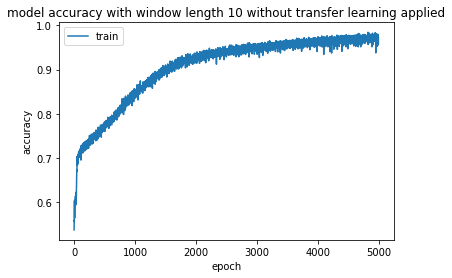

In [99]:
plt.plot(train_accs)
plt.title('model accuracy with window length 10 without transfer learning applied')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

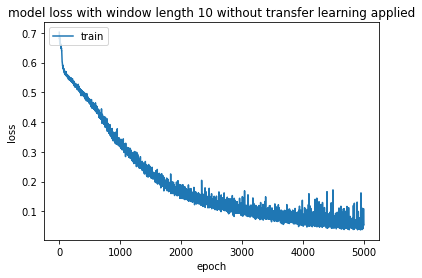

In [100]:
plt.plot(train_losses)
plt.title('model loss with window length 10 without transfer learning applied')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [101]:
base_model.reset_states()
test_results = calc_pos_neg_rate(base_model.evaluate(x=test_generator, verbose=0))

In [102]:
base_model.reset_states()
train_results = calc_pos_neg_rate(base_model.evaluate(x=train_generator, verbose=0))

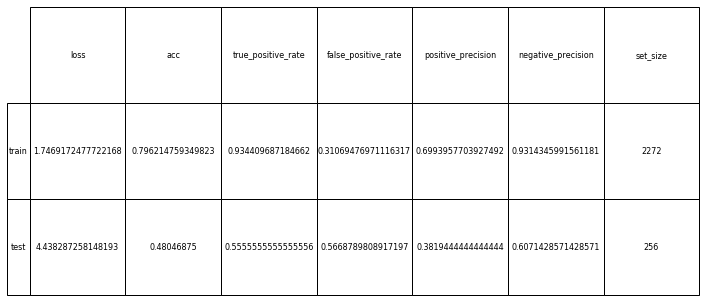

In [103]:
tabular_test_train_results(train_generator, test_generator, train_results, test_results)